In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras

In [59]:
data2 = pd.read_csv('oasis_longitudinal.csv')
data2.head()

Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  2.0  27.0  0.0  1987  0.696  0.883  
1  2.0  30.0  0.0  2004  0.681  0.876  
2  NaN  23.0  0.5  1678  0.736  1.046  
3  NaN  28.0  0.5  1738  0.713  1.010  
4  NaN  22.0  0.5  1698  0.701  1.034

In [60]:
data2.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [61]:
data2['SES'] = data2['SES'].fillna(np.round(data2['SES'].median()))
data2['MMSE'] = data2['MMSE'].fillna(data2['MMSE'].median())

In [62]:
data2.describe()

Visit     MR Delay         Age        EDUC         SES  \
count  373.000000   373.000000  373.000000  373.000000  373.000000   
mean     1.882038   595.104558   77.013405   14.597855    2.436997   
std      0.922843   635.485118    7.640957    2.876339    1.109307   
min      1.000000     0.000000   60.000000    6.000000    1.000000   
25%      1.000000     0.000000   71.000000   12.000000    2.000000   
50%      2.000000   552.000000   77.000000   15.000000    2.000000   
75%      2.000000   873.000000   82.000000   16.000000    3.000000   
max      5.000000  2639.000000   98.000000   23.000000    5.000000   

             MMSE         CDR         eTIV        nWBV         ASF  
count  373.000000  373.000000   373.000000  373.000000  373.000000  
mean    27.351206    0.290885  1488.128686    0.729568    1.195461  
std      3.675329    0.374557   176.139286    0.037135    0.138092  
min      4.000000    0.000000  1106.000000    0.644000    0.876000  
25%     27.000000    0.000000  1357.000000    0.700000    1.099000  
50%     29.000000    0.000000  1470.000000    0.729000    1.194000  
75%     30.000000    0.500000  1597.000000    0.756000    1.293000  
max     30.000000    2.000000  2004.000000    0.837000    1.587000

In [63]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
import shapely as shap
import seaborn as sns

sc = StandardScaler()

In [64]:
feats = ['M/F']
data22 = pd.get_dummies(data2, columns=feats, drop_first=True)
data22 = data22.set_index('Subject ID')
data22.head()

MRI ID        Group  Visit  MR Delay Hand  Age  EDUC  SES  \
Subject ID                                                                     
OAS2_0001   OAS2_0001_MR1  Nondemented      1         0    R   87    14  2.0   
OAS2_0001   OAS2_0001_MR2  Nondemented      2       457    R   88    14  2.0   
OAS2_0002   OAS2_0002_MR1     Demented      1         0    R   75    12  2.0   
OAS2_0002   OAS2_0002_MR2     Demented      2       560    R   76    12  2.0   
OAS2_0002   OAS2_0002_MR3     Demented      3      1895    R   80    12  2.0   

            MMSE  CDR  eTIV   nWBV    ASF  M/F_M  
Subject ID                                        
OAS2_0001   27.0  0.0  1987  0.696  0.883      1  
OAS2_0001   30.0  0.0  2004  0.681  0.876      1  
OAS2_0002   23.0  0.5  1678  0.736  1.046      1  
OAS2_0002   28.0  0.5  1738  0.713  1.010      1  
OAS2_0002   22.0  0.5  1698  0.701  1.034      1

In [65]:
feats=data22.drop(['Group', 'MRI ID','Hand', 'CDR', 'Visit'], axis=1)
feats['int_ses'] = data22['MMSE']/data22['SES']
feats['volume'] = data22['eTIV']*data22['nWBV']
feats['educ_age'] = data22['Age']-data22['EDUC']
X=feats
X.head()

MR Delay  Age  EDUC  SES  MMSE  eTIV   nWBV    ASF  M/F_M  \
Subject ID                                                              
OAS2_0001          0   87    14  2.0  27.0  1987  0.696  0.883      1   
OAS2_0001        457   88    14  2.0  30.0  2004  0.681  0.876      1   
OAS2_0002          0   75    12  2.0  23.0  1678  0.736  1.046      1   
OAS2_0002        560   76    12  2.0  28.0  1738  0.713  1.010      1   
OAS2_0002       1895   80    12  2.0  22.0  1698  0.701  1.034      1   

            int_ses    volume  educ_age  
Subject ID                               
OAS2_0001      13.5  1382.952        73  
OAS2_0001      15.0  1364.724        74  
OAS2_0002      11.5  1235.008        63  
OAS2_0002      14.0  1239.194        64  
OAS2_0002      11.0  1190.298        68

In [66]:
# feats=data22.drop(['Group', 'MRI ID','Hand', 'CDR','EDUC', 'Visit', 'ASF', 'MR Delay', 'M/F_M'], axis=1)
# feats['int_ses'] = data22['MMSE']/data22['SES']
# X=feats
# X.head()

In [67]:
#X_sc = sc.fit_transform(X)

In [68]:
y = pd.DataFrame([1 if i=='Demented' else 0 for i in data22['Group']])
y.head()

0
0  0
1  0
2  1
3  1
4  1

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [70]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(279, 12)
(94, 12)
(279, 1)
(94, 1)


# Feature Selection

## Permutation Importance

In [71]:
X.columns

Index(['MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF',
       'M/F_M', 'int_ses', 'volume', 'educ_age'],
      dtype='object')

In [72]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=200).fit(X_train, y_train)
np.round(rf.feature_importances_,4)

array([0.0681, 0.0632, 0.0558, 0.025 , 0.2953, 0.0663, 0.098 , 0.0604,
       0.0347, 0.1095, 0.0734, 0.0501])

In [73]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

## Alt. Feature Importances

In [74]:

shap.initjs()
xgbee.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgbee, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

AttributeError: module 'shapely' has no attribute 'initjs'

In [75]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
xgbee = XGBClassifier()
model = RandomForestClassifier()
rfe = RFE(xgbee, 8)
rfe = rfe.fit(X, y)

print(rfe.support_)
print(rfe.ranking_)
print(X.head(0))

[ True  True  True False  True False  True False  True False  True  True]
[1 1 1 3 1 2 1 4 1 5 1 1]
Empty DataFrame
Columns: [MR Delay, Age, EDUC, SES, MMSE, eTIV, nWBV, ASF, M/F_M, int_ses, volume, educ_age]
Index: []


## Correlations

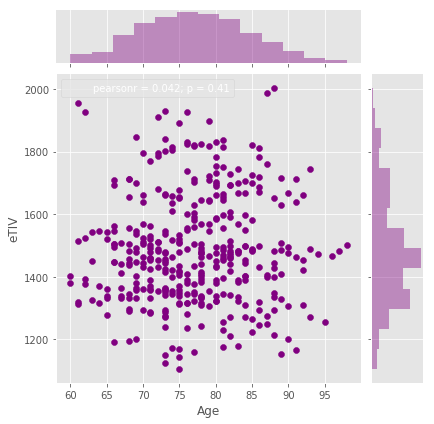

In [76]:
import seaborn as sns
import scipy.stats as stats

f = sns.jointplot(x="Age", y="eTIV", data=data22, color='purple')
f.annotate(stats.pearsonr)
plt.show();

In [77]:
X.corr().style.background_gradient('RdBu_r').set_precision(3)

## All Plot

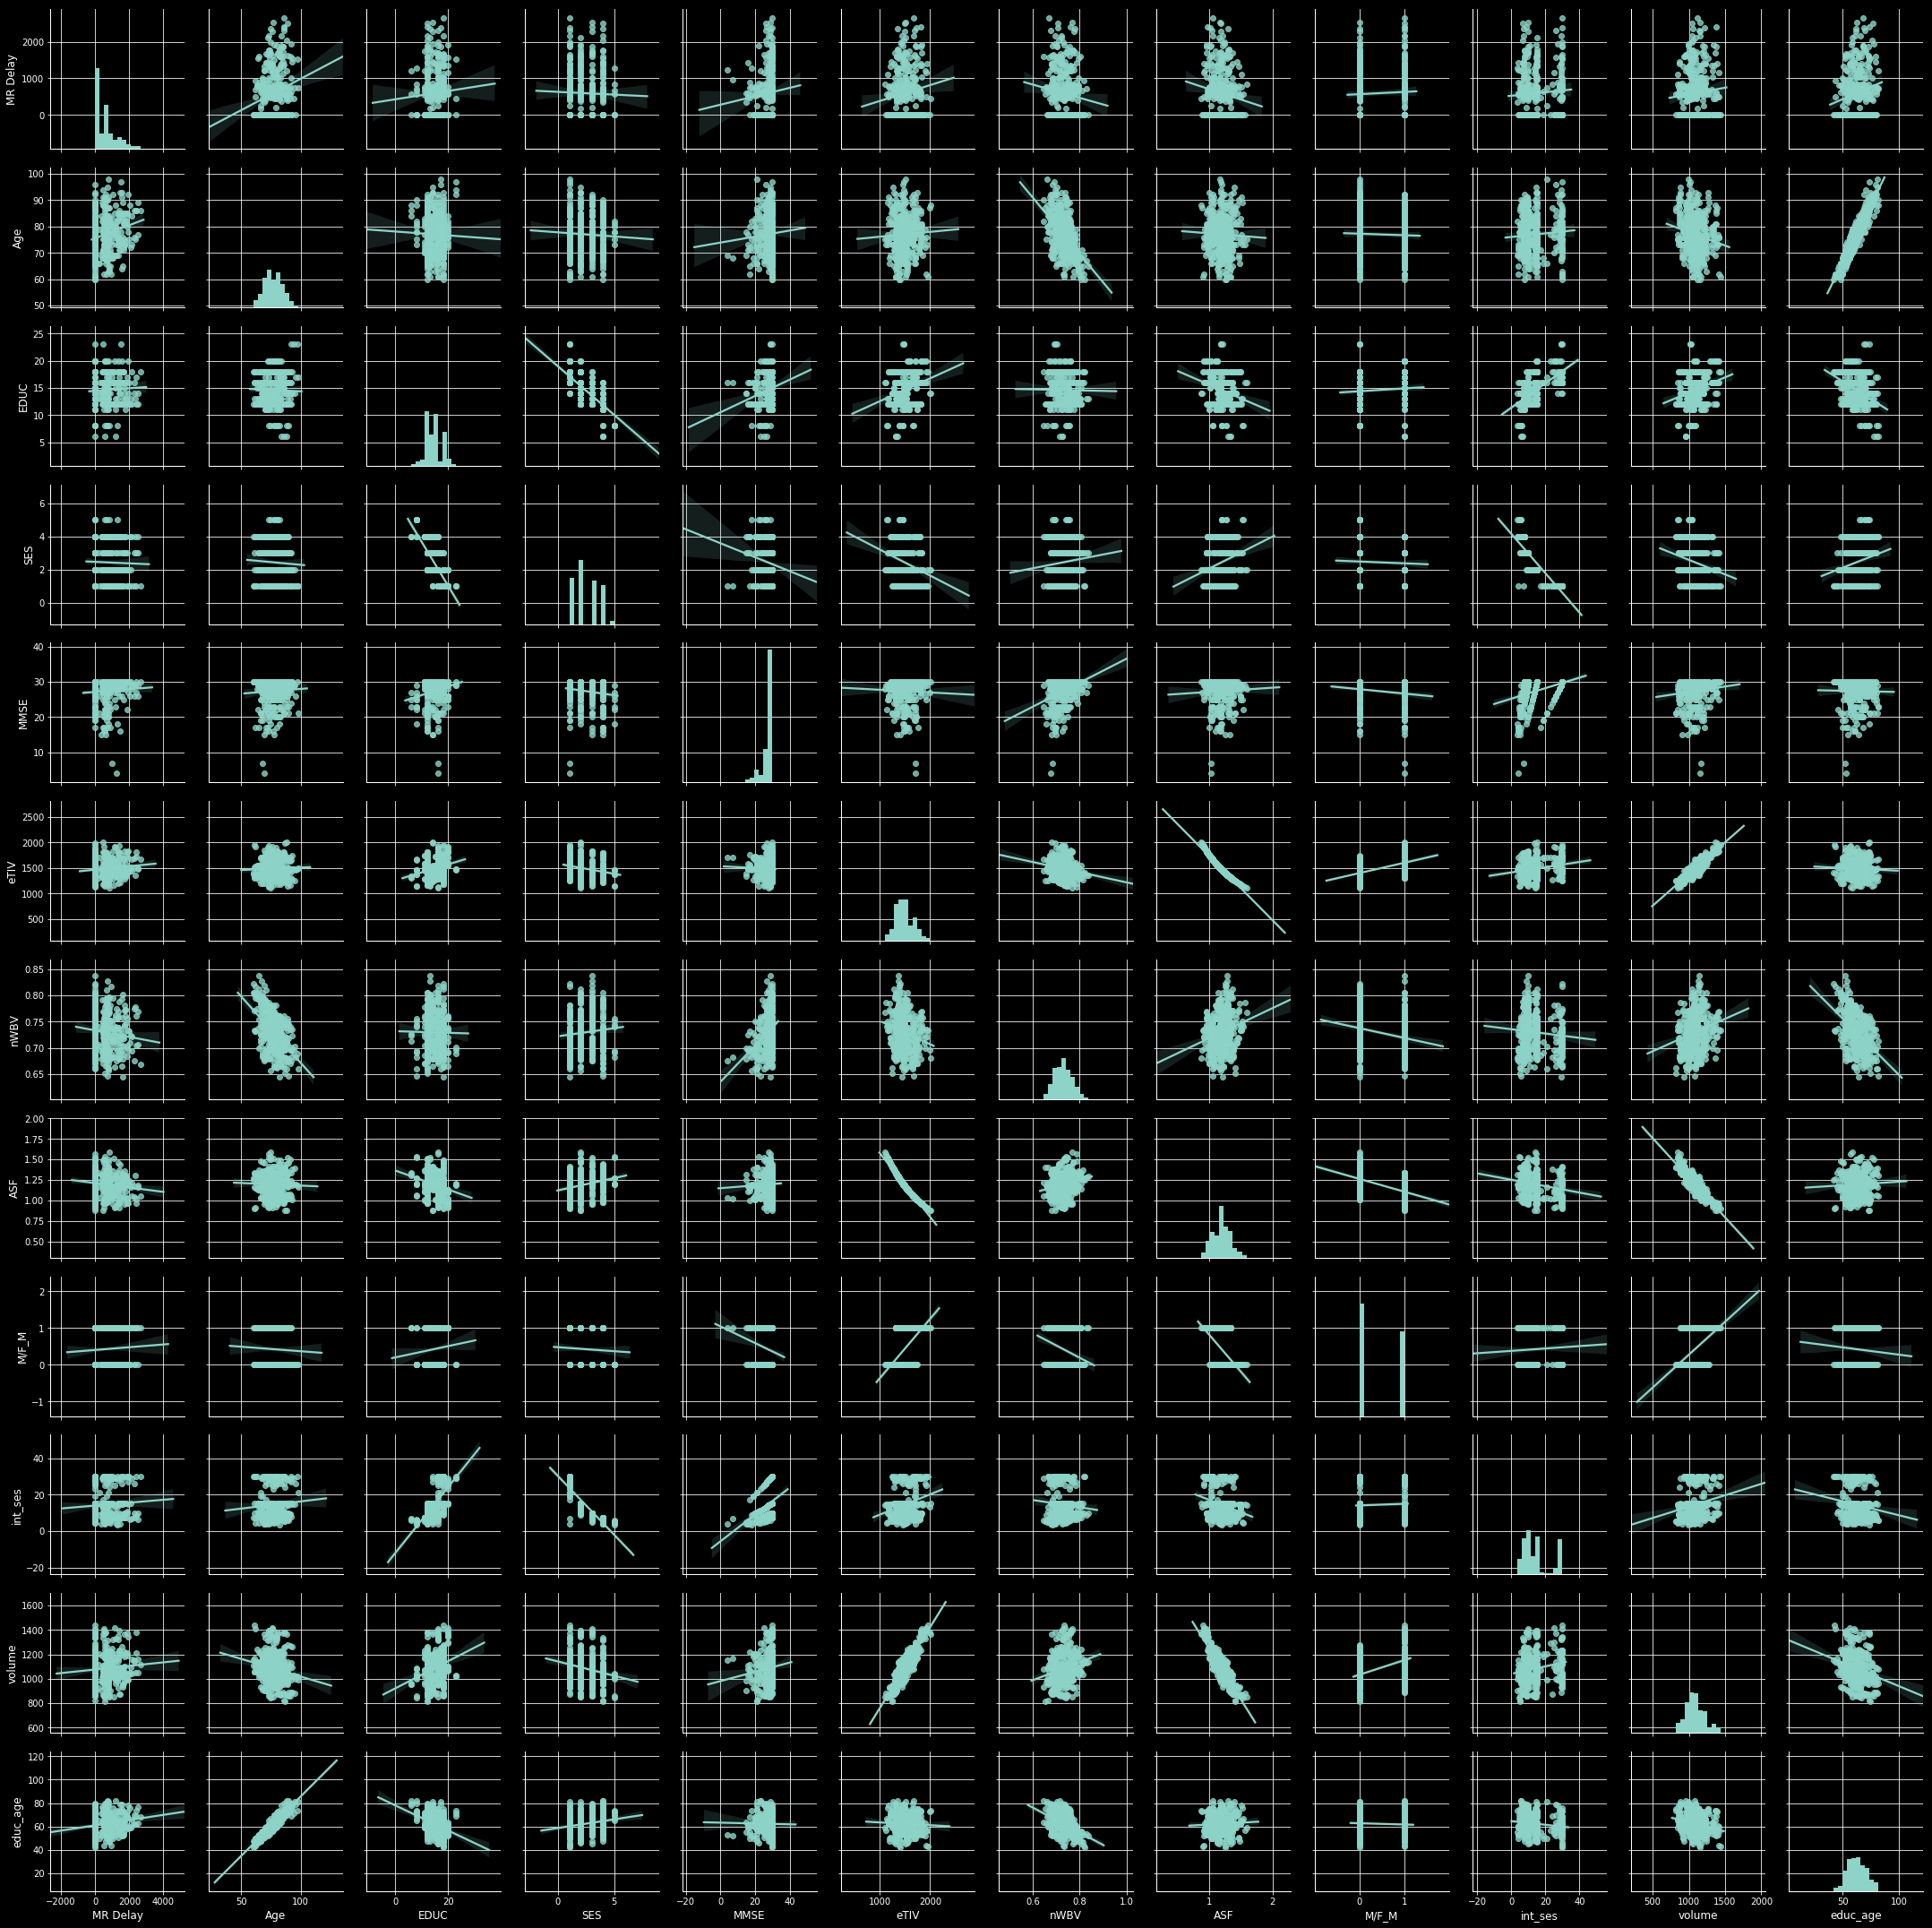

In [78]:
plt.style.use('dark_background')
sns.pairplot(X, kind='reg',diag_kind='hist')

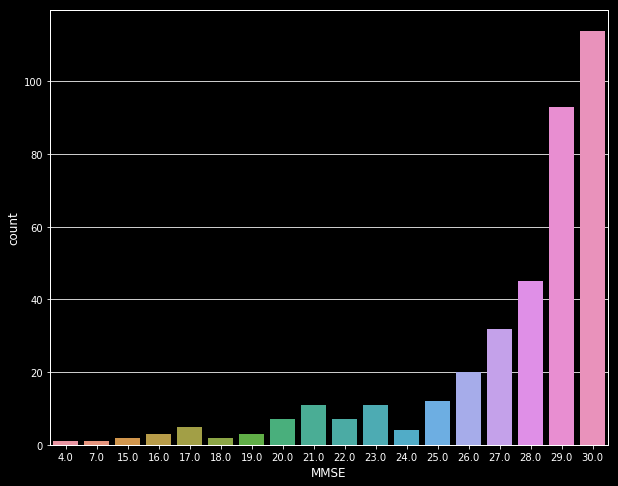

In [79]:
X_new = X.copy()
X_new['class'] = y
plt.figure(figsize=(10,8))
sns.countplot(x='MMSE',data=X_new)

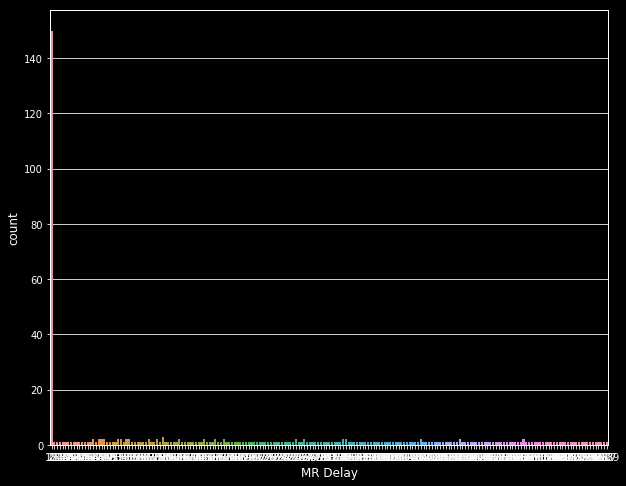

In [80]:
plt.figure(figsize=(10,8))
sns.countplot(x='MR Delay',data=X_new)

In [81]:
X['MR Delay'].value_counts()

0       150
580       3
756       2
842       2
647       2
665       2
610       2
1631      2
673       2
576       2
539       2
567       2
764       2
457       2
1204      2
846       2
504       2
472       2
486       2
518       2
538       2
1345      2
489       2
493       1
1752      1
729       1
672       1
1695      1
670       1
730       1
       ... 
2288      1
751       1
1770      1
1019      1
742       1
600       1
1806      1
1713      1
1340      1
790       1
851       1
2386      1
1927      1
1218      1
1351      1
1861      1
2369      1
1343      1
830       1
828       1
778       1
1707      1
1331      1
817       1
807       1
802       1
432       1
793       1
791       1
743       1
Name: MR Delay, Length: 201, dtype: int64

## Shap Explanations

In [82]:
X.head()

MR Delay  Age  EDUC  SES  MMSE  eTIV   nWBV    ASF  M/F_M  \
Subject ID                                                              
OAS2_0001          0   87    14  2.0  27.0  1987  0.696  0.883      1   
OAS2_0001        457   88    14  2.0  30.0  2004  0.681  0.876      1   
OAS2_0002          0   75    12  2.0  23.0  1678  0.736  1.046      1   
OAS2_0002        560   76    12  2.0  28.0  1738  0.713  1.010      1   
OAS2_0002       1895   80    12  2.0  22.0  1698  0.701  1.034      1   

            int_ses    volume  educ_age  
Subject ID                               
OAS2_0001      13.5  1382.952        73  
OAS2_0001      15.0  1364.724        74  
OAS2_0002      11.5  1235.008        63  
OAS2_0002      14.0  1239.194        64  
OAS2_0002      11.0  1190.298        68

In [83]:
from shapely import geometry
plt.style.use('ggplot')
new_X = X.drop(['MR Delay','SES','ASF','nWBV'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=42)
xgbee.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgbee, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

AttributeError: module 'shapely' has no attribute 'TreeExplainer'

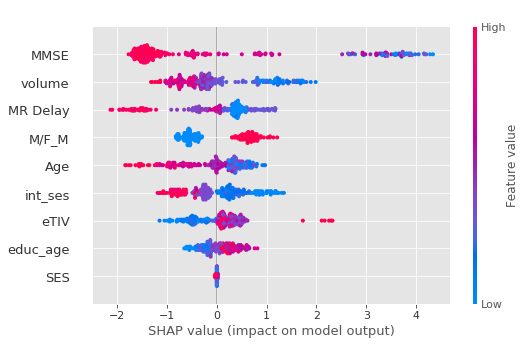

In [144]:
shap.summary_plot(shap_values, X_train)

In [149]:
rf1 = RandomForestClassifier().fit(X_train, y_train)
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
rf1.predict_proba(data_for_prediction_array)

explainer = shap.TreeExplainer(rf1)
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Could not find feature named: EDUC


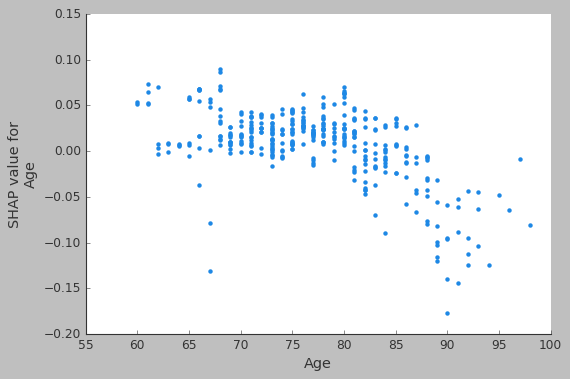

In [150]:
shap_values = explainer.shap_values(X)

shap.dependence_plot('Age', shap_values[1], X, interaction_index="EDUC")

# Models

## MLP

In [84]:
from sklearn.preprocessing import RobustScaler
new_X = X.drop(['ASF','nWBV'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=42)

In [85]:
mlp = MLPClassifier(hidden_layer_sizes=(200,200,200))
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
steps = [('scaler', StandardScaler()), ('mlp', mlp)]
alpha_space = [0.00001,0.0001,0.001,0.01]
params = [{'mlp__alpha' : alpha_space, 'mlp__solver':['lbfgs', 'sgd', 'adam'], 
               'mlp__learning_rate':['constant','invscaling','adaptive'],
              'mlp__max_iter':[10000,15000,20000],'mlp__activation':['identity', 'logistic', 'tanh', 'relu']}]
pipe = Pipeline(steps)
grid2 = GridSearchCV(pipe, param_grid=params, cv=5)

grid2.fit(X_train, y_train)
print("score = %3.2f" %(grid2.score(X_test,y_test)))
print(grid2.best_params_)

from sklearn.metrics import confusion_matrix
pred2 = grid2.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, pred2))

score = 0.80
{'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__learning_rate': 'adaptive', 'mlp__max_iter': 10000, 'mlp__solver': 'sgd'}
[[54 12]
 [10 36]]


In [86]:
print("Tuned MLP Parameters: {}".format(grid2.best_params_))
print("Best score is {}".format(grid2.best_score_))
print("Best estimator is {}".format(grid2.best_estimator_))

Tuned MLP Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__learning_rate': 'adaptive', 'mlp__max_iter': 10000, 'mlp__solver': 'sgd'}
Best score is 0.8888888888888888
Best estimator is Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPClassifier(activation='tanh', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 200, 200), learning_rate='adaptive',
       learn...e=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])


## SVM

In [87]:
from sklearn.svm import SVC

svm = SVC()
param_grid_svm = [{'svc__gamma' : [0.000001,0.00001, 0.0001 ,0.001, 0.01], 'svc__C':[0.01, 0.1, 1],
                   'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'svc__degree':[1,2,3,4,5]}]
steps = [('scaler', RobustScaler()), ('svc', svm)]
pipe = Pipeline(steps)

In [88]:
svm_cv=GridSearchCV(pipe, param_grid_svm, cv = 3)
svm_cv.fit(X_train, y_train)    
svm_cv.best_params_

{'svc__C': 1, 'svc__degree': 1, 'svc__gamma': 1e-06, 'svc__kernel': 'linear'}

In [89]:
svm_pred=svm_cv.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

[[56 10]
 [ 9 37]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        66
           1       0.79      0.80      0.80        46

   micro avg       0.83      0.83      0.83       112
   macro avg       0.82      0.83      0.83       112
weighted avg       0.83      0.83      0.83       112



## Logistic Regression


In [90]:
log = LogisticRegression()
param_grid_log = [{'log__C' : [1,10,100], 'log__solver':['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}]
steps = [('scaler', RobustScaler()), ('log', log)]
pipe = Pipeline(steps)

In [91]:
log_cv=GridSearchCV(pipe, param_grid_log, cv = 3)
log_cv.fit(X_train, y_train)    
log_cv.best_params_

{'log__C': 1, 'log__solver': 'liblinear'}

In [92]:
log_pred = log_cv.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, log_pred))
print(classification_report(y_test, log_pred))

[[54 12]
 [10 36]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        66
           1       0.75      0.78      0.77        46

   micro avg       0.80      0.80      0.80       112
   macro avg       0.80      0.80      0.80       112
weighted avg       0.81      0.80      0.80       112



## KNN


In [93]:
knn = KNeighborsClassifier()
param_grid_knn = [{'knn__n_neighbors' : [1,3,5,7,9], 'knn__algorithm':['auto', 'ball_tree', 'kd_tree','brute']}]
steps = [('scaler', RobustScaler()), ('knn', knn)]
pipe = Pipeline(steps)

In [94]:
knn_cv=GridSearchCV(pipe, param_grid_knn, cv = 3)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9], 'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [95]:
knn_pred = knn_cv.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

[[58  8]
 [12 34]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        66
           1       0.81      0.74      0.77        46

   micro avg       0.82      0.82      0.82       112
   macro avg       0.82      0.81      0.81       112
weighted avg       0.82      0.82      0.82       112



## XGBoost

In [96]:
import xgboost as xgb
xgbee = XGBClassifier()
xgbee.fit(X_train,y_train)
xgbee_pred = xgbee.predict(X_test)
print(confusion_matrix(y_test, xgbee_pred))
print(classification_report(y_test, xgbee_pred))
print(xgbee.feature_importances_)

[[58  8]
 [11 35]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        66
           1       0.81      0.76      0.79        46

   micro avg       0.83      0.83      0.83       112
   macro avg       0.83      0.82      0.82       112
weighted avg       0.83      0.83      0.83       112

[0.07282348 0.06661728 0.08754708 0.         0.42938998 0.0654242
 0.09121048 0.06308172 0.07206974 0.05183607]


In [97]:
#print(grid2.best_estimator_.score(X_test,y_test))
print(svm_cv.best_estimator_.score(X_test,y_test))
print(log_cv.best_estimator_.score(X_test,y_test))
print(knn_cv.best_estimator_.score(X_test,y_test))
print(xgbee.score(X_test,y_test))

0.8303571428571429
0.8035714285714286
0.8214285714285714
0.8303571428571429


## Keras

In [98]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Dropout

y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)

classifier = Sequential()
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(261, 10) (112, 10)
(261, 1) (112, 1)


In [102]:
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate=0.1))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.add(Dropout(rate=0.1))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 500)

ValueError: Error when checking input: expected dense_1_input to have shape (9,) but got array with shape (10,)

In [140]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred >= 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
#print(classifier.score(X_test, y_test))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78        66
           1       0.74      0.43      0.55        46

   micro avg       0.71      0.71      0.71       112
   macro avg       0.72      0.66      0.66       112
weighted avg       0.71      0.71      0.69       112

[[59  7]
 [26 20]]


In [73]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = 8))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [74]:
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Epoch 1/100
234/234 [==============================] - ETA: 3s - loss: 0.6930 - acc: 0.520 - 0s 2ms/step - loss: 0.6790 - acc: 0.6068
Epoch 2/100
234/234 [==============================] - ETA: 0s - loss: 0.6290 - acc: 0.760 - 0s 54us/step - loss: 0.6691 - acc: 0.6068
Epoch 3/100
234/234 [==============================] - ETA: 0s - loss: 0.6940 - acc: 0.560 - 0s 75us/step - loss: 0.6623 - acc: 0.6068
Epoch 4/100
234/234 [==============================] - ETA: 0s - loss: 0.6875 - acc: 0.560 - 0s 69us/step - loss: 0.6612 - acc: 0.6068
Epoch 5/100
234/234 [==============================] - ETA: 0s - loss: 0.6040 - acc: 0.720 - 0s 69us/step - loss: 0.6590 - acc: 0.6068
Epoch 6/100
234/234 [==============================] - ETA: 0s - loss: 0.6143 - acc: 0.720 - 0s 73us/step - loss: 0.6580 - acc: 0.6068
Epoch 7/100
234/234 [==============================] - ETA: 0s - loss: 0.8208 - acc: 0.280 - 0s 76us/step - loss: 0.6594 - acc: 0.6068
Epoch 8/100
234/234 [==============================] - E

235/235 [==============================] - ETA: 0s - loss: 0.6023 - acc: 0.640 - 0s 59us/step - loss: 0.6373 - acc: 0.5915
Epoch 22/100
235/235 [==============================] - ETA: 0s - loss: 0.6752 - acc: 0.600 - 0s 61us/step - loss: 0.6396 - acc: 0.5915
Epoch 23/100
235/235 [==============================] - ETA: 0s - loss: 0.6196 - acc: 0.480 - 0s 65us/step - loss: 0.6362 - acc: 0.5915
Epoch 24/100
235/235 [==============================] - ETA: 0s - loss: 0.5938 - acc: 0.600 - 0s 62us/step - loss: 0.6390 - acc: 0.5915
Epoch 25/100
235/235 [==============================] - ETA: 0s - loss: 0.5336 - acc: 0.680 - 0s 60us/step - loss: 0.6360 - acc: 0.5915
Epoch 26/100
235/235 [==============================] - ETA: 0s - loss: 0.7404 - acc: 0.320 - 0s 69us/step - loss: 0.6369 - acc: 0.5915
Epoch 27/100
235/235 [==============================] - ETA: 0s - loss: 0.5939 - acc: 0.760 - 0s 66us/step - loss: 0.6362 - acc: 0.5915
Epoch 28/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.6581 - acc: 0.640 - 0s 62us/step - loss: 0.6667 - acc: 0.6170
Epoch 42/100
235/235 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.600 - 0s 64us/step - loss: 0.6667 - acc: 0.6170
Epoch 43/100
235/235 [==============================] - ETA: 0s - loss: 0.7194 - acc: 0.480 - 0s 62us/step - loss: 0.6664 - acc: 0.6170
Epoch 44/100
235/235 [==============================] - ETA: 0s - loss: 0.6887 - acc: 0.560 - 0s 62us/step - loss: 0.6664 - acc: 0.6170
Epoch 45/100
235/235 [==============================] - ETA: 0s - loss: 0.7211 - acc: 0.480 - 0s 66us/step - loss: 0.6662 - acc: 0.6170
Epoch 46/100
235/235 [==============================] - ETA: 0s - loss: 0.6730 - acc: 0.600 - 0s 91us/step - loss: 0.6661 - acc: 0.6170
Epoch 47/100
235/235 [==============================] - ETA: 0s - loss: 0.6567 - acc: 0.640 - 0s 65us/step - loss: 0.6660 - acc: 0.6170
Epoch 48/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.6867 - acc: 0.560 - 0s 62us/step - loss: 0.6685 - acc: 0.6170
Epoch 62/100
235/235 [==============================] - ETA: 0s - loss: 0.6867 - acc: 0.560 - 0s 58us/step - loss: 0.6684 - acc: 0.6170
Epoch 63/100
235/235 [==============================] - ETA: 0s - loss: 0.6738 - acc: 0.600 - 0s 59us/step - loss: 0.6683 - acc: 0.6170
Epoch 64/100
235/235 [==============================] - ETA: 0s - loss: 0.6607 - acc: 0.640 - 0s 55us/step - loss: 0.6682 - acc: 0.6170
Epoch 65/100
235/235 [==============================] - ETA: 0s - loss: 0.7000 - acc: 0.520 - 0s 49us/step - loss: 0.6680 - acc: 0.6170
Epoch 66/100
235/235 [==============================] - ETA: 0s - loss: 0.6869 - acc: 0.560 - 0s 70us/step - loss: 0.6679 - acc: 0.6170
Epoch 67/100
235/235 [==============================] - ETA: 0s - loss: 0.7005 - acc: 0.520 - 0s 67us/step - loss: 0.6678 - acc: 0.6170
Epoch 68/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.6983 - acc: 0.600 - 0s 74us/step - loss: 0.6147 - acc: 0.6170
Epoch 82/100
235/235 [==============================] - ETA: 0s - loss: 0.7451 - acc: 0.520 - 0s 72us/step - loss: 0.6122 - acc: 0.6170
Epoch 83/100
235/235 [==============================] - ETA: 0s - loss: 0.5605 - acc: 0.680 - 0s 58us/step - loss: 0.6170 - acc: 0.6170
Epoch 84/100
235/235 [==============================] - ETA: 0s - loss: 0.5808 - acc: 0.640 - 0s 60us/step - loss: 0.6115 - acc: 0.6170
Epoch 85/100
235/235 [==============================] - ETA: 0s - loss: 0.6794 - acc: 0.600 - 0s 68us/step - loss: 0.6100 - acc: 0.6170
Epoch 86/100
235/235 [==============================] - ETA: 0s - loss: 0.6270 - acc: 0.560 - 0s 68us/step - loss: 0.6085 - acc: 0.6170
Epoch 87/100
235/235 [==============================] - ETA: 0s - loss: 0.4973 - acc: 0.720 - 0s 71us/step - loss: 0.6114 - acc: 0.6170
Epoch 88/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 5s - loss: 0.6928 - acc: 0.520 - 1s 3ms/step - loss: 0.6903 - acc: 0.6170
Epoch 2/100
235/235 [==============================] - ETA: 0s - loss: 0.6916 - acc: 0.520 - 0s 65us/step - loss: 0.6824 - acc: 0.6170
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.6575 - acc: 0.720 - 0s 67us/step - loss: 0.6675 - acc: 0.6170
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.6910 - acc: 0.560 - 0s 65us/step - loss: 0.6544 - acc: 0.6170
Epoch 5/100
235/235 [==============================] - ETA: 0s - loss: 0.6673 - acc: 0.600 - 0s 53us/step - loss: 0.6537 - acc: 0.6170
Epoch 6/100
235/235 [==============================] - ETA: 0s - loss: 0.6351 - acc: 0.640 - 0s 67us/step - loss: 0.6496 - acc: 0.6170
Epoch 7/100
235/235 [==============================] - ETA: 0s - loss: 0.6233 - acc: 0.680 - 0s 66us/step - loss: 0.6484 - acc: 0.6170
Epoch 8/100
235/235 [==============================] - ETA: 0s - los

235/235 [==============================] - ETA: 0s - loss: 0.6870 - acc: 0.560 - 0s 75us/step - loss: 0.6773 - acc: 0.6255
Epoch 22/100
235/235 [==============================] - ETA: 0s - loss: 0.6808 - acc: 0.600 - 0s 58us/step - loss: 0.6766 - acc: 0.6255
Epoch 23/100
235/235 [==============================] - ETA: 0s - loss: 0.6614 - acc: 0.720 - 0s 57us/step - loss: 0.6762 - acc: 0.6255
Epoch 24/100
235/235 [==============================] - ETA: 0s - loss: 0.6734 - acc: 0.640 - 0s 65us/step - loss: 0.6756 - acc: 0.6255
Epoch 25/100
235/235 [==============================] - ETA: 0s - loss: 0.6797 - acc: 0.600 - 0s 65us/step - loss: 0.6751 - acc: 0.6255
Epoch 26/100
235/235 [==============================] - ETA: 0s - loss: 0.6652 - acc: 0.680 - 0s 65us/step - loss: 0.6746 - acc: 0.6255
Epoch 27/100
235/235 [==============================] - ETA: 0s - loss: 0.6718 - acc: 0.640 - 0s 79us/step - loss: 0.6742 - acc: 0.6255
Epoch 28/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.7069 - acc: 0.640 - 0s 80us/step - loss: 0.6278 - acc: 0.6383
Epoch 42/100
235/235 [==============================] - ETA: 0s - loss: 0.6871 - acc: 0.560 - 0s 67us/step - loss: 0.6266 - acc: 0.6128
Epoch 43/100
235/235 [==============================] - ETA: 0s - loss: 0.7300 - acc: 0.520 - 0s 58us/step - loss: 0.6279 - acc: 0.6468
Epoch 44/100
235/235 [==============================] - ETA: 0s - loss: 0.6140 - acc: 0.640 - 0s 63us/step - loss: 0.6276 - acc: 0.6298
Epoch 45/100
235/235 [==============================] - ETA: 0s - loss: 0.7134 - acc: 0.520 - 0s 66us/step - loss: 0.6313 - acc: 0.6383
Epoch 46/100
235/235 [==============================] - ETA: 0s - loss: 0.7124 - acc: 0.640 - 0s 60us/step - loss: 0.6232 - acc: 0.6638
Epoch 47/100
235/235 [==============================] - ETA: 0s - loss: 0.6315 - acc: 0.480 - 0s 84us/step - loss: 0.6271 - acc: 0.6255
Epoch 48/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.6007 - acc: 0.640 - 0s 64us/step - loss: 0.6186 - acc: 0.6213
Epoch 62/100
235/235 [==============================] - ETA: 0s - loss: 0.5493 - acc: 0.640 - 0s 68us/step - loss: 0.6195 - acc: 0.6383
Epoch 63/100
235/235 [==============================] - ETA: 0s - loss: 0.6097 - acc: 0.600 - 0s 72us/step - loss: 0.6120 - acc: 0.6298
Epoch 64/100
235/235 [==============================] - ETA: 0s - loss: 0.6060 - acc: 0.640 - 0s 70us/step - loss: 0.6082 - acc: 0.6213
Epoch 65/100
235/235 [==============================] - ETA: 0s - loss: 0.6440 - acc: 0.560 - 0s 66us/step - loss: 0.6099 - acc: 0.6213
Epoch 66/100
235/235 [==============================] - ETA: 0s - loss: 0.6283 - acc: 0.640 - 0s 61us/step - loss: 0.6121 - acc: 0.6809
Epoch 67/100
235/235 [==============================] - ETA: 0s - loss: 0.5234 - acc: 0.680 - 0s 65us/step - loss: 0.6068 - acc: 0.6213
Epoch 68/100
235/235 [==============================] - ETA: 

234/234 [==============================] - ETA: 0s - loss: 0.6143 - acc: 0.640 - 0s 67us/step - loss: 0.5973 - acc: 0.6624
Epoch 82/100
234/234 [==============================] - ETA: 0s - loss: 0.5497 - acc: 0.720 - 0s 73us/step - loss: 0.5944 - acc: 0.6410
Epoch 83/100
234/234 [==============================] - ETA: 0s - loss: 0.5457 - acc: 0.720 - 0s 65us/step - loss: 0.6027 - acc: 0.6838
Epoch 84/100
234/234 [==============================] - ETA: 0s - loss: 0.5054 - acc: 0.760 - 0s 56us/step - loss: 0.5971 - acc: 0.6667
Epoch 85/100
234/234 [==============================] - ETA: 0s - loss: 0.5232 - acc: 0.760 - 0s 70us/step - loss: 0.5924 - acc: 0.6581
Epoch 86/100
234/234 [==============================] - ETA: 0s - loss: 0.6262 - acc: 0.640 - 0s 73us/step - loss: 0.5929 - acc: 0.6752
Epoch 87/100
234/234 [==============================] - ETA: 0s - loss: 0.5592 - acc: 0.720 - 0s 58us/step - loss: 0.5862 - acc: 0.6667
Epoch 88/100
234/234 [==============================] - ETA: 

235/235 [==============================] - ETA: 6s - loss: 0.6899 - acc: 0.680 - 1s 4ms/step - loss: 0.6835 - acc: 0.6170
Epoch 2/100
235/235 [==============================] - ETA: 0s - loss: 0.6862 - acc: 0.560 - 0s 74us/step - loss: 0.6653 - acc: 0.6170
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.6261 - acc: 0.680 - 0s 67us/step - loss: 0.6588 - acc: 0.6170
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.6548 - acc: 0.600 - 0s 62us/step - loss: 0.6563 - acc: 0.6170
Epoch 5/100
235/235 [==============================] - ETA: 0s - loss: 0.6902 - acc: 0.520 - 0s 67us/step - loss: 0.6554 - acc: 0.6170
Epoch 6/100
235/235 [==============================] - ETA: 0s - loss: 0.6793 - acc: 0.560 - 0s 68us/step - loss: 0.6554 - acc: 0.6170
Epoch 7/100
235/235 [==============================] - ETA: 0s - loss: 0.7022 - acc: 0.520 - 0s 64us/step - loss: 0.6532 - acc: 0.6170
Epoch 8/100
235/235 [==============================] - ETA: 0s - los

235/235 [==============================] - ETA: 0s - loss: 0.5864 - acc: 0.560 - 0s 65us/step - loss: 0.6160 - acc: 0.6170
Epoch 22/100
235/235 [==============================] - ETA: 0s - loss: 0.6319 - acc: 0.600 - 0s 54us/step - loss: 0.6142 - acc: 0.6170
Epoch 23/100
235/235 [==============================] - ETA: 0s - loss: 0.4786 - acc: 0.800 - 0s 61us/step - loss: 0.6176 - acc: 0.6170
Epoch 24/100
235/235 [==============================] - ETA: 0s - loss: 0.6449 - acc: 0.640 - 0s 70us/step - loss: 0.6152 - acc: 0.6170
Epoch 25/100
235/235 [==============================] - ETA: 0s - loss: 0.7031 - acc: 0.560 - 0s 63us/step - loss: 0.6135 - acc: 0.6170
Epoch 26/100
235/235 [==============================] - ETA: 0s - loss: 0.6413 - acc: 0.600 - 0s 71us/step - loss: 0.6156 - acc: 0.6170
Epoch 27/100
235/235 [==============================] - ETA: 0s - loss: 0.5684 - acc: 0.680 - 0s 60us/step - loss: 0.6143 - acc: 0.6170
Epoch 28/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.6651 - acc: 0.560 - 0s 86us/step - loss: 0.6389 - acc: 0.6170
Epoch 42/100
235/235 [==============================] - ETA: 0s - loss: 0.6352 - acc: 0.600 - 0s 77us/step - loss: 0.6380 - acc: 0.6170
Epoch 43/100
235/235 [==============================] - ETA: 0s - loss: 0.7307 - acc: 0.400 - 0s 75us/step - loss: 0.6386 - acc: 0.6170
Epoch 44/100
235/235 [==============================] - ETA: 0s - loss: 0.6449 - acc: 0.600 - 0s 57us/step - loss: 0.6374 - acc: 0.6170
Epoch 45/100
235/235 [==============================] - ETA: 0s - loss: 0.6540 - acc: 0.600 - 0s 69us/step - loss: 0.6364 - acc: 0.6170
Epoch 46/100
235/235 [==============================] - ETA: 0s - loss: 0.6449 - acc: 0.640 - 0s 56us/step - loss: 0.6375 - acc: 0.6213
Epoch 47/100
235/235 [==============================] - ETA: 0s - loss: 0.6432 - acc: 0.600 - 0s 82us/step - loss: 0.6355 - acc: 0.6170
Epoch 48/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.5430 - acc: 0.680 - 0s 72us/step - loss: 0.5993 - acc: 0.6468
Epoch 62/100
235/235 [==============================] - ETA: 0s - loss: 0.6979 - acc: 0.560 - 0s 90us/step - loss: 0.6014 - acc: 0.6468
Epoch 63/100
235/235 [==============================] - ETA: 0s - loss: 0.5983 - acc: 0.680 - 0s 73us/step - loss: 0.5982 - acc: 0.6468
Epoch 64/100
235/235 [==============================] - ETA: 0s - loss: 0.6558 - acc: 0.680 - 0s 68us/step - loss: 0.6015 - acc: 0.6468
Epoch 65/100
235/235 [==============================] - ETA: 0s - loss: 0.5295 - acc: 0.680 - 0s 80us/step - loss: 0.5988 - acc: 0.6468
Epoch 66/100
235/235 [==============================] - ETA: 0s - loss: 0.6613 - acc: 0.600 - 0s 82us/step - loss: 0.5999 - acc: 0.6468
Epoch 67/100
235/235 [==============================] - ETA: 0s - loss: 0.4931 - acc: 0.720 - 0s 77us/step - loss: 0.6006 - acc: 0.6468
Epoch 68/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.6651 - acc: 0.640 - 0s 58us/step - loss: 0.6310 - acc: 0.6511
Epoch 82/100
235/235 [==============================] - ETA: 0s - loss: 0.6710 - acc: 0.520 - 0s 68us/step - loss: 0.6289 - acc: 0.6340
Epoch 83/100
235/235 [==============================] - ETA: 0s - loss: 0.6374 - acc: 0.600 - 0s 76us/step - loss: 0.6291 - acc: 0.6298
Epoch 84/100
235/235 [==============================] - ETA: 0s - loss: 0.5590 - acc: 0.800 - 0s 68us/step - loss: 0.6282 - acc: 0.6553
Epoch 85/100
235/235 [==============================] - ETA: 0s - loss: 0.6973 - acc: 0.480 - 0s 64us/step - loss: 0.6299 - acc: 0.6553
Epoch 86/100
235/235 [==============================] - ETA: 0s - loss: 0.6594 - acc: 0.600 - 0s 73us/step - loss: 0.6283 - acc: 0.6255
Epoch 87/100
235/235 [==============================] - ETA: 0s - loss: 0.6639 - acc: 0.600 - 0s 69us/step - loss: 0.6289 - acc: 0.6298
Epoch 88/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 5s - loss: 0.6931 - acc: 0.640 - 1s 3ms/step - loss: 0.6924 - acc: 0.6128
Epoch 2/100
235/235 [==============================] - ETA: 0s - loss: 0.6912 - acc: 0.640 - 0s 82us/step - loss: 0.6912 - acc: 0.6128
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.6881 - acc: 0.720 - 0s 70us/step - loss: 0.6903 - acc: 0.6128
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.6879 - acc: 0.680 - 0s 77us/step - loss: 0.6896 - acc: 0.6128
Epoch 5/100
235/235 [==============================] - ETA: 0s - loss: 0.6926 - acc: 0.520 - 0s 73us/step - loss: 0.6888 - acc: 0.6128
Epoch 6/100
235/235 [==============================] - ETA: 0s - loss: 0.6852 - acc: 0.680 - 0s 79us/step - loss: 0.6881 - acc: 0.6128
Epoch 7/100
235/235 [==============================] - ETA: 0s - loss: 0.6884 - acc: 0.600 - 0s 85us/step - loss: 0.6876 - acc: 0.6128
Epoch 8/100
235/235 [==============================] - ETA: 0s - los

235/235 [==============================] - ETA: 0s - loss: 0.5603 - acc: 0.760 - 0s 82us/step - loss: 0.6427 - acc: 0.6170
Epoch 22/100
235/235 [==============================] - ETA: 0s - loss: 0.6725 - acc: 0.640 - 0s 83us/step - loss: 0.6382 - acc: 0.6170
Epoch 23/100
235/235 [==============================] - ETA: 0s - loss: 0.5566 - acc: 0.720 - 0s 79us/step - loss: 0.6378 - acc: 0.6170
Epoch 24/100
235/235 [==============================] - ETA: 0s - loss: 0.6380 - acc: 0.680 - 0s 87us/step - loss: 0.6391 - acc: 0.6170
Epoch 25/100
235/235 [==============================] - ETA: 0s - loss: 0.6163 - acc: 0.640 - 0s 75us/step - loss: 0.6382 - acc: 0.6170
Epoch 26/100
235/235 [==============================] - ETA: 0s - loss: 0.6367 - acc: 0.520 - 0s 80us/step - loss: 0.6374 - acc: 0.6170
Epoch 27/100
235/235 [==============================] - ETA: 0s - loss: 0.5487 - acc: 0.640 - 0s 82us/step - loss: 0.6403 - acc: 0.6170
Epoch 28/100
235/235 [==============================] - ETA: 

234/234 [==============================] - ETA: 0s - loss: 0.5231 - acc: 0.920 - 0s 89us/step - loss: 0.6302 - acc: 0.6197
Epoch 42/500
234/234 [==============================] - ETA: 0s - loss: 0.6725 - acc: 0.520 - 0s 84us/step - loss: 0.6302 - acc: 0.6667
Epoch 43/500
234/234 [==============================] - ETA: 0s - loss: 0.5514 - acc: 0.600 - 0s 87us/step - loss: 0.6271 - acc: 0.6368
Epoch 44/500
234/234 [==============================] - ETA: 0s - loss: 0.5960 - acc: 0.640 - 0s 80us/step - loss: 0.6274 - acc: 0.6068
Epoch 45/500
234/234 [==============================] - ETA: 0s - loss: 0.6379 - acc: 0.640 - 0s 88us/step - loss: 0.6277 - acc: 0.6068
Epoch 46/500
234/234 [==============================] - ETA: 0s - loss: 0.6009 - acc: 0.560 - 0s 87us/step - loss: 0.6231 - acc: 0.6068
Epoch 47/500
234/234 [==============================] - ETA: 0s - loss: 0.6701 - acc: 0.480 - 0s 81us/step - loss: 0.6257 - acc: 0.6325
Epoch 48/500
234/234 [==============================] - ETA: 

Epoch 161/500
234/234 [==============================] - ETA: 0s - loss: 0.4834 - acc: 0.720 - 0s 93us/step - loss: 0.4977 - acc: 0.7778
Epoch 162/500
234/234 [==============================] - ETA: 0s - loss: 0.4031 - acc: 0.880 - 0s 73us/step - loss: 0.4999 - acc: 0.7778
Epoch 163/500
234/234 [==============================] - ETA: 0s - loss: 0.5472 - acc: 0.720 - 0s 67us/step - loss: 0.4960 - acc: 0.7692
Epoch 164/500
234/234 [==============================] - ETA: 0s - loss: 0.5248 - acc: 0.760 - 0s 70us/step - loss: 0.4926 - acc: 0.8034
Epoch 165/500
234/234 [==============================] - ETA: 0s - loss: 0.4054 - acc: 0.800 - 0s 71us/step - loss: 0.4931 - acc: 0.7735
Epoch 166/500
234/234 [==============================] - ETA: 0s - loss: 0.6070 - acc: 0.720 - 0s 74us/step - loss: 0.4894 - acc: 0.7821
Epoch 167/500
234/234 [==============================] - ETA: 0s - loss: 0.4544 - acc: 0.840 - 0s 79us/step - loss: 0.4925 - acc: 0.7692
Epoch 168/500
234/234 [==================

Epoch 221/500
234/234 [==============================] - ETA: 0s - loss: 0.5219 - acc: 0.760 - 0s 82us/step - loss: 0.4811 - acc: 0.7735
Epoch 222/500
234/234 [==============================] - ETA: 0s - loss: 0.4241 - acc: 0.840 - 0s 84us/step - loss: 0.4850 - acc: 0.7863
Epoch 223/500
234/234 [==============================] - ETA: 0s - loss: 0.5244 - acc: 0.760 - 0s 74us/step - loss: 0.4927 - acc: 0.7778
Epoch 224/500
234/234 [==============================] - ETA: 0s - loss: 0.5194 - acc: 0.600 - 0s 89us/step - loss: 0.4926 - acc: 0.7521
Epoch 225/500
234/234 [==============================] - ETA: 0s - loss: 0.4373 - acc: 0.880 - 0s 69us/step - loss: 0.4873 - acc: 0.7821
Epoch 226/500
234/234 [==============================] - ETA: 0s - loss: 0.3415 - acc: 0.840 - 0s 85us/step - loss: 0.4915 - acc: 0.7778
Epoch 227/500
234/234 [==============================] - ETA: 0s - loss: 0.4256 - acc: 0.840 - 0s 78us/step - loss: 0.4827 - acc: 0.7735
Epoch 228/500
234/234 [==================

Epoch 281/500
234/234 [==============================] - ETA: 0s - loss: 0.3708 - acc: 0.880 - 0s 77us/step - loss: 0.4651 - acc: 0.7863
Epoch 282/500
234/234 [==============================] - ETA: 0s - loss: 0.4727 - acc: 0.840 - 0s 77us/step - loss: 0.4670 - acc: 0.7821
Epoch 283/500
234/234 [==============================] - ETA: 0s - loss: 0.5423 - acc: 0.720 - 0s 71us/step - loss: 0.4656 - acc: 0.7863
Epoch 284/500
234/234 [==============================] - ETA: 0s - loss: 0.5025 - acc: 0.760 - 0s 75us/step - loss: 0.4661 - acc: 0.7650
Epoch 285/500
234/234 [==============================] - ETA: 0s - loss: 0.4369 - acc: 0.800 - 0s 71us/step - loss: 0.4687 - acc: 0.7821
Epoch 286/500
234/234 [==============================] - ETA: 0s - loss: 0.3580 - acc: 0.840 - 0s 69us/step - loss: 0.4773 - acc: 0.7692
Epoch 287/500
234/234 [==============================] - ETA: 0s - loss: 0.3471 - acc: 0.840 - 0s 87us/step - loss: 0.4769 - acc: 0.7778
Epoch 288/500
234/234 [==================

Epoch 341/500
234/234 [==============================] - ETA: 0s - loss: 0.4416 - acc: 0.800 - 0s 93us/step - loss: 0.4634 - acc: 0.7735
Epoch 342/500
234/234 [==============================] - ETA: 0s - loss: 0.4663 - acc: 0.760 - 0s 83us/step - loss: 0.4750 - acc: 0.7650
Epoch 343/500
234/234 [==============================] - ETA: 0s - loss: 0.2796 - acc: 0.880 - 0s 78us/step - loss: 0.4621 - acc: 0.7821
Epoch 344/500
234/234 [==============================] - ETA: 0s - loss: 0.4289 - acc: 0.800 - 0s 75us/step - loss: 0.4666 - acc: 0.7821
Epoch 345/500
234/234 [==============================] - ETA: 0s - loss: 0.3503 - acc: 0.920 - 0s 70us/step - loss: 0.4582 - acc: 0.7863
Epoch 346/500
234/234 [==============================] - ETA: 0s - loss: 0.5299 - acc: 0.760 - 0s 75us/step - loss: 0.4578 - acc: 0.7778
Epoch 347/500
234/234 [==============================] - ETA: 0s - loss: 0.4466 - acc: 0.760 - 0s 68us/step - loss: 0.4639 - acc: 0.7778
Epoch 348/500
234/234 [==================

Epoch 401/500
234/234 [==============================] - ETA: 0s - loss: 0.3318 - acc: 0.880 - 0s 73us/step - loss: 0.4498 - acc: 0.7863
Epoch 402/500
234/234 [==============================] - ETA: 0s - loss: 0.3781 - acc: 0.800 - 0s 81us/step - loss: 0.4518 - acc: 0.7991
Epoch 403/500
234/234 [==============================] - ETA: 0s - loss: 0.4613 - acc: 0.800 - 0s 82us/step - loss: 0.4598 - acc: 0.7949
Epoch 404/500
234/234 [==============================] - ETA: 0s - loss: 0.5243 - acc: 0.840 - 0s 79us/step - loss: 0.4566 - acc: 0.7863
Epoch 405/500
234/234 [==============================] - ETA: 0s - loss: 0.4482 - acc: 0.760 - 0s 72us/step - loss: 0.4527 - acc: 0.7906
Epoch 406/500
234/234 [==============================] - ETA: 0s - loss: 0.3805 - acc: 0.840 - 0s 83us/step - loss: 0.4498 - acc: 0.7735
Epoch 407/500
234/234 [==============================] - ETA: 0s - loss: 0.5086 - acc: 0.760 - 0s 98us/step - loss: 0.4493 - acc: 0.7949
Epoch 408/500
234/234 [==================

Epoch 461/500
234/234 [==============================] - ETA: 0s - loss: 0.4219 - acc: 0.760 - 0s 87us/step - loss: 0.4512 - acc: 0.7821
Epoch 462/500
234/234 [==============================] - ETA: 0s - loss: 0.3867 - acc: 0.720 - 0s 77us/step - loss: 0.4666 - acc: 0.7821
Epoch 463/500
234/234 [==============================] - ETA: 0s - loss: 0.6374 - acc: 0.600 - 0s 76us/step - loss: 0.4638 - acc: 0.7735
Epoch 464/500
234/234 [==============================] - ETA: 0s - loss: 0.5511 - acc: 0.800 - 0s 71us/step - loss: 0.4493 - acc: 0.7906
Epoch 465/500
234/234 [==============================] - ETA: 0s - loss: 0.3832 - acc: 0.760 - 0s 67us/step - loss: 0.4442 - acc: 0.7906
Epoch 466/500
234/234 [==============================] - ETA: 0s - loss: 0.4610 - acc: 0.800 - 0s 81us/step - loss: 0.4454 - acc: 0.7991
Epoch 467/500
234/234 [==============================] - ETA: 0s - loss: 0.4005 - acc: 0.800 - 0s 74us/step - loss: 0.4480 - acc: 0.7991
Epoch 468/500
234/234 [==================

Epoch 21/500
235/235 [==============================] - ETA: 0s - loss: 0.6131 - acc: 0.560 - 0s 68us/step - loss: 0.6447 - acc: 0.5915
Epoch 22/500
235/235 [==============================] - ETA: 0s - loss: 0.6444 - acc: 0.600 - 0s 67us/step - loss: 0.6440 - acc: 0.5915
Epoch 23/500
235/235 [==============================] - ETA: 0s - loss: 0.5745 - acc: 0.720 - 0s 50us/step - loss: 0.6424 - acc: 0.5915
Epoch 24/500
235/235 [==============================] - ETA: 0s - loss: 0.6562 - acc: 0.480 - 0s 83us/step - loss: 0.6407 - acc: 0.5915
Epoch 25/500
235/235 [==============================] - ETA: 0s - loss: 0.5828 - acc: 0.720 - 0s 74us/step - loss: 0.6396 - acc: 0.5915
Epoch 26/500
235/235 [==============================] - ETA: 0s - loss: 0.6282 - acc: 0.520 - 0s 88us/step - loss: 0.6392 - acc: 0.5915
Epoch 27/500
235/235 [==============================] - ETA: 0s - loss: 0.5390 - acc: 0.720 - 0s 82us/step - loss: 0.6386 - acc: 0.5915
Epoch 28/500
235/235 [==========================

Epoch 141/500
235/235 [==============================] - ETA: 0s - loss: 0.5164 - acc: 0.800 - 0s 75us/step - loss: 0.5508 - acc: 0.7660
Epoch 142/500
235/235 [==============================] - ETA: 0s - loss: 0.5258 - acc: 0.760 - 0s 70us/step - loss: 0.5451 - acc: 0.7319
Epoch 143/500
235/235 [==============================] - ETA: 0s - loss: 0.4551 - acc: 0.840 - 0s 83us/step - loss: 0.5492 - acc: 0.7319
Epoch 144/500
235/235 [==============================] - ETA: 0s - loss: 0.4493 - acc: 0.720 - 0s 72us/step - loss: 0.5437 - acc: 0.7191
Epoch 145/500
235/235 [==============================] - ETA: 0s - loss: 0.6099 - acc: 0.600 - 0s 83us/step - loss: 0.5402 - acc: 0.7319
Epoch 146/500
235/235 [==============================] - ETA: 0s - loss: 0.4398 - acc: 0.800 - 0s 60us/step - loss: 0.5353 - acc: 0.7362
Epoch 147/500
235/235 [==============================] - ETA: 0s - loss: 0.4223 - acc: 0.880 - 0s 89us/step - loss: 0.5417 - acc: 0.7404
Epoch 148/500
235/235 [==================

Epoch 201/500
235/235 [==============================] - ETA: 0s - loss: 0.5868 - acc: 0.680 - 0s 80us/step - loss: 0.5085 - acc: 0.7617
Epoch 202/500
235/235 [==============================] - ETA: 0s - loss: 0.5717 - acc: 0.680 - 0s 82us/step - loss: 0.5141 - acc: 0.7532
Epoch 203/500
235/235 [==============================] - ETA: 0s - loss: 0.5194 - acc: 0.840 - 0s 83us/step - loss: 0.5198 - acc: 0.7574
Epoch 204/500
235/235 [==============================] - ETA: 0s - loss: 0.5103 - acc: 0.720 - 0s 85us/step - loss: 0.5198 - acc: 0.7745
Epoch 205/500
235/235 [==============================] - ETA: 0s - loss: 0.5069 - acc: 0.720 - 0s 85us/step - loss: 0.5188 - acc: 0.7532
Epoch 206/500
235/235 [==============================] - ETA: 0s - loss: 0.4787 - acc: 0.760 - 0s 71us/step - loss: 0.5028 - acc: 0.7745
Epoch 207/500
235/235 [==============================] - ETA: 0s - loss: 0.4763 - acc: 0.720 - 0s 82us/step - loss: 0.5120 - acc: 0.7404
Epoch 208/500
235/235 [==================

Epoch 261/500
235/235 [==============================] - ETA: 0s - loss: 0.4829 - acc: 0.760 - 0s 77us/step - loss: 0.4903 - acc: 0.7702
Epoch 262/500
235/235 [==============================] - ETA: 0s - loss: 0.4766 - acc: 0.800 - 0s 88us/step - loss: 0.4896 - acc: 0.7660
Epoch 263/500
235/235 [==============================] - ETA: 0s - loss: 0.4416 - acc: 0.840 - 0s 84us/step - loss: 0.4850 - acc: 0.7830
Epoch 264/500
235/235 [==============================] - ETA: 0s - loss: 0.5503 - acc: 0.680 - 0s 101us/step - loss: 0.4866 - acc: 0.7660
Epoch 265/500
235/235 [==============================] - ETA: 0s - loss: 0.4515 - acc: 0.720 - 0s 82us/step - loss: 0.4933 - acc: 0.7702
Epoch 266/500
235/235 [==============================] - ETA: 0s - loss: 0.4073 - acc: 0.840 - 0s 88us/step - loss: 0.4949 - acc: 0.7702
Epoch 267/500
235/235 [==============================] - ETA: 0s - loss: 0.4538 - acc: 0.840 - 0s 107us/step - loss: 0.4997 - acc: 0.7830
Epoch 268/500
235/235 [================

Epoch 321/500
235/235 [==============================] - ETA: 0s - loss: 0.4947 - acc: 0.800 - 0s 77us/step - loss: 0.4865 - acc: 0.7617
Epoch 322/500
235/235 [==============================] - ETA: 0s - loss: 0.4787 - acc: 0.720 - 0s 73us/step - loss: 0.4786 - acc: 0.7660
Epoch 323/500
235/235 [==============================] - ETA: 0s - loss: 0.4531 - acc: 0.880 - 0s 77us/step - loss: 0.4832 - acc: 0.7660
Epoch 324/500
235/235 [==============================] - ETA: 0s - loss: 0.4812 - acc: 0.760 - 0s 76us/step - loss: 0.4861 - acc: 0.7617
Epoch 325/500
235/235 [==============================] - ETA: 0s - loss: 0.6697 - acc: 0.640 - 0s 64us/step - loss: 0.4817 - acc: 0.7787
Epoch 326/500
235/235 [==============================] - ETA: 0s - loss: 0.4107 - acc: 0.800 - 0s 49us/step - loss: 0.5027 - acc: 0.7447
Epoch 327/500
235/235 [==============================] - ETA: 0s - loss: 0.4650 - acc: 0.800 - 0s 73us/step - loss: 0.4935 - acc: 0.7702
Epoch 328/500
235/235 [==================

Epoch 381/500
235/235 [==============================] - ETA: 0s - loss: 0.5536 - acc: 0.760 - 0s 73us/step - loss: 0.4706 - acc: 0.7872
Epoch 382/500
235/235 [==============================] - ETA: 0s - loss: 0.4455 - acc: 0.840 - 0s 73us/step - loss: 0.4798 - acc: 0.7660
Epoch 383/500
235/235 [==============================] - ETA: 0s - loss: 0.2862 - acc: 0.960 - 0s 71us/step - loss: 0.4741 - acc: 0.7745
Epoch 384/500
235/235 [==============================] - ETA: 0s - loss: 0.4670 - acc: 0.840 - 0s 68us/step - loss: 0.4811 - acc: 0.7745
Epoch 385/500
235/235 [==============================] - ETA: 0s - loss: 0.4635 - acc: 0.760 - 0s 74us/step - loss: 0.4855 - acc: 0.7787
Epoch 386/500
235/235 [==============================] - ETA: 0s - loss: 0.4214 - acc: 0.880 - 0s 59us/step - loss: 0.4904 - acc: 0.7787
Epoch 387/500
235/235 [==============================] - ETA: 0s - loss: 0.5396 - acc: 0.680 - 0s 78us/step - loss: 0.4844 - acc: 0.7702
Epoch 388/500
235/235 [==================

Epoch 441/500
235/235 [==============================] - ETA: 0s - loss: 0.7458 - acc: 0.600 - 0s 77us/step - loss: 0.4912 - acc: 0.7660
Epoch 442/500
235/235 [==============================] - ETA: 0s - loss: 0.3245 - acc: 0.800 - 0s 76us/step - loss: 0.4747 - acc: 0.7574
Epoch 443/500
235/235 [==============================] - ETA: 0s - loss: 0.3526 - acc: 0.880 - 0s 70us/step - loss: 0.4739 - acc: 0.7872
Epoch 444/500
235/235 [==============================] - ETA: 0s - loss: 0.5512 - acc: 0.760 - 0s 71us/step - loss: 0.4691 - acc: 0.7787
Epoch 445/500
235/235 [==============================] - ETA: 0s - loss: 0.5207 - acc: 0.760 - 0s 82us/step - loss: 0.4706 - acc: 0.7787
Epoch 446/500
235/235 [==============================] - ETA: 0s - loss: 0.4550 - acc: 0.840 - 0s 72us/step - loss: 0.4747 - acc: 0.7787
Epoch 447/500
235/235 [==============================] - ETA: 0s - loss: 0.5133 - acc: 0.720 - 0s 68us/step - loss: 0.4745 - acc: 0.7830
Epoch 448/500
235/235 [==================

Epoch 1/500
235/235 [==============================] - ETA: 9s - loss: 0.6595 - acc: 0.720 - 1s 5ms/step - loss: 0.6690 - acc: 0.6170
Epoch 2/500
235/235 [==============================] - ETA: 0s - loss: 0.6673 - acc: 0.520 - 0s 99us/step - loss: 0.6521 - acc: 0.6170
Epoch 3/500
235/235 [==============================] - ETA: 0s - loss: 0.6185 - acc: 0.640 - 0s 88us/step - loss: 0.6481 - acc: 0.6170
Epoch 4/500
235/235 [==============================] - ETA: 0s - loss: 0.6314 - acc: 0.640 - 0s 88us/step - loss: 0.6430 - acc: 0.6170
Epoch 5/500
235/235 [==============================] - ETA: 0s - loss: 0.6232 - acc: 0.720 - 0s 67us/step - loss: 0.6401 - acc: 0.6170
Epoch 6/500
235/235 [==============================] - ETA: 0s - loss: 0.7210 - acc: 0.640 - 0s 88us/step - loss: 0.6415 - acc: 0.6170
Epoch 7/500
235/235 [==============================] - ETA: 0s - loss: 0.7538 - acc: 0.400 - 0s 75us/step - loss: 0.6368 - acc: 0.6170
Epoch 8/500
235/235 [==============================] - E

235/235 [==============================] - ETA: 0s - loss: 0.5515 - acc: 0.720 - 0s 88us/step - loss: 0.5513 - acc: 0.7362
Epoch 122/500
235/235 [==============================] - ETA: 0s - loss: 0.5194 - acc: 0.800 - 0s 76us/step - loss: 0.5517 - acc: 0.7574
Epoch 123/500
235/235 [==============================] - ETA: 0s - loss: 0.6369 - acc: 0.640 - 0s 81us/step - loss: 0.5461 - acc: 0.7106
Epoch 124/500
235/235 [==============================] - ETA: 0s - loss: 0.5131 - acc: 0.720 - 0s 50us/step - loss: 0.5561 - acc: 0.7447
Epoch 125/500
235/235 [==============================] - ETA: 0s - loss: 0.5492 - acc: 0.800 - 0s 84us/step - loss: 0.5559 - acc: 0.7532
Epoch 126/500
235/235 [==============================] - ETA: 0s - loss: 0.5867 - acc: 0.840 - 0s 100us/step - loss: 0.5437 - acc: 0.7404
Epoch 127/500
235/235 [==============================] - ETA: 0s - loss: 0.5371 - acc: 0.720 - 0s 59us/step - loss: 0.5398 - acc: 0.7617
Epoch 128/500
235/235 [==============================]

Epoch 181/500
235/235 [==============================] - ETA: 0s - loss: 0.4952 - acc: 0.840 - 0s 91us/step - loss: 0.5336 - acc: 0.7702
Epoch 182/500
235/235 [==============================] - ETA: 0s - loss: 0.5227 - acc: 0.760 - 0s 111us/step - loss: 0.5552 - acc: 0.7404
Epoch 183/500
235/235 [==============================] - ETA: 0s - loss: 0.4503 - acc: 0.800 - 0s 106us/step - loss: 0.5182 - acc: 0.7787
Epoch 184/500
235/235 [==============================] - ETA: 0s - loss: 0.5592 - acc: 0.640 - 0s 72us/step - loss: 0.5205 - acc: 0.7319
Epoch 185/500
235/235 [==============================] - ETA: 0s - loss: 0.6025 - acc: 0.680 - 0s 82us/step - loss: 0.5606 - acc: 0.7319
Epoch 186/500
235/235 [==============================] - ETA: 0s - loss: 0.4051 - acc: 0.800 - 0s 95us/step - loss: 0.5563 - acc: 0.7277
Epoch 187/500
235/235 [==============================] - ETA: 0s - loss: 0.6162 - acc: 0.640 - 0s 54us/step - loss: 0.5240 - acc: 0.7532
Epoch 188/500
235/235 [================

Epoch 241/500
235/235 [==============================] - ETA: 0s - loss: 0.4255 - acc: 0.840 - 0s 73us/step - loss: 0.4970 - acc: 0.7702
Epoch 242/500
235/235 [==============================] - ETA: 0s - loss: 0.5211 - acc: 0.760 - 0s 82us/step - loss: 0.4969 - acc: 0.7745
Epoch 243/500
235/235 [==============================] - ETA: 0s - loss: 0.4578 - acc: 0.840 - 0s 87us/step - loss: 0.4999 - acc: 0.7787
Epoch 244/500
235/235 [==============================] - ETA: 0s - loss: 0.4849 - acc: 0.760 - 0s 84us/step - loss: 0.5003 - acc: 0.7830
Epoch 245/500
235/235 [==============================] - ETA: 0s - loss: 0.5397 - acc: 0.680 - 0s 86us/step - loss: 0.5065 - acc: 0.7745
Epoch 246/500
235/235 [==============================] - ETA: 0s - loss: 0.5205 - acc: 0.800 - 0s 69us/step - loss: 0.5425 - acc: 0.7106
Epoch 247/500
235/235 [==============================] - ETA: 0s - loss: 0.6825 - acc: 0.600 - 0s 94us/step - loss: 0.5127 - acc: 0.7702
Epoch 248/500
235/235 [==================

Epoch 301/500
235/235 [==============================] - ETA: 0s - loss: 0.5672 - acc: 0.880 - 0s 75us/step - loss: 0.4951 - acc: 0.7830
Epoch 302/500
235/235 [==============================] - ETA: 0s - loss: 0.4226 - acc: 0.880 - 0s 85us/step - loss: 0.4849 - acc: 0.7830
Epoch 303/500
235/235 [==============================] - ETA: 0s - loss: 0.5032 - acc: 0.760 - 0s 76us/step - loss: 0.4868 - acc: 0.7660
Epoch 304/500
235/235 [==============================] - ETA: 0s - loss: 0.5560 - acc: 0.680 - 0s 90us/step - loss: 0.4852 - acc: 0.7745
Epoch 305/500
235/235 [==============================] - ETA: 0s - loss: 0.4069 - acc: 0.880 - 0s 86us/step - loss: 0.4883 - acc: 0.7830
Epoch 306/500
235/235 [==============================] - ETA: 0s - loss: 0.5904 - acc: 0.720 - 0s 73us/step - loss: 0.4852 - acc: 0.7830
Epoch 307/500
235/235 [==============================] - ETA: 0s - loss: 0.5081 - acc: 0.840 - 0s 56us/step - loss: 0.4930 - acc: 0.7787
Epoch 308/500
235/235 [==================

Epoch 361/500
235/235 [==============================] - ETA: 0s - loss: 0.5084 - acc: 0.760 - 0s 74us/step - loss: 0.5257 - acc: 0.7191
Epoch 362/500
235/235 [==============================] - ETA: 0s - loss: 0.5877 - acc: 0.600 - 0s 59us/step - loss: 0.4926 - acc: 0.7489
Epoch 363/500
235/235 [==============================] - ETA: 0s - loss: 0.4655 - acc: 0.800 - 0s 47us/step - loss: 0.4803 - acc: 0.7745
Epoch 364/500
235/235 [==============================] - ETA: 0s - loss: 0.6350 - acc: 0.720 - 0s 67us/step - loss: 0.4958 - acc: 0.7617
Epoch 365/500
235/235 [==============================] - ETA: 0s - loss: 0.4285 - acc: 0.880 - 0s 52us/step - loss: 0.5053 - acc: 0.7574
Epoch 366/500
235/235 [==============================] - ETA: 0s - loss: 0.5291 - acc: 0.720 - 0s 74us/step - loss: 0.4943 - acc: 0.7617
Epoch 367/500
235/235 [==============================] - ETA: 0s - loss: 0.3895 - acc: 0.800 - 0s 50us/step - loss: 0.4824 - acc: 0.7787
Epoch 368/500
235/235 [==================

Epoch 421/500
235/235 [==============================] - ETA: 0s - loss: 0.4328 - acc: 0.760 - 0s 77us/step - loss: 0.4802 - acc: 0.7787
Epoch 422/500
235/235 [==============================] - ETA: 0s - loss: 0.4593 - acc: 0.720 - 0s 64us/step - loss: 0.4729 - acc: 0.7745
Epoch 423/500
235/235 [==============================] - ETA: 0s - loss: 0.3466 - acc: 0.920 - 0s 57us/step - loss: 0.4718 - acc: 0.7830
Epoch 424/500
235/235 [==============================] - ETA: 0s - loss: 0.4394 - acc: 0.800 - 0s 69us/step - loss: 0.4731 - acc: 0.7745
Epoch 425/500
235/235 [==============================] - ETA: 0s - loss: 0.5222 - acc: 0.760 - 0s 46us/step - loss: 0.4846 - acc: 0.7745
Epoch 426/500
235/235 [==============================] - ETA: 0s - loss: 0.4997 - acc: 0.800 - 0s 82us/step - loss: 0.4846 - acc: 0.7787
Epoch 427/500
235/235 [==============================] - ETA: 0s - loss: 0.4089 - acc: 0.880 - 0s 58us/step - loss: 0.4919 - acc: 0.7702
Epoch 428/500
235/235 [==================

Epoch 481/500
235/235 [==============================] - ETA: 0s - loss: 0.4951 - acc: 0.760 - 0s 67us/step - loss: 0.4720 - acc: 0.7830
Epoch 482/500
235/235 [==============================] - ETA: 0s - loss: 0.3895 - acc: 0.880 - 0s 49us/step - loss: 0.4742 - acc: 0.7787
Epoch 483/500
235/235 [==============================] - ETA: 0s - loss: 0.4377 - acc: 0.760 - 0s 74us/step - loss: 0.4652 - acc: 0.7915
Epoch 484/500
235/235 [==============================] - ETA: 0s - loss: 0.3639 - acc: 0.880 - 0s 52us/step - loss: 0.4677 - acc: 0.7702
Epoch 485/500
235/235 [==============================] - ETA: 0s - loss: 0.5114 - acc: 0.800 - 0s 74us/step - loss: 0.4659 - acc: 0.7872
Epoch 486/500
235/235 [==============================] - ETA: 0s - loss: 0.4485 - acc: 0.880 - 0s 45us/step - loss: 0.4743 - acc: 0.7787
Epoch 487/500
235/235 [==============================] - ETA: 0s - loss: 0.4267 - acc: 0.760 - 0s 81us/step - loss: 0.4729 - acc: 0.7745
Epoch 488/500
235/235 [==================

235/235 [==============================] - ETA: 0s - loss: 0.5616 - acc: 0.640 - 0s 62us/step - loss: 0.6009 - acc: 0.6170
Epoch 102/500
235/235 [==============================] - ETA: 0s - loss: 0.5756 - acc: 0.600 - 0s 50us/step - loss: 0.6004 - acc: 0.6213
Epoch 103/500
235/235 [==============================] - ETA: 0s - loss: 0.5519 - acc: 0.560 - 0s 72us/step - loss: 0.5987 - acc: 0.6170
Epoch 104/500
235/235 [==============================] - ETA: 0s - loss: 0.6536 - acc: 0.560 - 0s 68us/step - loss: 0.5986 - acc: 0.6213
Epoch 105/500
235/235 [==============================] - ETA: 0s - loss: 0.5858 - acc: 0.640 - 0s 58us/step - loss: 0.5963 - acc: 0.6170
Epoch 106/500
235/235 [==============================] - ETA: 0s - loss: 0.5615 - acc: 0.560 - 0s 66us/step - loss: 0.5970 - acc: 0.6383
Epoch 107/500
235/235 [==============================] - ETA: 0s - loss: 0.6283 - acc: 0.520 - 0s 48us/step - loss: 0.5959 - acc: 0.6255
Epoch 108/500
235/235 [==============================] 

Epoch 161/500
235/235 [==============================] - ETA: 0s - loss: 0.4966 - acc: 0.840 - 0s 65us/step - loss: 0.5421 - acc: 0.7021
Epoch 162/500
235/235 [==============================] - ETA: 0s - loss: 0.5878 - acc: 0.720 - 0s 56us/step - loss: 0.5477 - acc: 0.7574
Epoch 163/500
235/235 [==============================] - ETA: 0s - loss: 0.6523 - acc: 0.680 - 0s 67us/step - loss: 0.5443 - acc: 0.7064
Epoch 164/500
235/235 [==============================] - ETA: 0s - loss: 0.5255 - acc: 0.680 - 0s 58us/step - loss: 0.5349 - acc: 0.7447
Epoch 165/500
235/235 [==============================] - ETA: 0s - loss: 0.6611 - acc: 0.600 - 0s 77us/step - loss: 0.5324 - acc: 0.7319
Epoch 166/500
235/235 [==============================] - ETA: 0s - loss: 0.5177 - acc: 0.760 - 0s 44us/step - loss: 0.5374 - acc: 0.7064
Epoch 167/500
235/235 [==============================] - ETA: 0s - loss: 0.4102 - acc: 0.920 - 0s 67us/step - loss: 0.5367 - acc: 0.7447
Epoch 168/500
235/235 [==================

Epoch 221/500
235/235 [==============================] - ETA: 0s - loss: 0.4149 - acc: 0.800 - 0s 72us/step - loss: 0.4962 - acc: 0.7660
Epoch 222/500
235/235 [==============================] - ETA: 0s - loss: 0.6220 - acc: 0.680 - 0s 71us/step - loss: 0.4887 - acc: 0.7702
Epoch 223/500
235/235 [==============================] - ETA: 0s - loss: 0.5348 - acc: 0.600 - 0s 96us/step - loss: 0.4916 - acc: 0.7532
Epoch 224/500
235/235 [==============================] - ETA: 0s - loss: 0.4093 - acc: 0.840 - 0s 74us/step - loss: 0.5061 - acc: 0.7617
Epoch 225/500
235/235 [==============================] - ETA: 0s - loss: 0.5093 - acc: 0.760 - 0s 89us/step - loss: 0.4925 - acc: 0.7574
Epoch 226/500
235/235 [==============================] - ETA: 0s - loss: 0.4904 - acc: 0.800 - 0s 90us/step - loss: 0.5030 - acc: 0.7745
Epoch 227/500
235/235 [==============================] - ETA: 0s - loss: 0.5089 - acc: 0.720 - 0s 94us/step - loss: 0.4935 - acc: 0.7702
Epoch 228/500
235/235 [==================

Epoch 281/500
235/235 [==============================] - ETA: 0s - loss: 0.4291 - acc: 0.800 - 0s 100us/step - loss: 0.4620 - acc: 0.7745
Epoch 282/500
235/235 [==============================] - ETA: 0s - loss: 0.5103 - acc: 0.680 - 0s 88us/step - loss: 0.4644 - acc: 0.7745
Epoch 283/500
235/235 [==============================] - ETA: 0s - loss: 0.3924 - acc: 0.840 - 0s 59us/step - loss: 0.4593 - acc: 0.7787
Epoch 284/500
235/235 [==============================] - ETA: 0s - loss: 0.4294 - acc: 0.760 - 0s 80us/step - loss: 0.4657 - acc: 0.7702
Epoch 285/500
235/235 [==============================] - ETA: 0s - loss: 0.4017 - acc: 0.800 - 0s 108us/step - loss: 0.4611 - acc: 0.7787
Epoch 286/500
235/235 [==============================] - ETA: 0s - loss: 0.4084 - acc: 0.800 - 0s 67us/step - loss: 0.4693 - acc: 0.7617
Epoch 287/500
235/235 [==============================] - ETA: 0s - loss: 0.4592 - acc: 0.720 - 0s 93us/step - loss: 0.4684 - acc: 0.7702
Epoch 288/500
235/235 [================

Epoch 341/500
235/235 [==============================] - ETA: 0s - loss: 0.3370 - acc: 0.920 - 0s 83us/step - loss: 0.4474 - acc: 0.7830
Epoch 342/500
235/235 [==============================] - ETA: 0s - loss: 0.4481 - acc: 0.760 - 0s 61us/step - loss: 0.4440 - acc: 0.7787
Epoch 343/500
235/235 [==============================] - ETA: 0s - loss: 0.3351 - acc: 0.880 - 0s 85us/step - loss: 0.4452 - acc: 0.7745
Epoch 344/500
235/235 [==============================] - ETA: 0s - loss: 0.5290 - acc: 0.680 - 0s 62us/step - loss: 0.4591 - acc: 0.7574
Epoch 345/500
235/235 [==============================] - ETA: 0s - loss: 0.5609 - acc: 0.640 - 0s 85us/step - loss: 0.4509 - acc: 0.7660
Epoch 346/500
235/235 [==============================] - ETA: 0s - loss: 0.6263 - acc: 0.520 - 0s 70us/step - loss: 0.4481 - acc: 0.7617
Epoch 347/500
235/235 [==============================] - ETA: 0s - loss: 0.3664 - acc: 0.880 - 0s 87us/step - loss: 0.4475 - acc: 0.7745
Epoch 348/500
235/235 [==================

Epoch 401/500
235/235 [==============================] - ETA: 0s - loss: 0.3830 - acc: 0.880 - 0s 67us/step - loss: 0.4347 - acc: 0.7830
Epoch 402/500
235/235 [==============================] - ETA: 0s - loss: 0.5052 - acc: 0.720 - 0s 79us/step - loss: 0.4348 - acc: 0.7787
Epoch 403/500
235/235 [==============================] - ETA: 0s - loss: 0.5173 - acc: 0.800 - 0s 72us/step - loss: 0.4353 - acc: 0.7702
Epoch 404/500
235/235 [==============================] - ETA: 0s - loss: 0.4289 - acc: 0.800 - 0s 62us/step - loss: 0.4322 - acc: 0.7745
Epoch 405/500
235/235 [==============================] - ETA: 0s - loss: 0.4507 - acc: 0.800 - 0s 89us/step - loss: 0.4368 - acc: 0.7787
Epoch 406/500
235/235 [==============================] - ETA: 0s - loss: 0.4960 - acc: 0.800 - 0s 76us/step - loss: 0.4343 - acc: 0.7830
Epoch 407/500
235/235 [==============================] - ETA: 0s - loss: 0.5803 - acc: 0.680 - 0s 67us/step - loss: 0.4438 - acc: 0.7660
Epoch 408/500
235/235 [==================

Epoch 461/500
235/235 [==============================] - ETA: 0s - loss: 0.4315 - acc: 0.840 - 0s 81us/step - loss: 0.4301 - acc: 0.7745
Epoch 462/500
235/235 [==============================] - ETA: 0s - loss: 0.3861 - acc: 0.760 - 0s 80us/step - loss: 0.4297 - acc: 0.7830
Epoch 463/500
235/235 [==============================] - ETA: 0s - loss: 0.4201 - acc: 0.760 - 0s 101us/step - loss: 0.4403 - acc: 0.7532
Epoch 464/500
235/235 [==============================] - ETA: 0s - loss: 0.5439 - acc: 0.720 - 0s 72us/step - loss: 0.4340 - acc: 0.7915
Epoch 465/500
235/235 [==============================] - ETA: 0s - loss: 0.3604 - acc: 0.760 - 0s 76us/step - loss: 0.4465 - acc: 0.7660
Epoch 466/500
235/235 [==============================] - ETA: 0s - loss: 0.4133 - acc: 0.800 - 0s 77us/step - loss: 0.4387 - acc: 0.7830
Epoch 467/500
235/235 [==============================] - ETA: 0s - loss: 0.5476 - acc: 0.680 - 0s 76us/step - loss: 0.4301 - acc: 0.7830
Epoch 468/500
235/235 [=================

Epoch 21/500
235/235 [==============================] - ETA: 0s - loss: 0.7219 - acc: 0.600 - 0s 76us/step - loss: 0.6457 - acc: 0.6170
Epoch 22/500
235/235 [==============================] - ETA: 0s - loss: 0.6850 - acc: 0.640 - 0s 61us/step - loss: 0.6456 - acc: 0.6170
Epoch 23/500
235/235 [==============================] - ETA: 0s - loss: 0.6724 - acc: 0.480 - 0s 76us/step - loss: 0.6457 - acc: 0.6170
Epoch 24/500
235/235 [==============================] - ETA: 0s - loss: 0.6414 - acc: 0.760 - 0s 64us/step - loss: 0.6454 - acc: 0.6170
Epoch 25/500
235/235 [==============================] - ETA: 0s - loss: 0.5911 - acc: 0.640 - 0s 88us/step - loss: 0.6453 - acc: 0.6170
Epoch 26/500
235/235 [==============================] - ETA: 0s - loss: 0.6764 - acc: 0.520 - 0s 76us/step - loss: 0.6456 - acc: 0.6170
Epoch 27/500
235/235 [==============================] - ETA: 0s - loss: 0.7062 - acc: 0.520 - 0s 77us/step - loss: 0.6449 - acc: 0.6170
Epoch 28/500
235/235 [==========================

Epoch 141/500
235/235 [==============================] - ETA: 0s - loss: 0.5298 - acc: 0.720 - 0s 95us/step - loss: 0.5375 - acc: 0.7447
Epoch 142/500
235/235 [==============================] - ETA: 0s - loss: 0.5252 - acc: 0.760 - 0s 77us/step - loss: 0.5439 - acc: 0.7489
Epoch 143/500
235/235 [==============================] - ETA: 0s - loss: 0.6666 - acc: 0.640 - 0s 89us/step - loss: 0.5337 - acc: 0.7617
Epoch 144/500
235/235 [==============================] - ETA: 0s - loss: 0.7724 - acc: 0.560 - 0s 85us/step - loss: 0.5545 - acc: 0.7191
Epoch 145/500
235/235 [==============================] - ETA: 0s - loss: 0.5477 - acc: 0.840 - 0s 102us/step - loss: 0.5656 - acc: 0.7362
Epoch 146/500
235/235 [==============================] - ETA: 0s - loss: 0.4023 - acc: 0.880 - 0s 95us/step - loss: 0.5295 - acc: 0.7574
Epoch 147/500
235/235 [==============================] - ETA: 0s - loss: 0.6258 - acc: 0.720 - 0s 80us/step - loss: 0.5366 - acc: 0.7404
Epoch 148/500
235/235 [=================

Epoch 201/500
235/235 [==============================] - ETA: 0s - loss: 0.4253 - acc: 0.840 - 0s 58us/step - loss: 0.5009 - acc: 0.7660
Epoch 202/500
235/235 [==============================] - ETA: 0s - loss: 0.4525 - acc: 0.800 - 0s 81us/step - loss: 0.5065 - acc: 0.7617
Epoch 203/500
235/235 [==============================] - ETA: 0s - loss: 0.5010 - acc: 0.760 - 0s 71us/step - loss: 0.5184 - acc: 0.7404
Epoch 204/500
235/235 [==============================] - ETA: 0s - loss: 0.4089 - acc: 0.800 - 0s 82us/step - loss: 0.5043 - acc: 0.7787
Epoch 205/500
235/235 [==============================] - ETA: 0s - loss: 0.5524 - acc: 0.640 - 0s 80us/step - loss: 0.5074 - acc: 0.7489
Epoch 206/500
235/235 [==============================] - ETA: 0s - loss: 0.4772 - acc: 0.800 - 0s 65us/step - loss: 0.5047 - acc: 0.7660
Epoch 207/500
235/235 [==============================] - ETA: 0s - loss: 0.4926 - acc: 0.720 - 0s 87us/step - loss: 0.5091 - acc: 0.7660
Epoch 208/500
235/235 [==================

Epoch 261/500
235/235 [==============================] - ETA: 0s - loss: 0.4671 - acc: 0.720 - 0s 84us/step - loss: 0.4982 - acc: 0.7574
Epoch 262/500
235/235 [==============================] - ETA: 0s - loss: 0.6245 - acc: 0.720 - 0s 81us/step - loss: 0.4946 - acc: 0.7702
Epoch 263/500
235/235 [==============================] - ETA: 0s - loss: 0.4783 - acc: 0.880 - 0s 76us/step - loss: 0.5030 - acc: 0.7745
Epoch 264/500
235/235 [==============================] - ETA: 0s - loss: 0.4541 - acc: 0.800 - 0s 71us/step - loss: 0.5064 - acc: 0.7702
Epoch 265/500
235/235 [==============================] - ETA: 0s - loss: 0.6001 - acc: 0.600 - 0s 81us/step - loss: 0.5020 - acc: 0.7660
Epoch 266/500
235/235 [==============================] - ETA: 0s - loss: 0.5756 - acc: 0.720 - 0s 75us/step - loss: 0.5277 - acc: 0.7617
Epoch 267/500
235/235 [==============================] - ETA: 0s - loss: 0.6147 - acc: 0.680 - 0s 63us/step - loss: 0.5100 - acc: 0.7830
Epoch 268/500
235/235 [==================

Epoch 321/500
235/235 [==============================] - ETA: 0s - loss: 0.4608 - acc: 0.800 - 0s 95us/step - loss: 0.4821 - acc: 0.7660
Epoch 322/500
235/235 [==============================] - ETA: 0s - loss: 0.5999 - acc: 0.680 - 0s 63us/step - loss: 0.5080 - acc: 0.7532
Epoch 323/500
235/235 [==============================] - ETA: 0s - loss: 0.4118 - acc: 0.840 - 0s 80us/step - loss: 0.4990 - acc: 0.7447
Epoch 324/500
235/235 [==============================] - ETA: 0s - loss: 0.4658 - acc: 0.760 - 0s 93us/step - loss: 0.4756 - acc: 0.7745
Epoch 325/500
235/235 [==============================] - ETA: 0s - loss: 0.4158 - acc: 0.840 - 0s 80us/step - loss: 0.4775 - acc: 0.7702
Epoch 326/500
235/235 [==============================] - ETA: 0s - loss: 0.4345 - acc: 0.760 - 0s 70us/step - loss: 0.4767 - acc: 0.7745
Epoch 327/500
235/235 [==============================] - ETA: 0s - loss: 0.4196 - acc: 0.840 - 0s 73us/step - loss: 0.4804 - acc: 0.7660
Epoch 328/500
235/235 [==================

Epoch 381/500
235/235 [==============================] - ETA: 0s - loss: 0.4940 - acc: 0.800 - 0s 78us/step - loss: 0.5048 - acc: 0.7617
Epoch 382/500
235/235 [==============================] - ETA: 0s - loss: 0.3684 - acc: 0.880 - 0s 76us/step - loss: 0.4831 - acc: 0.7617
Epoch 383/500
235/235 [==============================] - ETA: 0s - loss: 0.5133 - acc: 0.720 - 0s 95us/step - loss: 0.4703 - acc: 0.7617
Epoch 384/500
235/235 [==============================] - ETA: 0s - loss: 0.4357 - acc: 0.800 - 0s 79us/step - loss: 0.4695 - acc: 0.7745
Epoch 385/500
235/235 [==============================] - ETA: 0s - loss: 0.4689 - acc: 0.760 - 0s 88us/step - loss: 0.4779 - acc: 0.7574
Epoch 386/500
235/235 [==============================] - ETA: 0s - loss: 0.5218 - acc: 0.760 - 0s 77us/step - loss: 0.4695 - acc: 0.7702
Epoch 387/500
235/235 [==============================] - ETA: 0s - loss: 0.4173 - acc: 0.760 - 0s 51us/step - loss: 0.4692 - acc: 0.7702
Epoch 388/500
235/235 [==================

Epoch 441/500
235/235 [==============================] - ETA: 0s - loss: 0.4359 - acc: 0.800 - 0s 56us/step - loss: 0.4845 - acc: 0.7702
Epoch 442/500
235/235 [==============================] - ETA: 0s - loss: 0.3699 - acc: 0.800 - 0s 79us/step - loss: 0.4688 - acc: 0.7617
Epoch 443/500
235/235 [==============================] - ETA: 0s - loss: 0.4434 - acc: 0.720 - 0s 57us/step - loss: 0.4731 - acc: 0.7745
Epoch 444/500
235/235 [==============================] - ETA: 0s - loss: 0.5375 - acc: 0.760 - 0s 66us/step - loss: 0.4777 - acc: 0.7660
Epoch 445/500
235/235 [==============================] - ETA: 0s - loss: 0.4939 - acc: 0.720 - 0s 67us/step - loss: 0.4711 - acc: 0.7830
Epoch 446/500
235/235 [==============================] - ETA: 0s - loss: 0.5804 - acc: 0.680 - 0s 58us/step - loss: 0.4679 - acc: 0.7702
Epoch 447/500
235/235 [==============================] - ETA: 0s - loss: 0.5968 - acc: 0.680 - 0s 79us/step - loss: 0.4666 - acc: 0.7745
Epoch 448/500
235/235 [==================

Epoch 1/500
235/235 [==============================] - ETA: 11s - loss: 0.6696 - acc: 0.60 - 1s 6ms/step - loss: 0.6527 - acc: 0.6468
Epoch 2/500
235/235 [==============================] - ETA: 0s - loss: 0.6700 - acc: 0.560 - 0s 69us/step - loss: 0.6343 - acc: 0.6468
Epoch 3/500
235/235 [==============================] - ETA: 0s - loss: 0.7047 - acc: 0.520 - 0s 61us/step - loss: 0.6280 - acc: 0.6468
Epoch 4/500
235/235 [==============================] - ETA: 0s - loss: 0.5764 - acc: 0.720 - 0s 73us/step - loss: 0.6287 - acc: 0.6468
Epoch 5/500
235/235 [==============================] - ETA: 0s - loss: 0.6667 - acc: 0.600 - 0s 63us/step - loss: 0.6248 - acc: 0.6468
Epoch 6/500
235/235 [==============================] - ETA: 0s - loss: 0.5871 - acc: 0.720 - 0s 77us/step - loss: 0.6215 - acc: 0.6468
Epoch 7/500
235/235 [==============================] - ETA: 0s - loss: 0.4998 - acc: 0.800 - 0s 67us/step - loss: 0.6193 - acc: 0.6468
Epoch 8/500
235/235 [==============================] - E

235/235 [==============================] - ETA: 0s - loss: 0.4069 - acc: 0.800 - 0s 82us/step - loss: 0.4950 - acc: 0.7702
Epoch 122/500
235/235 [==============================] - ETA: 0s - loss: 0.3636 - acc: 0.880 - 0s 95us/step - loss: 0.4952 - acc: 0.7319
Epoch 123/500
235/235 [==============================] - ETA: 0s - loss: 0.5128 - acc: 0.760 - 0s 72us/step - loss: 0.5378 - acc: 0.7021
Epoch 124/500
235/235 [==============================] - ETA: 0s - loss: 0.4085 - acc: 0.720 - 0s 78us/step - loss: 0.4959 - acc: 0.7574
Epoch 125/500
235/235 [==============================] - ETA: 0s - loss: 0.4211 - acc: 0.840 - 0s 98us/step - loss: 0.5143 - acc: 0.7319
Epoch 126/500
235/235 [==============================] - ETA: 0s - loss: 0.4348 - acc: 0.880 - 0s 63us/step - loss: 0.4913 - acc: 0.7830
Epoch 127/500
235/235 [==============================] - ETA: 0s - loss: 0.5912 - acc: 0.720 - 0s 86us/step - loss: 0.4868 - acc: 0.7617
Epoch 128/500
235/235 [==============================] 

Epoch 181/500
235/235 [==============================] - ETA: 0s - loss: 0.6043 - acc: 0.800 - 0s 47us/step - loss: 0.5122 - acc: 0.7362
Epoch 182/500
235/235 [==============================] - ETA: 0s - loss: 0.5297 - acc: 0.680 - 0s 65us/step - loss: 0.4776 - acc: 0.7745
Epoch 183/500
235/235 [==============================] - ETA: 0s - loss: 0.4118 - acc: 0.800 - 0s 89us/step - loss: 0.4721 - acc: 0.7574
Epoch 184/500
235/235 [==============================] - ETA: 0s - loss: 0.5493 - acc: 0.800 - 0s 90us/step - loss: 0.4755 - acc: 0.7660
Epoch 185/500
235/235 [==============================] - ETA: 0s - loss: 0.4804 - acc: 0.720 - 0s 91us/step - loss: 0.4732 - acc: 0.7787
Epoch 186/500
235/235 [==============================] - ETA: 0s - loss: 0.5313 - acc: 0.760 - 0s 58us/step - loss: 0.4711 - acc: 0.7660
Epoch 187/500
235/235 [==============================] - ETA: 0s - loss: 0.6094 - acc: 0.800 - 0s 93us/step - loss: 0.4841 - acc: 0.7702
Epoch 188/500
235/235 [==================

Epoch 241/500
235/235 [==============================] - ETA: 0s - loss: 0.4327 - acc: 0.840 - 0s 84us/step - loss: 0.4786 - acc: 0.7660
Epoch 242/500
235/235 [==============================] - ETA: 0s - loss: 0.4260 - acc: 0.800 - 0s 55us/step - loss: 0.4736 - acc: 0.7745
Epoch 243/500
235/235 [==============================] - ETA: 0s - loss: 0.4750 - acc: 0.680 - 0s 74us/step - loss: 0.4803 - acc: 0.7532
Epoch 244/500
235/235 [==============================] - ETA: 0s - loss: 0.4343 - acc: 0.720 - 0s 69us/step - loss: 0.4661 - acc: 0.7702
Epoch 245/500
235/235 [==============================] - ETA: 0s - loss: 0.4050 - acc: 0.720 - 0s 50us/step - loss: 0.4746 - acc: 0.7830
Epoch 246/500
235/235 [==============================] - ETA: 0s - loss: 0.3910 - acc: 0.920 - 0s 66us/step - loss: 0.4629 - acc: 0.7660
Epoch 247/500
235/235 [==============================] - ETA: 0s - loss: 0.3439 - acc: 0.880 - 0s 73us/step - loss: 0.4643 - acc: 0.7617
Epoch 248/500
235/235 [==================

Epoch 301/500
235/235 [==============================] - ETA: 0s - loss: 0.3016 - acc: 0.880 - 0s 73us/step - loss: 0.4634 - acc: 0.7787
Epoch 302/500
235/235 [==============================] - ETA: 0s - loss: 0.3475 - acc: 0.880 - 0s 46us/step - loss: 0.4675 - acc: 0.7830
Epoch 303/500
235/235 [==============================] - ETA: 0s - loss: 0.4389 - acc: 0.760 - 0s 81us/step - loss: 0.4903 - acc: 0.7574
Epoch 304/500
235/235 [==============================] - ETA: 0s - loss: 0.5166 - acc: 0.720 - 0s 55us/step - loss: 0.4645 - acc: 0.7617
Epoch 305/500
235/235 [==============================] - ETA: 0s - loss: 0.6109 - acc: 0.680 - 0s 77us/step - loss: 0.4687 - acc: 0.7745
Epoch 306/500
235/235 [==============================] - ETA: 0s - loss: 0.4987 - acc: 0.720 - 0s 65us/step - loss: 0.4693 - acc: 0.7830
Epoch 307/500
235/235 [==============================] - ETA: 0s - loss: 0.5468 - acc: 0.720 - 0s 47us/step - loss: 0.4684 - acc: 0.7915
Epoch 308/500
235/235 [==================

Epoch 361/500
235/235 [==============================] - ETA: 0s - loss: 0.4947 - acc: 0.800 - 0s 46us/step - loss: 0.4630 - acc: 0.7787
Epoch 362/500
235/235 [==============================] - ETA: 0s - loss: 0.4947 - acc: 0.760 - 0s 66us/step - loss: 0.4559 - acc: 0.7702
Epoch 363/500
235/235 [==============================] - ETA: 0s - loss: 0.5100 - acc: 0.800 - 0s 53us/step - loss: 0.4635 - acc: 0.7787
Epoch 364/500
235/235 [==============================] - ETA: 0s - loss: 0.4994 - acc: 0.760 - 0s 61us/step - loss: 0.4736 - acc: 0.7745
Epoch 365/500
235/235 [==============================] - ETA: 0s - loss: 0.3466 - acc: 0.800 - 0s 90us/step - loss: 0.4944 - acc: 0.7362
Epoch 366/500
235/235 [==============================] - ETA: 0s - loss: 0.5960 - acc: 0.720 - 0s 62us/step - loss: 0.4547 - acc: 0.7787
Epoch 367/500
235/235 [==============================] - ETA: 0s - loss: 0.3220 - acc: 0.840 - 0s 49us/step - loss: 0.4594 - acc: 0.7745
Epoch 368/500
235/235 [==================

Epoch 421/500
235/235 [==============================] - ETA: 0s - loss: 0.4182 - acc: 0.760 - 0s 75us/step - loss: 0.4659 - acc: 0.7830
Epoch 422/500
235/235 [==============================] - ETA: 0s - loss: 0.3296 - acc: 0.880 - 0s 47us/step - loss: 0.4691 - acc: 0.7787
Epoch 423/500
235/235 [==============================] - ETA: 0s - loss: 0.2860 - acc: 0.880 - 0s 76us/step - loss: 0.4698 - acc: 0.7574
Epoch 424/500
235/235 [==============================] - ETA: 0s - loss: 0.3553 - acc: 0.880 - 0s 50us/step - loss: 0.4793 - acc: 0.7787
Epoch 425/500
235/235 [==============================] - ETA: 0s - loss: 0.4888 - acc: 0.760 - 0s 82us/step - loss: 0.4689 - acc: 0.7787
Epoch 426/500
235/235 [==============================] - ETA: 0s - loss: 0.4146 - acc: 0.800 - 0s 50us/step - loss: 0.4531 - acc: 0.7830
Epoch 427/500
235/235 [==============================] - ETA: 0s - loss: 0.4587 - acc: 0.760 - 0s 85us/step - loss: 0.4678 - acc: 0.7745
Epoch 428/500
235/235 [==================

Epoch 481/500
235/235 [==============================] - ETA: 0s - loss: 0.4560 - acc: 0.840 - 0s 53us/step - loss: 0.4599 - acc: 0.7787
Epoch 482/500
235/235 [==============================] - ETA: 0s - loss: 0.3906 - acc: 0.760 - 0s 76us/step - loss: 0.4528 - acc: 0.7830
Epoch 483/500
235/235 [==============================] - ETA: 0s - loss: 0.4691 - acc: 0.760 - 0s 53us/step - loss: 0.4536 - acc: 0.7745
Epoch 484/500
235/235 [==============================] - ETA: 0s - loss: 0.3914 - acc: 0.840 - 0s 80us/step - loss: 0.4757 - acc: 0.7787
Epoch 485/500
235/235 [==============================] - ETA: 0s - loss: 0.5246 - acc: 0.680 - 0s 64us/step - loss: 0.4780 - acc: 0.7574
Epoch 486/500
235/235 [==============================] - ETA: 0s - loss: 0.6642 - acc: 0.720 - 0s 55us/step - loss: 0.4737 - acc: 0.7702
Epoch 487/500
235/235 [==============================] - ETA: 0s - loss: 0.3541 - acc: 0.840 - 0s 66us/step - loss: 0.4565 - acc: 0.7702
Epoch 488/500
235/235 [==================

235/235 [==============================] - ETA: 0s - loss: 0.5552 - acc: 0.800 - 0s 58us/step - loss: 0.6174 - acc: 0.6809
Epoch 102/500
235/235 [==============================] - ETA: 0s - loss: 0.6128 - acc: 0.720 - 0s 91us/step - loss: 0.6179 - acc: 0.6468
Epoch 103/500
235/235 [==============================] - ETA: 0s - loss: 0.4946 - acc: 0.760 - 0s 69us/step - loss: 0.6164 - acc: 0.6426
Epoch 104/500
235/235 [==============================] - ETA: 0s - loss: 0.6530 - acc: 0.680 - 0s 97us/step - loss: 0.6153 - acc: 0.6936
Epoch 105/500
235/235 [==============================] - ETA: 0s - loss: 0.6406 - acc: 0.680 - 0s 82us/step - loss: 0.6148 - acc: 0.6809
Epoch 106/500
235/235 [==============================] - ETA: 0s - loss: 0.6591 - acc: 0.560 - 0s 88us/step - loss: 0.6140 - acc: 0.6681
Epoch 107/500
235/235 [==============================] - ETA: 0s - loss: 0.7081 - acc: 0.600 - 0s 99us/step - loss: 0.6132 - acc: 0.6511
Epoch 108/500
235/235 [==============================] 

Epoch 161/500
235/235 [==============================] - ETA: 0s - loss: 0.5986 - acc: 0.720 - 0s 58us/step - loss: 0.5403 - acc: 0.7319
Epoch 162/500
235/235 [==============================] - ETA: 0s - loss: 0.4558 - acc: 0.880 - 0s 80us/step - loss: 0.5312 - acc: 0.7702
Epoch 163/500
235/235 [==============================] - ETA: 0s - loss: 0.3506 - acc: 0.880 - 0s 53us/step - loss: 0.5289 - acc: 0.7574
Epoch 164/500
235/235 [==============================] - ETA: 0s - loss: 0.4649 - acc: 0.680 - 0s 84us/step - loss: 0.5388 - acc: 0.7447
Epoch 165/500
235/235 [==============================] - ETA: 0s - loss: 0.3980 - acc: 0.800 - 0s 56us/step - loss: 0.5266 - acc: 0.7489
Epoch 166/500
235/235 [==============================] - ETA: 0s - loss: 0.4817 - acc: 0.800 - 0s 72us/step - loss: 0.5278 - acc: 0.7532
Epoch 167/500
235/235 [==============================] - ETA: 0s - loss: 0.3523 - acc: 0.840 - 0s 47us/step - loss: 0.5298 - acc: 0.7617
Epoch 168/500
235/235 [==================

Epoch 221/500
235/235 [==============================] - ETA: 0s - loss: 0.4995 - acc: 0.720 - 0s 64us/step - loss: 0.5087 - acc: 0.7660
Epoch 222/500
235/235 [==============================] - ETA: 0s - loss: 0.4270 - acc: 0.800 - 0s 47us/step - loss: 0.5048 - acc: 0.7660
Epoch 223/500
235/235 [==============================] - ETA: 0s - loss: 0.4672 - acc: 0.720 - 0s 67us/step - loss: 0.5029 - acc: 0.7660
Epoch 224/500
235/235 [==============================] - ETA: 0s - loss: 0.5903 - acc: 0.680 - 0s 46us/step - loss: 0.5028 - acc: 0.7617
Epoch 225/500
235/235 [==============================] - ETA: 0s - loss: 0.5414 - acc: 0.680 - 0s 65us/step - loss: 0.5166 - acc: 0.7447
Epoch 226/500
235/235 [==============================] - ETA: 0s - loss: 0.6151 - acc: 0.720 - 0s 96us/step - loss: 0.5112 - acc: 0.7702
Epoch 227/500
235/235 [==============================] - ETA: 0s - loss: 0.5519 - acc: 0.640 - 0s 73us/step - loss: 0.5085 - acc: 0.7617
Epoch 228/500
235/235 [==================

Epoch 281/500
235/235 [==============================] - ETA: 0s - loss: 0.4359 - acc: 0.800 - 0s 52us/step - loss: 0.5020 - acc: 0.7787
Epoch 282/500
235/235 [==============================] - ETA: 0s - loss: 0.5460 - acc: 0.680 - 0s 71us/step - loss: 0.5293 - acc: 0.7489
Epoch 283/500
235/235 [==============================] - ETA: 0s - loss: 0.6198 - acc: 0.720 - 0s 49us/step - loss: 0.5120 - acc: 0.7617
Epoch 284/500
235/235 [==============================] - ETA: 0s - loss: 0.5762 - acc: 0.720 - 0s 62us/step - loss: 0.4960 - acc: 0.7660
Epoch 285/500
235/235 [==============================] - ETA: 0s - loss: 0.4717 - acc: 0.760 - 0s 49us/step - loss: 0.4874 - acc: 0.7660
Epoch 286/500
235/235 [==============================] - ETA: 0s - loss: 0.6547 - acc: 0.720 - 0s 67us/step - loss: 0.4875 - acc: 0.7617
Epoch 287/500
235/235 [==============================] - ETA: 0s - loss: 0.4283 - acc: 0.800 - 0s 101us/step - loss: 0.4895 - acc: 0.7660
Epoch 288/500
235/235 [=================

Epoch 341/500
235/235 [==============================] - ETA: 0s - loss: 0.5787 - acc: 0.640 - 0s 70us/step - loss: 0.4845 - acc: 0.7830
Epoch 342/500
235/235 [==============================] - ETA: 0s - loss: 0.5467 - acc: 0.680 - 0s 51us/step - loss: 0.4819 - acc: 0.7745
Epoch 343/500
235/235 [==============================] - ETA: 0s - loss: 0.4963 - acc: 0.720 - 0s 42us/step - loss: 0.4874 - acc: 0.7660
Epoch 344/500
235/235 [==============================] - ETA: 0s - loss: 0.4186 - acc: 0.840 - 0s 65us/step - loss: 0.4862 - acc: 0.7745
Epoch 345/500
235/235 [==============================] - ETA: 0s - loss: 0.3020 - acc: 0.960 - 0s 60us/step - loss: 0.4812 - acc: 0.7660
Epoch 346/500
235/235 [==============================] - ETA: 0s - loss: 0.6118 - acc: 0.680 - 0s 80us/step - loss: 0.4769 - acc: 0.7787
Epoch 347/500
235/235 [==============================] - ETA: 0s - loss: 0.3665 - acc: 0.880 - 0s 39us/step - loss: 0.4841 - acc: 0.7702
Epoch 348/500
235/235 [==================

Epoch 401/500
235/235 [==============================] - ETA: 0s - loss: 0.5085 - acc: 0.720 - 0s 66us/step - loss: 0.4789 - acc: 0.7617
Epoch 402/500
235/235 [==============================] - ETA: 0s - loss: 0.3362 - acc: 0.920 - 0s 78us/step - loss: 0.4745 - acc: 0.7915
Epoch 403/500
235/235 [==============================] - ETA: 0s - loss: 0.5470 - acc: 0.720 - 0s 49us/step - loss: 0.4748 - acc: 0.7745
Epoch 404/500
235/235 [==============================] - ETA: 0s - loss: 0.5026 - acc: 0.800 - 0s 66us/step - loss: 0.4707 - acc: 0.7830
Epoch 405/500
235/235 [==============================] - ETA: 0s - loss: 0.4365 - acc: 0.760 - 0s 49us/step - loss: 0.4722 - acc: 0.7872
Epoch 406/500
235/235 [==============================] - ETA: 0s - loss: 0.4374 - acc: 0.760 - 0s 56us/step - loss: 0.4712 - acc: 0.7787
Epoch 407/500
235/235 [==============================] - ETA: 0s - loss: 0.5663 - acc: 0.720 - 0s 52us/step - loss: 0.4684 - acc: 0.7787
Epoch 408/500
235/235 [==================

Epoch 461/500
235/235 [==============================] - ETA: 0s - loss: 0.3605 - acc: 0.840 - 0s 48us/step - loss: 0.5091 - acc: 0.7872
Epoch 462/500
235/235 [==============================] - ETA: 0s - loss: 0.5620 - acc: 0.680 - 0s 66us/step - loss: 0.4927 - acc: 0.7532
Epoch 463/500
235/235 [==============================] - ETA: 0s - loss: 0.5670 - acc: 0.720 - 0s 75us/step - loss: 0.5017 - acc: 0.7489
Epoch 464/500
235/235 [==============================] - ETA: 0s - loss: 0.5055 - acc: 0.800 - 0s 146us/step - loss: 0.4669 - acc: 0.7830
Epoch 465/500
235/235 [==============================] - ETA: 0s - loss: 0.5371 - acc: 0.760 - 0s 87us/step - loss: 0.4690 - acc: 0.7830
Epoch 466/500
235/235 [==============================] - ETA: 0s - loss: 0.3641 - acc: 0.880 - 0s 142us/step - loss: 0.4703 - acc: 0.7830
Epoch 467/500
235/235 [==============================] - ETA: 0s - loss: 0.3536 - acc: 0.800 - 0s 137us/step - loss: 0.4726 - acc: 0.7702
Epoch 468/500
235/235 [===============

Epoch 21/500
235/235 [==============================] - ETA: 0s - loss: 0.6352 - acc: 0.720 - 0s 89us/step - loss: 0.6143 - acc: 0.6255
Epoch 22/500
235/235 [==============================] - ETA: 0s - loss: 0.6690 - acc: 0.480 - 0s 58us/step - loss: 0.6139 - acc: 0.6255
Epoch 23/500
235/235 [==============================] - ETA: 0s - loss: 0.6687 - acc: 0.560 - 0s 79us/step - loss: 0.6151 - acc: 0.6255
Epoch 24/500
235/235 [==============================] - ETA: 0s - loss: 0.5143 - acc: 0.640 - 0s 57us/step - loss: 0.6161 - acc: 0.6255
Epoch 25/500
235/235 [==============================] - ETA: 0s - loss: 0.6718 - acc: 0.520 - 0s 64us/step - loss: 0.6158 - acc: 0.6255
Epoch 26/500
235/235 [==============================] - ETA: 0s - loss: 0.6201 - acc: 0.520 - 0s 68us/step - loss: 0.6142 - acc: 0.6255
Epoch 27/500
235/235 [==============================] - ETA: 0s - loss: 0.5566 - acc: 0.760 - 0s 54us/step - loss: 0.6132 - acc: 0.6255
Epoch 28/500
235/235 [==========================

Epoch 141/500
235/235 [==============================] - ETA: 0s - loss: 0.6122 - acc: 0.680 - 0s 84us/step - loss: 0.5316 - acc: 0.7404
Epoch 142/500
235/235 [==============================] - ETA: 0s - loss: 0.4183 - acc: 0.840 - 0s 91us/step - loss: 0.5260 - acc: 0.7489
Epoch 143/500
235/235 [==============================] - ETA: 0s - loss: 0.4592 - acc: 0.800 - 0s 82us/step - loss: 0.5282 - acc: 0.7617
Epoch 144/500
235/235 [==============================] - ETA: 0s - loss: 0.4259 - acc: 0.800 - 0s 81us/step - loss: 0.5303 - acc: 0.7234
Epoch 145/500
235/235 [==============================] - ETA: 0s - loss: 0.3980 - acc: 0.880 - 0s 94us/step - loss: 0.5289 - acc: 0.7532
Epoch 146/500
235/235 [==============================] - ETA: 0s - loss: 0.5825 - acc: 0.800 - 0s 57us/step - loss: 0.5464 - acc: 0.6894
Epoch 147/500
235/235 [==============================] - ETA: 0s - loss: 0.4763 - acc: 0.880 - 0s 56us/step - loss: 0.5400 - acc: 0.7660
Epoch 148/500
235/235 [==================

Epoch 201/500
235/235 [==============================] - ETA: 0s - loss: 0.3664 - acc: 0.720 - 0s 87us/step - loss: 0.4825 - acc: 0.7617
Epoch 202/500
235/235 [==============================] - ETA: 0s - loss: 0.4771 - acc: 0.800 - 0s 100us/step - loss: 0.4922 - acc: 0.7787
Epoch 203/500
235/235 [==============================] - ETA: 0s - loss: 0.4020 - acc: 0.800 - 0s 78us/step - loss: 0.4803 - acc: 0.7617
Epoch 204/500
235/235 [==============================] - ETA: 0s - loss: 0.4122 - acc: 0.800 - 0s 82us/step - loss: 0.4867 - acc: 0.7702
Epoch 205/500
235/235 [==============================] - ETA: 0s - loss: 0.4480 - acc: 0.720 - 0s 92us/step - loss: 0.4899 - acc: 0.7447
Epoch 206/500
235/235 [==============================] - ETA: 0s - loss: 0.5001 - acc: 0.720 - 0s 52us/step - loss: 0.5017 - acc: 0.7404
Epoch 207/500
235/235 [==============================] - ETA: 0s - loss: 0.5709 - acc: 0.680 - 0s 65us/step - loss: 0.5130 - acc: 0.7404
Epoch 208/500
235/235 [=================

Epoch 261/500
235/235 [==============================] - ETA: 0s - loss: 0.3583 - acc: 0.840 - 0s 89us/step - loss: 0.4656 - acc: 0.7702
Epoch 262/500
235/235 [==============================] - ETA: 0s - loss: 0.3694 - acc: 0.840 - 0s 91us/step - loss: 0.4742 - acc: 0.7617
Epoch 263/500
235/235 [==============================] - ETA: 0s - loss: 0.5187 - acc: 0.720 - 0s 46us/step - loss: 0.4765 - acc: 0.7532
Epoch 264/500
235/235 [==============================] - ETA: 0s - loss: 0.4161 - acc: 0.880 - 0s 73us/step - loss: 0.4737 - acc: 0.7872
Epoch 265/500
235/235 [==============================] - ETA: 0s - loss: 0.4648 - acc: 0.800 - 0s 70us/step - loss: 0.4707 - acc: 0.7702
Epoch 266/500
235/235 [==============================] - ETA: 0s - loss: 0.2851 - acc: 0.840 - 0s 62us/step - loss: 0.4778 - acc: 0.7745
Epoch 267/500
235/235 [==============================] - ETA: 0s - loss: 0.4094 - acc: 0.760 - 0s 88us/step - loss: 0.4731 - acc: 0.7617
Epoch 268/500
235/235 [==================

Epoch 321/500
235/235 [==============================] - ETA: 0s - loss: 0.3677 - acc: 0.840 - 0s 83us/step - loss: 0.4550 - acc: 0.7872
Epoch 322/500
235/235 [==============================] - ETA: 0s - loss: 0.5576 - acc: 0.680 - 0s 43us/step - loss: 0.4554 - acc: 0.7787
Epoch 323/500
235/235 [==============================] - ETA: 0s - loss: 0.4024 - acc: 0.800 - 0s 73us/step - loss: 0.4544 - acc: 0.7830
Epoch 324/500
235/235 [==============================] - ETA: 0s - loss: 0.5480 - acc: 0.760 - 0s 49us/step - loss: 0.4602 - acc: 0.7702
Epoch 325/500
235/235 [==============================] - ETA: 0s - loss: 0.4995 - acc: 0.760 - 0s 80us/step - loss: 0.4912 - acc: 0.7447
Epoch 326/500
235/235 [==============================] - ETA: 0s - loss: 0.2153 - acc: 1.000 - 0s 48us/step - loss: 0.4869 - acc: 0.7745
Epoch 327/500
235/235 [==============================] - ETA: 0s - loss: 0.3731 - acc: 0.880 - 0s 62us/step - loss: 0.4596 - acc: 0.8128
Epoch 328/500
235/235 [==================

Epoch 381/500
235/235 [==============================] - ETA: 0s - loss: 0.4068 - acc: 0.840 - 0s 49us/step - loss: 0.4492 - acc: 0.8000
Epoch 382/500
235/235 [==============================] - ETA: 0s - loss: 0.4314 - acc: 0.800 - 0s 71us/step - loss: 0.4509 - acc: 0.7872
Epoch 383/500
235/235 [==============================] - ETA: 0s - loss: 0.7057 - acc: 0.640 - 0s 56us/step - loss: 0.4561 - acc: 0.7915
Epoch 384/500
235/235 [==============================] - ETA: 0s - loss: 0.4870 - acc: 0.840 - 0s 66us/step - loss: 0.4611 - acc: 0.7915
Epoch 385/500
235/235 [==============================] - ETA: 0s - loss: 0.3717 - acc: 0.840 - 0s 73us/step - loss: 0.4544 - acc: 0.7745
Epoch 386/500
235/235 [==============================] - ETA: 0s - loss: 0.4283 - acc: 0.880 - 0s 71us/step - loss: 0.4493 - acc: 0.8043
Epoch 387/500
235/235 [==============================] - ETA: 0s - loss: 0.5629 - acc: 0.680 - 0s 56us/step - loss: 0.4495 - acc: 0.7787
Epoch 388/500
235/235 [==================

Epoch 441/500
235/235 [==============================] - ETA: 0s - loss: 0.3705 - acc: 0.800 - 0s 83us/step - loss: 0.4676 - acc: 0.7787
Epoch 442/500
235/235 [==============================] - ETA: 0s - loss: 0.3852 - acc: 0.800 - 0s 78us/step - loss: 0.4429 - acc: 0.7830
Epoch 443/500
235/235 [==============================] - ETA: 0s - loss: 0.3664 - acc: 0.880 - 0s 65us/step - loss: 0.4481 - acc: 0.7787
Epoch 444/500
235/235 [==============================] - ETA: 0s - loss: 0.4371 - acc: 0.760 - 0s 89us/step - loss: 0.4476 - acc: 0.7957
Epoch 445/500
235/235 [==============================] - ETA: 0s - loss: 0.3696 - acc: 0.880 - 0s 77us/step - loss: 0.4585 - acc: 0.7787
Epoch 446/500
235/235 [==============================] - ETA: 0s - loss: 0.4321 - acc: 0.800 - 0s 57us/step - loss: 0.4485 - acc: 0.7872
Epoch 447/500
235/235 [==============================] - ETA: 0s - loss: 0.4668 - acc: 0.800 - 0s 76us/step - loss: 0.4445 - acc: 0.7830
Epoch 448/500
235/235 [==================

Epoch 1/500
235/235 [==============================] - ETA: 13s - loss: 0.6931 - acc: 0.68 - 2s 7ms/step - loss: 0.6928 - acc: 0.6128
Epoch 2/500
235/235 [==============================] - ETA: 0s - loss: 0.6917 - acc: 0.680 - 0s 98us/step - loss: 0.6920 - acc: 0.6128
Epoch 3/500
235/235 [==============================] - ETA: 0s - loss: 0.6922 - acc: 0.560 - 0s 100us/step - loss: 0.6910 - acc: 0.6128
Epoch 4/500
235/235 [==============================] - ETA: 0s - loss: 0.6909 - acc: 0.600 - 0s 103us/step - loss: 0.6903 - acc: 0.6128
Epoch 5/500
235/235 [==============================] - ETA: 0s - loss: 0.6890 - acc: 0.640 - 0s 106us/step - loss: 0.6894 - acc: 0.6128
Epoch 6/500
235/235 [==============================] - ETA: 0s - loss: 0.6880 - acc: 0.640 - 0s 77us/step - loss: 0.6887 - acc: 0.6128
Epoch 7/500
235/235 [==============================] - ETA: 0s - loss: 0.6906 - acc: 0.560 - 0s 75us/step - loss: 0.6879 - acc: 0.6128
Epoch 8/500
235/235 [==============================] 

235/235 [==============================] - ETA: 0s - loss: 0.7065 - acc: 0.520 - 0s 73us/step - loss: 0.6677 - acc: 0.6128
Epoch 122/500
235/235 [==============================] - ETA: 0s - loss: 0.6394 - acc: 0.680 - 0s 77us/step - loss: 0.6677 - acc: 0.6128
Epoch 123/500
235/235 [==============================] - ETA: 0s - loss: 0.6058 - acc: 0.760 - 0s 76us/step - loss: 0.6677 - acc: 0.6128
Epoch 124/500
235/235 [==============================] - ETA: 0s - loss: 0.7237 - acc: 0.480 - 0s 84us/step - loss: 0.6677 - acc: 0.6128
Epoch 125/500
235/235 [==============================] - ETA: 0s - loss: 0.6561 - acc: 0.640 - 0s 80us/step - loss: 0.6677 - acc: 0.6128
Epoch 126/500
235/235 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.600 - 0s 64us/step - loss: 0.6676 - acc: 0.6128
Epoch 127/500
235/235 [==============================] - ETA: 0s - loss: 0.6900 - acc: 0.560 - 0s 84us/step - loss: 0.6676 - acc: 0.6128
Epoch 128/500
235/235 [==============================] 

Epoch 181/500
235/235 [==============================] - ETA: 0s - loss: 0.6192 - acc: 0.720 - 0s 53us/step - loss: 0.6675 - acc: 0.6128
Epoch 182/500
235/235 [==============================] - ETA: 0s - loss: 0.6012 - acc: 0.760 - 0s 87us/step - loss: 0.6675 - acc: 0.6128
Epoch 183/500
235/235 [==============================] - ETA: 0s - loss: 0.6913 - acc: 0.560 - 0s 66us/step - loss: 0.6675 - acc: 0.6128
Epoch 184/500
235/235 [==============================] - ETA: 0s - loss: 0.7094 - acc: 0.520 - 0s 49us/step - loss: 0.6675 - acc: 0.6128
Epoch 185/500
235/235 [==============================] - ETA: 0s - loss: 0.6913 - acc: 0.560 - 0s 62us/step - loss: 0.6675 - acc: 0.6128
Epoch 186/500
235/235 [==============================] - ETA: 0s - loss: 0.6733 - acc: 0.600 - 0s 52us/step - loss: 0.6675 - acc: 0.6128
Epoch 187/500
235/235 [==============================] - ETA: 0s - loss: 0.6553 - acc: 0.640 - 0s 65us/step - loss: 0.6675 - acc: 0.6128
Epoch 188/500
235/235 [==================

Epoch 241/500
235/235 [==============================] - ETA: 0s - loss: 0.6733 - acc: 0.600 - 0s 80us/step - loss: 0.6675 - acc: 0.6128
Epoch 242/500
235/235 [==============================] - ETA: 0s - loss: 0.6551 - acc: 0.640 - 0s 48us/step - loss: 0.6675 - acc: 0.6128
Epoch 243/500
235/235 [==============================] - ETA: 0s - loss: 0.6915 - acc: 0.560 - 0s 71us/step - loss: 0.6675 - acc: 0.6128
Epoch 244/500
235/235 [==============================] - ETA: 0s - loss: 0.7278 - acc: 0.480 - 0s 48us/step - loss: 0.6675 - acc: 0.6128
Epoch 245/500
235/235 [==============================] - ETA: 0s - loss: 0.7279 - acc: 0.480 - 0s 74us/step - loss: 0.6675 - acc: 0.6128
Epoch 246/500
235/235 [==============================] - ETA: 0s - loss: 0.6915 - acc: 0.560 - 0s 45us/step - loss: 0.6675 - acc: 0.6128
Epoch 247/500
235/235 [==============================] - ETA: 0s - loss: 0.6733 - acc: 0.600 - 0s 72us/step - loss: 0.6675 - acc: 0.6128
Epoch 248/500
235/235 [==================

Epoch 301/500
235/235 [==============================] - ETA: 0s - loss: 0.6733 - acc: 0.600 - 0s 51us/step - loss: 0.6675 - acc: 0.6128
Epoch 302/500
235/235 [==============================] - ETA: 0s - loss: 0.6367 - acc: 0.680 - 0s 82us/step - loss: 0.6675 - acc: 0.6128
Epoch 303/500
235/235 [==============================] - ETA: 0s - loss: 0.6916 - acc: 0.560 - 0s 58us/step - loss: 0.6675 - acc: 0.6128
Epoch 304/500
235/235 [==============================] - ETA: 0s - loss: 0.7099 - acc: 0.520 - 0s 48us/step - loss: 0.6675 - acc: 0.6128
Epoch 305/500
235/235 [==============================] - ETA: 0s - loss: 0.6368 - acc: 0.680 - 0s 62us/step - loss: 0.6675 - acc: 0.6128
Epoch 306/500
235/235 [==============================] - ETA: 0s - loss: 0.6551 - acc: 0.640 - 0s 90us/step - loss: 0.6675 - acc: 0.6128
Epoch 307/500
235/235 [==============================] - ETA: 0s - loss: 0.6733 - acc: 0.600 - 0s 55us/step - loss: 0.6675 - acc: 0.6128
Epoch 308/500
235/235 [==================

Epoch 361/500
235/235 [==============================] - ETA: 0s - loss: 0.6915 - acc: 0.560 - 0s 57us/step - loss: 0.6675 - acc: 0.6128
Epoch 362/500
235/235 [==============================] - ETA: 0s - loss: 0.6004 - acc: 0.760 - 0s 71us/step - loss: 0.6675 - acc: 0.6128
Epoch 363/500
235/235 [==============================] - ETA: 0s - loss: 0.6551 - acc: 0.640 - 0s 101us/step - loss: 0.6675 - acc: 0.6128
Epoch 364/500
235/235 [==============================] - ETA: 0s - loss: 0.6916 - acc: 0.560 - 0s 66us/step - loss: 0.6675 - acc: 0.6128
Epoch 365/500
235/235 [==============================] - ETA: 0s - loss: 0.6916 - acc: 0.560 - 0s 88us/step - loss: 0.6675 - acc: 0.6128
Epoch 366/500
235/235 [==============================] - ETA: 0s - loss: 0.6551 - acc: 0.640 - 0s 63us/step - loss: 0.6675 - acc: 0.6128
Epoch 367/500
235/235 [==============================] - ETA: 0s - loss: 0.7097 - acc: 0.520 - 0s 94us/step - loss: 0.6675 - acc: 0.6128
Epoch 368/500
235/235 [=================

Epoch 421/500
235/235 [==============================] - ETA: 0s - loss: 0.6010 - acc: 0.760 - 0s 55us/step - loss: 0.6676 - acc: 0.6128
Epoch 422/500
235/235 [==============================] - ETA: 0s - loss: 0.6551 - acc: 0.640 - 0s 82us/step - loss: 0.6675 - acc: 0.6128
Epoch 423/500
235/235 [==============================] - ETA: 0s - loss: 0.6552 - acc: 0.640 - 0s 50us/step - loss: 0.6675 - acc: 0.6128
Epoch 424/500
235/235 [==============================] - ETA: 0s - loss: 0.6912 - acc: 0.560 - 0s 85us/step - loss: 0.6675 - acc: 0.6128
Epoch 425/500
235/235 [==============================] - ETA: 0s - loss: 0.6011 - acc: 0.760 - 0s 58us/step - loss: 0.6675 - acc: 0.6128
Epoch 426/500
235/235 [==============================] - ETA: 0s - loss: 0.6913 - acc: 0.560 - 0s 45us/step - loss: 0.6675 - acc: 0.6128
Epoch 427/500
235/235 [==============================] - ETA: 0s - loss: 0.6913 - acc: 0.560 - 0s 62us/step - loss: 0.6675 - acc: 0.6128
Epoch 428/500
235/235 [==================

Epoch 481/500
235/235 [==============================] - ETA: 0s - loss: 0.6733 - acc: 0.600 - 0s 53us/step - loss: 0.6675 - acc: 0.6128
Epoch 482/500
235/235 [==============================] - ETA: 0s - loss: 0.5821 - acc: 0.800 - 0s 71us/step - loss: 0.6675 - acc: 0.6128
Epoch 483/500
235/235 [==============================] - ETA: 0s - loss: 0.7098 - acc: 0.520 - 0s 49us/step - loss: 0.6675 - acc: 0.6128
Epoch 484/500
235/235 [==============================] - ETA: 0s - loss: 0.6369 - acc: 0.680 - 0s 63us/step - loss: 0.6675 - acc: 0.6128
Epoch 485/500
235/235 [==============================] - ETA: 0s - loss: 0.6733 - acc: 0.600 - 0s 94us/step - loss: 0.6675 - acc: 0.6128
Epoch 486/500
235/235 [==============================] - ETA: 0s - loss: 0.6734 - acc: 0.600 - 0s 58us/step - loss: 0.6675 - acc: 0.6128
Epoch 487/500
235/235 [==============================] - ETA: 0s - loss: 0.6366 - acc: 0.680 - 0s 94us/step - loss: 0.6675 - acc: 0.6128
Epoch 488/500
235/235 [==================

235/235 [==============================] - ETA: 0s - loss: 0.4874 - acc: 0.720 - 0s 78us/step - loss: 0.5425 - acc: 0.6936
Epoch 102/500
235/235 [==============================] - ETA: 0s - loss: 0.5186 - acc: 0.720 - 0s 66us/step - loss: 0.5154 - acc: 0.7447
Epoch 103/500
235/235 [==============================] - ETA: 0s - loss: 0.5480 - acc: 0.640 - 0s 64us/step - loss: 0.5460 - acc: 0.7191
Epoch 104/500
235/235 [==============================] - ETA: 0s - loss: 0.6830 - acc: 0.560 - 0s 62us/step - loss: 0.5074 - acc: 0.7447
Epoch 105/500
235/235 [==============================] - ETA: 0s - loss: 0.4374 - acc: 0.840 - 0s 93us/step - loss: 0.5205 - acc: 0.7404
Epoch 106/500
235/235 [==============================] - ETA: 0s - loss: 0.4427 - acc: 0.840 - 0s 62us/step - loss: 0.5283 - acc: 0.7447
Epoch 107/500
235/235 [==============================] - ETA: 0s - loss: 0.6804 - acc: 0.560 - 0s 90us/step - loss: 0.5119 - acc: 0.7489
Epoch 108/500
235/235 [==============================] 

Epoch 161/500
235/235 [==============================] - ETA: 0s - loss: 0.4220 - acc: 0.840 - 0s 75us/step - loss: 0.5078 - acc: 0.7617
Epoch 162/500
235/235 [==============================] - ETA: 0s - loss: 0.6057 - acc: 0.760 - 0s 79us/step - loss: 0.5300 - acc: 0.7191
Epoch 163/500
235/235 [==============================] - ETA: 0s - loss: 0.5473 - acc: 0.760 - 0s 66us/step - loss: 0.4955 - acc: 0.7362
Epoch 164/500
235/235 [==============================] - ETA: 0s - loss: 0.5713 - acc: 0.760 - 0s 91us/step - loss: 0.4969 - acc: 0.7745
Epoch 165/500
235/235 [==============================] - ETA: 0s - loss: 0.3710 - acc: 0.880 - 0s 67us/step - loss: 0.4962 - acc: 0.7532
Epoch 166/500
235/235 [==============================] - ETA: 0s - loss: 0.5069 - acc: 0.720 - 0s 99us/step - loss: 0.4902 - acc: 0.7574
Epoch 167/500
235/235 [==============================] - ETA: 0s - loss: 0.3810 - acc: 0.800 - 0s 59us/step - loss: 0.4932 - acc: 0.7489
Epoch 168/500
235/235 [==================

Epoch 221/500
235/235 [==============================] - ETA: 0s - loss: 0.4552 - acc: 0.760 - 0s 58us/step - loss: 0.4873 - acc: 0.7617
Epoch 222/500
235/235 [==============================] - ETA: 0s - loss: 0.6070 - acc: 0.680 - 0s 82us/step - loss: 0.4920 - acc: 0.7660
Epoch 223/500
235/235 [==============================] - ETA: 0s - loss: 0.4850 - acc: 0.760 - 0s 52us/step - loss: 0.4941 - acc: 0.7447
Epoch 224/500
235/235 [==============================] - ETA: 0s - loss: 0.4435 - acc: 0.760 - 0s 89us/step - loss: 0.5003 - acc: 0.7404
Epoch 225/500
235/235 [==============================] - ETA: 0s - loss: 0.4965 - acc: 0.760 - 0s 50us/step - loss: 0.4990 - acc: 0.7617
Epoch 226/500
235/235 [==============================] - ETA: 0s - loss: 0.5817 - acc: 0.720 - 0s 82us/step - loss: 0.5064 - acc: 0.7702
Epoch 227/500
235/235 [==============================] - ETA: 0s - loss: 0.4729 - acc: 0.680 - 0s 51us/step - loss: 0.5107 - acc: 0.7319
Epoch 228/500
235/235 [==================

Epoch 281/500
235/235 [==============================] - ETA: 0s - loss: 0.4593 - acc: 0.840 - 0s 47us/step - loss: 0.4882 - acc: 0.7702
Epoch 282/500
235/235 [==============================] - ETA: 0s - loss: 0.4897 - acc: 0.840 - 0s 70us/step - loss: 0.4915 - acc: 0.7532
Epoch 283/500
235/235 [==============================] - ETA: 0s - loss: 0.4783 - acc: 0.720 - 0s 46us/step - loss: 0.4919 - acc: 0.7489
Epoch 284/500
235/235 [==============================] - ETA: 0s - loss: 0.3813 - acc: 0.840 - 0s 66us/step - loss: 0.4851 - acc: 0.7617
Epoch 285/500
235/235 [==============================] - ETA: 0s - loss: 0.5855 - acc: 0.760 - 0s 47us/step - loss: 0.4882 - acc: 0.7745
Epoch 286/500
235/235 [==============================] - ETA: 0s - loss: 0.5124 - acc: 0.800 - 0s 63us/step - loss: 0.4896 - acc: 0.7574
Epoch 287/500
235/235 [==============================] - ETA: 0s - loss: 0.5192 - acc: 0.720 - 0s 59us/step - loss: 0.4865 - acc: 0.7532
Epoch 288/500
235/235 [==================

Epoch 341/500
235/235 [==============================] - ETA: 0s - loss: 0.5395 - acc: 0.760 - 0s 64us/step - loss: 0.5033 - acc: 0.7447
Epoch 342/500
235/235 [==============================] - ETA: 0s - loss: 0.4434 - acc: 0.880 - 0s 58us/step - loss: 0.5195 - acc: 0.7489
Epoch 343/500
235/235 [==============================] - ETA: 0s - loss: 0.5052 - acc: 0.720 - 0s 66us/step - loss: 0.5012 - acc: 0.7702
Epoch 344/500
235/235 [==============================] - ETA: 0s - loss: 0.2397 - acc: 0.960 - 0s 48us/step - loss: 0.4777 - acc: 0.7702
Epoch 345/500
235/235 [==============================] - ETA: 0s - loss: 0.5591 - acc: 0.720 - 0s 68us/step - loss: 0.4975 - acc: 0.7532
Epoch 346/500
235/235 [==============================] - ETA: 0s - loss: 0.5104 - acc: 0.760 - 0s 53us/step - loss: 0.4843 - acc: 0.7660
Epoch 347/500
235/235 [==============================] - ETA: 0s - loss: 0.5625 - acc: 0.680 - 0s 67us/step - loss: 0.4946 - acc: 0.7745
Epoch 348/500
235/235 [==================

Epoch 401/500
235/235 [==============================] - ETA: 0s - loss: 0.4241 - acc: 0.800 - 0s 58us/step - loss: 0.4753 - acc: 0.7702
Epoch 402/500
235/235 [==============================] - ETA: 0s - loss: 0.5285 - acc: 0.760 - 0s 97us/step - loss: 0.4804 - acc: 0.7745
Epoch 403/500
235/235 [==============================] - ETA: 0s - loss: 0.3392 - acc: 0.880 - 0s 51us/step - loss: 0.4882 - acc: 0.7532
Epoch 404/500
235/235 [==============================] - ETA: 0s - loss: 0.5023 - acc: 0.760 - 0s 75us/step - loss: 0.5105 - acc: 0.7447
Epoch 405/500
235/235 [==============================] - ETA: 0s - loss: 0.5936 - acc: 0.720 - 0s 49us/step - loss: 0.4857 - acc: 0.7660
Epoch 406/500
235/235 [==============================] - ETA: 0s - loss: 0.6883 - acc: 0.720 - 0s 77us/step - loss: 0.4754 - acc: 0.7702
Epoch 407/500
235/235 [==============================] - ETA: 0s - loss: 0.3421 - acc: 0.840 - 0s 56us/step - loss: 0.5031 - acc: 0.7447
Epoch 408/500
235/235 [==================

Epoch 461/500
235/235 [==============================] - ETA: 0s - loss: 0.5230 - acc: 0.680 - 0s 86us/step - loss: 0.4894 - acc: 0.7574
Epoch 462/500
235/235 [==============================] - ETA: 0s - loss: 0.5895 - acc: 0.680 - 0s 57us/step - loss: 0.4760 - acc: 0.7702
Epoch 463/500
235/235 [==============================] - ETA: 0s - loss: 0.3921 - acc: 0.880 - 0s 80us/step - loss: 0.4830 - acc: 0.7660
Epoch 464/500
235/235 [==============================] - ETA: 0s - loss: 0.3817 - acc: 0.840 - 0s 56us/step - loss: 0.4782 - acc: 0.7745
Epoch 465/500
235/235 [==============================] - ETA: 0s - loss: 0.4749 - acc: 0.800 - 0s 80us/step - loss: 0.4786 - acc: 0.7745
Epoch 466/500
235/235 [==============================] - ETA: 0s - loss: 0.3587 - acc: 0.880 - 0s 54us/step - loss: 0.4780 - acc: 0.7532
Epoch 467/500
235/235 [==============================] - ETA: 0s - loss: 0.5700 - acc: 0.680 - 0s 69us/step - loss: 0.4835 - acc: 0.7574
Epoch 468/500
235/235 [==================

234/234 [==============================] - ETA: 0s - loss: 0.7152 - acc: 0.480 - 0s 75us/step - loss: 0.6711 - acc: 0.6068
Epoch 82/500
234/234 [==============================] - ETA: 0s - loss: 0.6453 - acc: 0.680 - 0s 48us/step - loss: 0.6710 - acc: 0.6068
Epoch 83/500
234/234 [==============================] - ETA: 0s - loss: 0.6874 - acc: 0.560 - 0s 78us/step - loss: 0.6710 - acc: 0.6068
Epoch 84/500
234/234 [==============================] - ETA: 0s - loss: 0.6310 - acc: 0.720 - 0s 50us/step - loss: 0.6710 - acc: 0.6068
Epoch 85/500
234/234 [==============================] - ETA: 0s - loss: 0.6733 - acc: 0.600 - 0s 67us/step - loss: 0.6709 - acc: 0.6068
Epoch 86/500
234/234 [==============================] - ETA: 0s - loss: 0.6591 - acc: 0.640 - 0s 43us/step - loss: 0.6709 - acc: 0.6068
Epoch 87/500
234/234 [==============================] - ETA: 0s - loss: 0.6447 - acc: 0.680 - 0s 63us/step - loss: 0.6708 - acc: 0.6068
Epoch 88/500
234/234 [==============================] - ETA: 

Epoch 201/500
234/234 [==============================] - ETA: 0s - loss: 0.7421 - acc: 0.440 - 0s 43us/step - loss: 0.6702 - acc: 0.6068
Epoch 202/500
234/234 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.600 - 0s 84us/step - loss: 0.6702 - acc: 0.6068
Epoch 203/500
234/234 [==============================] - ETA: 0s - loss: 0.5869 - acc: 0.800 - 0s 56us/step - loss: 0.6702 - acc: 0.6068
Epoch 204/500
234/234 [==============================] - ETA: 0s - loss: 0.6903 - acc: 0.560 - 0s 90us/step - loss: 0.6702 - acc: 0.6068
Epoch 205/500
234/234 [==============================] - ETA: 0s - loss: 0.6558 - acc: 0.640 - 0s 56us/step - loss: 0.6702 - acc: 0.6068
Epoch 206/500
234/234 [==============================] - ETA: 0s - loss: 0.7250 - acc: 0.480 - 0s 94us/step - loss: 0.6702 - acc: 0.6068
Epoch 207/500
234/234 [==============================] - ETA: 0s - loss: 0.6558 - acc: 0.640 - 0s 64us/step - loss: 0.6702 - acc: 0.6068
Epoch 208/500
234/234 [==================

Epoch 261/500
234/234 [==============================] - ETA: 0s - loss: 0.7081 - acc: 0.520 - 0s 55us/step - loss: 0.6702 - acc: 0.6068
Epoch 262/500
234/234 [==============================] - ETA: 0s - loss: 0.6382 - acc: 0.680 - 0s 67us/step - loss: 0.6702 - acc: 0.6068
Epoch 263/500
234/234 [==============================] - ETA: 0s - loss: 0.5856 - acc: 0.800 - 0s 48us/step - loss: 0.6702 - acc: 0.6068
Epoch 264/500
234/234 [==============================] - ETA: 0s - loss: 0.6033 - acc: 0.760 - 0s 63us/step - loss: 0.6702 - acc: 0.6068
Epoch 265/500
234/234 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.600 - 0s 56us/step - loss: 0.6702 - acc: 0.6068
Epoch 266/500
234/234 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.600 - 0s 79us/step - loss: 0.6702 - acc: 0.6068
Epoch 267/500
234/234 [==============================] - ETA: 0s - loss: 0.6382 - acc: 0.680 - 0s 80us/step - loss: 0.6702 - acc: 0.6068
Epoch 268/500
234/234 [==================

Epoch 321/500
234/234 [==============================] - ETA: 0s - loss: 0.6210 - acc: 0.720 - 0s 56us/step - loss: 0.6702 - acc: 0.6068
Epoch 322/500
234/234 [==============================] - ETA: 0s - loss: 0.6904 - acc: 0.560 - 0s 83us/step - loss: 0.6702 - acc: 0.6068
Epoch 323/500
234/234 [==============================] - ETA: 0s - loss: 0.6904 - acc: 0.560 - 0s 57us/step - loss: 0.6702 - acc: 0.6068
Epoch 324/500
234/234 [==============================] - ETA: 0s - loss: 0.6213 - acc: 0.720 - 0s 79us/step - loss: 0.6702 - acc: 0.6068
Epoch 325/500
234/234 [==============================] - ETA: 0s - loss: 0.6903 - acc: 0.560 - 0s 48us/step - loss: 0.6702 - acc: 0.6068
Epoch 326/500
234/234 [==============================] - ETA: 0s - loss: 0.7076 - acc: 0.520 - 0s 82us/step - loss: 0.6702 - acc: 0.6068
Epoch 327/500
234/234 [==============================] - ETA: 0s - loss: 0.7075 - acc: 0.520 - 0s 73us/step - loss: 0.6702 - acc: 0.6068
Epoch 328/500
234/234 [==================

Epoch 381/500
234/234 [==============================] - ETA: 0s - loss: 0.6558 - acc: 0.640 - 0s 94us/step - loss: 0.6702 - acc: 0.6068
Epoch 382/500
234/234 [==============================] - ETA: 0s - loss: 0.6558 - acc: 0.640 - 0s 65us/step - loss: 0.6702 - acc: 0.6068
Epoch 383/500
234/234 [==============================] - ETA: 0s - loss: 0.6904 - acc: 0.560 - 0s 82us/step - loss: 0.6702 - acc: 0.6068
Epoch 384/500
234/234 [==============================] - ETA: 0s - loss: 0.6384 - acc: 0.680 - 0s 48us/step - loss: 0.6702 - acc: 0.6068
Epoch 385/500
234/234 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.600 - 0s 70us/step - loss: 0.6702 - acc: 0.6068
Epoch 386/500
234/234 [==============================] - ETA: 0s - loss: 0.7077 - acc: 0.520 - 0s 59us/step - loss: 0.6702 - acc: 0.6068
Epoch 387/500
234/234 [==============================] - ETA: 0s - loss: 0.6210 - acc: 0.720 - 0s 76us/step - loss: 0.6702 - acc: 0.6068
Epoch 388/500
234/234 [==================

Epoch 441/500
234/234 [==============================] - ETA: 0s - loss: 0.6213 - acc: 0.720 - 0s 86us/step - loss: 0.6702 - acc: 0.6068
Epoch 442/500
234/234 [==============================] - ETA: 0s - loss: 0.6558 - acc: 0.640 - 0s 71us/step - loss: 0.6702 - acc: 0.6068
Epoch 443/500
234/234 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.600 - 0s 55us/step - loss: 0.6702 - acc: 0.6068
Epoch 444/500
234/234 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.600 - 0s 67us/step - loss: 0.6702 - acc: 0.6068
Epoch 445/500
234/234 [==============================] - ETA: 0s - loss: 0.6213 - acc: 0.720 - 0s 45us/step - loss: 0.6702 - acc: 0.6068
Epoch 446/500
234/234 [==============================] - ETA: 0s - loss: 0.6903 - acc: 0.560 - 0s 67us/step - loss: 0.6702 - acc: 0.6068
Epoch 447/500
234/234 [==============================] - ETA: 0s - loss: 0.6559 - acc: 0.640 - 0s 100us/step - loss: 0.6702 - acc: 0.6068
Epoch 448/500
234/234 [=================

Epoch 1/500
235/235 [==============================] - ETA: 13s - loss: 0.6930 - acc: 0.56 - 2s 7ms/step - loss: 0.6887 - acc: 0.5915
Epoch 2/500
235/235 [==============================] - ETA: 0s - loss: 0.6882 - acc: 0.560 - 0s 159us/step - loss: 0.6792 - acc: 0.5915
Epoch 3/500
235/235 [==============================] - ETA: 0s - loss: 0.6702 - acc: 0.600 - 0s 174us/step - loss: 0.6742 - acc: 0.5915
Epoch 4/500
235/235 [==============================] - ETA: 0s - loss: 0.6288 - acc: 0.760 - 0s 176us/step - loss: 0.6723 - acc: 0.5915
Epoch 5/500
235/235 [==============================] - ETA: 0s - loss: 0.6995 - acc: 0.480 - 0s 169us/step - loss: 0.6695 - acc: 0.5915
Epoch 6/500
235/235 [==============================] - ETA: 0s - loss: 0.5886 - acc: 0.800 - 0s 171us/step - loss: 0.6683 - acc: 0.5915
Epoch 7/500
235/235 [==============================] - ETA: 0s - loss: 0.6679 - acc: 0.560 - 0s 164us/step - loss: 0.6669 - acc: 0.5915
Epoch 8/500
235/235 [=============================

235/235 [==============================] - ETA: 0s - loss: 0.5872 - acc: 0.680 - 0s 50us/step - loss: 0.5890 - acc: 0.6766
Epoch 122/500
235/235 [==============================] - ETA: 0s - loss: 0.6121 - acc: 0.680 - 0s 67us/step - loss: 0.5909 - acc: 0.6809
Epoch 123/500
235/235 [==============================] - ETA: 0s - loss: 0.5701 - acc: 0.720 - 0s 70us/step - loss: 0.5888 - acc: 0.6851
Epoch 124/500
235/235 [==============================] - ETA: 0s - loss: 0.6165 - acc: 0.720 - 0s 69us/step - loss: 0.5804 - acc: 0.7277
Epoch 125/500
235/235 [==============================] - ETA: 0s - loss: 0.5644 - acc: 0.680 - 0s 98us/step - loss: 0.5833 - acc: 0.6979
Epoch 126/500
235/235 [==============================] - ETA: 0s - loss: 0.5856 - acc: 0.680 - 0s 63us/step - loss: 0.5792 - acc: 0.6979
Epoch 127/500
235/235 [==============================] - ETA: 0s - loss: 0.5258 - acc: 0.720 - 0s 88us/step - loss: 0.5852 - acc: 0.6979
Epoch 128/500
235/235 [==============================] 

Epoch 181/500
235/235 [==============================] - ETA: 0s - loss: 0.5048 - acc: 0.720 - 0s 68us/step - loss: 0.5354 - acc: 0.7234
Epoch 182/500
235/235 [==============================] - ETA: 0s - loss: 0.5706 - acc: 0.840 - 0s 43us/step - loss: 0.5266 - acc: 0.7574
Epoch 183/500
235/235 [==============================] - ETA: 0s - loss: 0.5281 - acc: 0.840 - 0s 66us/step - loss: 0.5269 - acc: 0.7574
Epoch 184/500
235/235 [==============================] - ETA: 0s - loss: 0.3770 - acc: 0.840 - 0s 47us/step - loss: 0.5242 - acc: 0.7532
Epoch 185/500
235/235 [==============================] - ETA: 0s - loss: 0.3844 - acc: 0.880 - 0s 88us/step - loss: 0.5325 - acc: 0.7617
Epoch 186/500
235/235 [==============================] - ETA: 0s - loss: 0.5739 - acc: 0.720 - 0s 84us/step - loss: 0.5229 - acc: 0.7404
Epoch 187/500
235/235 [==============================] - ETA: 0s - loss: 0.4806 - acc: 0.800 - 0s 94us/step - loss: 0.5284 - acc: 0.7702
Epoch 188/500
235/235 [==================

Epoch 241/500
235/235 [==============================] - ETA: 0s - loss: 0.4902 - acc: 0.800 - 0s 46us/step - loss: 0.5050 - acc: 0.7830
Epoch 242/500
235/235 [==============================] - ETA: 0s - loss: 0.5969 - acc: 0.640 - 0s 67us/step - loss: 0.5007 - acc: 0.7447
Epoch 243/500
235/235 [==============================] - ETA: 0s - loss: 0.4116 - acc: 0.760 - 0s 50us/step - loss: 0.4982 - acc: 0.7702
Epoch 244/500
235/235 [==============================] - ETA: 0s - loss: 0.5066 - acc: 0.680 - 0s 62us/step - loss: 0.4929 - acc: 0.7745
Epoch 245/500
235/235 [==============================] - ETA: 0s - loss: 0.4853 - acc: 0.760 - 0s 84us/step - loss: 0.4964 - acc: 0.7787
Epoch 246/500
235/235 [==============================] - ETA: 0s - loss: 0.3408 - acc: 0.880 - 0s 62us/step - loss: 0.4984 - acc: 0.7702
Epoch 247/500
235/235 [==============================] - ETA: 0s - loss: 0.6225 - acc: 0.640 - 0s 49us/step - loss: 0.5151 - acc: 0.7745
Epoch 248/500
235/235 [==================

Epoch 301/500
235/235 [==============================] - ETA: 0s - loss: 0.5846 - acc: 0.680 - 0s 81us/step - loss: 0.4961 - acc: 0.7617
Epoch 302/500
235/235 [==============================] - ETA: 0s - loss: 0.4178 - acc: 0.840 - 0s 62us/step - loss: 0.4736 - acc: 0.7702
Epoch 303/500
235/235 [==============================] - ETA: 0s - loss: 0.4825 - acc: 0.760 - 0s 84us/step - loss: 0.5069 - acc: 0.7489
Epoch 304/500
235/235 [==============================] - ETA: 0s - loss: 0.4631 - acc: 0.720 - 0s 60us/step - loss: 0.4775 - acc: 0.7447
Epoch 305/500
235/235 [==============================] - ETA: 0s - loss: 0.4070 - acc: 0.760 - 0s 91us/step - loss: 0.4959 - acc: 0.7617
Epoch 306/500
235/235 [==============================] - ETA: 0s - loss: 0.4014 - acc: 0.840 - 0s 50us/step - loss: 0.4510 - acc: 0.7830
Epoch 307/500
235/235 [==============================] - ETA: 0s - loss: 0.4182 - acc: 0.880 - 0s 82us/step - loss: 0.4926 - acc: 0.7787
Epoch 308/500
235/235 [==================

Epoch 361/500
235/235 [==============================] - ETA: 0s - loss: 0.3376 - acc: 0.920 - 0s 95us/step - loss: 0.4718 - acc: 0.8043
Epoch 362/500
235/235 [==============================] - ETA: 0s - loss: 0.5162 - acc: 0.800 - 0s 61us/step - loss: 0.4910 - acc: 0.7532
Epoch 363/500
235/235 [==============================] - ETA: 0s - loss: 0.3615 - acc: 0.840 - 0s 52us/step - loss: 0.4791 - acc: 0.7574
Epoch 364/500
235/235 [==============================] - ETA: 0s - loss: 0.3675 - acc: 0.800 - 0s 67us/step - loss: 0.4832 - acc: 0.7702
Epoch 365/500
235/235 [==============================] - ETA: 0s - loss: 0.4827 - acc: 0.680 - 0s 59us/step - loss: 0.4747 - acc: 0.7830
Epoch 366/500
235/235 [==============================] - ETA: 0s - loss: 0.3160 - acc: 0.880 - 0s 83us/step - loss: 0.4854 - acc: 0.7745
Epoch 367/500
235/235 [==============================] - ETA: 0s - loss: 0.8024 - acc: 0.720 - 0s 79us/step - loss: 0.5057 - acc: 0.7787
Epoch 368/500
235/235 [==================

Epoch 421/500
235/235 [==============================] - ETA: 0s - loss: 0.4419 - acc: 0.680 - 0s 51us/step - loss: 0.4664 - acc: 0.7660
Epoch 422/500
235/235 [==============================] - ETA: 0s - loss: 0.2720 - acc: 0.920 - 0s 71us/step - loss: 0.4781 - acc: 0.7872
Epoch 423/500
235/235 [==============================] - ETA: 0s - loss: 0.5683 - acc: 0.680 - 0s 52us/step - loss: 0.4807 - acc: 0.7702
Epoch 424/500
235/235 [==============================] - ETA: 0s - loss: 0.4078 - acc: 0.760 - 0s 71us/step - loss: 0.4578 - acc: 0.7872
Epoch 425/500
235/235 [==============================] - ETA: 0s - loss: 0.3727 - acc: 0.840 - 0s 99us/step - loss: 0.4794 - acc: 0.7574
Epoch 426/500
235/235 [==============================] - ETA: 0s - loss: 0.4660 - acc: 0.640 - 0s 56us/step - loss: 0.5041 - acc: 0.7404
Epoch 427/500
235/235 [==============================] - ETA: 0s - loss: 0.3519 - acc: 0.840 - 0s 49us/step - loss: 0.4655 - acc: 0.7787
Epoch 428/500
235/235 [==================

Epoch 481/500
235/235 [==============================] - ETA: 0s - loss: 0.5952 - acc: 0.720 - 0s 64us/step - loss: 0.4778 - acc: 0.7787
Epoch 482/500
235/235 [==============================] - ETA: 0s - loss: 0.3435 - acc: 0.880 - 0s 90us/step - loss: 0.4633 - acc: 0.7787
Epoch 483/500
235/235 [==============================] - ETA: 0s - loss: 0.2233 - acc: 1.000 - 0s 68us/step - loss: 0.4943 - acc: 0.7660
Epoch 484/500
235/235 [==============================] - ETA: 0s - loss: 0.3507 - acc: 0.880 - 0s 50us/step - loss: 0.4631 - acc: 0.7872
Epoch 485/500
235/235 [==============================] - ETA: 0s - loss: 0.4304 - acc: 0.840 - 0s 67us/step - loss: 0.4596 - acc: 0.7830
Epoch 486/500
235/235 [==============================] - ETA: 0s - loss: 0.6155 - acc: 0.720 - 0s 56us/step - loss: 0.4872 - acc: 0.7532
Epoch 487/500
235/235 [==============================] - ETA: 0s - loss: 0.2406 - acc: 0.920 - 0s 75us/step - loss: 0.4556 - acc: 0.7872
Epoch 488/500
235/235 [==================

235/235 [==============================] - ETA: 0s - loss: 0.6094 - acc: 0.560 - 0s 83us/step - loss: 0.6329 - acc: 0.6170
Epoch 42/500
235/235 [==============================] - ETA: 0s - loss: 0.5725 - acc: 0.640 - 0s 84us/step - loss: 0.6327 - acc: 0.6170
Epoch 43/500
235/235 [==============================] - ETA: 0s - loss: 0.6165 - acc: 0.560 - 0s 75us/step - loss: 0.6338 - acc: 0.6170
Epoch 44/500
235/235 [==============================] - ETA: 0s - loss: 0.6004 - acc: 0.640 - 0s 76us/step - loss: 0.6340 - acc: 0.6170
Epoch 45/500
235/235 [==============================] - ETA: 0s - loss: 0.5579 - acc: 0.600 - 0s 73us/step - loss: 0.6332 - acc: 0.6170
Epoch 46/500
235/235 [==============================] - ETA: 0s - loss: 0.6813 - acc: 0.440 - 0s 88us/step - loss: 0.6324 - acc: 0.6170
Epoch 47/500
235/235 [==============================] - ETA: 0s - loss: 0.5624 - acc: 0.640 - 0s 90us/step - loss: 0.6289 - acc: 0.6170
Epoch 48/500
235/235 [==============================] - ETA: 

Epoch 161/500
235/235 [==============================] - ETA: 0s - loss: 0.5755 - acc: 0.600 - 0s 79us/step - loss: 0.6147 - acc: 0.6170
Epoch 162/500
235/235 [==============================] - ETA: 0s - loss: 0.5791 - acc: 0.680 - 0s 87us/step - loss: 0.6172 - acc: 0.6170
Epoch 163/500
235/235 [==============================] - ETA: 0s - loss: 0.5887 - acc: 0.680 - 0s 76us/step - loss: 0.6174 - acc: 0.6170
Epoch 164/500
235/235 [==============================] - ETA: 0s - loss: 0.6207 - acc: 0.560 - 0s 85us/step - loss: 0.6154 - acc: 0.6170
Epoch 165/500
235/235 [==============================] - ETA: 0s - loss: 0.6161 - acc: 0.560 - 0s 76us/step - loss: 0.6183 - acc: 0.6170
Epoch 166/500
235/235 [==============================] - ETA: 0s - loss: 0.6317 - acc: 0.600 - 0s 87us/step - loss: 0.6149 - acc: 0.6170
Epoch 167/500
235/235 [==============================] - ETA: 0s - loss: 0.7280 - acc: 0.440 - 0s 74us/step - loss: 0.6149 - acc: 0.6170
Epoch 168/500
235/235 [==================

Epoch 221/500
235/235 [==============================] - ETA: 0s - loss: 0.6035 - acc: 0.680 - 0s 84us/step - loss: 0.5660 - acc: 0.7234
Epoch 222/500
235/235 [==============================] - ETA: 0s - loss: 0.5993 - acc: 0.720 - 0s 93us/step - loss: 0.5626 - acc: 0.7404
Epoch 223/500
235/235 [==============================] - ETA: 0s - loss: 0.5099 - acc: 0.720 - 0s 144us/step - loss: 0.5585 - acc: 0.7106
Epoch 224/500
235/235 [==============================] - ETA: 0s - loss: 0.5556 - acc: 0.760 - 0s 87us/step - loss: 0.5554 - acc: 0.7277
Epoch 225/500
235/235 [==============================] - ETA: 0s - loss: 0.5412 - acc: 0.720 - 0s 95us/step - loss: 0.5572 - acc: 0.7362
Epoch 226/500
235/235 [==============================] - ETA: 0s - loss: 0.5829 - acc: 0.640 - 0s 89us/step - loss: 0.5608 - acc: 0.7319
Epoch 227/500
235/235 [==============================] - ETA: 0s - loss: 0.5693 - acc: 0.720 - 0s 90us/step - loss: 0.5494 - acc: 0.7362
Epoch 228/500
235/235 [=================

Epoch 281/500
235/235 [==============================] - ETA: 0s - loss: 0.7563 - acc: 0.640 - 0s 89us/step - loss: 0.5426 - acc: 0.7319
Epoch 282/500
235/235 [==============================] - ETA: 0s - loss: 0.5235 - acc: 0.840 - 0s 85us/step - loss: 0.5334 - acc: 0.7532
Epoch 283/500
235/235 [==============================] - ETA: 0s - loss: 0.5700 - acc: 0.760 - 0s 86us/step - loss: 0.5354 - acc: 0.7617
Epoch 284/500
235/235 [==============================] - ETA: 0s - loss: 0.6222 - acc: 0.800 - 0s 79us/step - loss: 0.5270 - acc: 0.7532
Epoch 285/500
235/235 [==============================] - ETA: 0s - loss: 0.6984 - acc: 0.560 - 0s 94us/step - loss: 0.5293 - acc: 0.7574
Epoch 286/500
235/235 [==============================] - ETA: 0s - loss: 0.4565 - acc: 0.840 - 0s 84us/step - loss: 0.5355 - acc: 0.7532
Epoch 287/500
235/235 [==============================] - ETA: 0s - loss: 0.6166 - acc: 0.640 - 0s 97us/step - loss: 0.5247 - acc: 0.7532
Epoch 288/500
235/235 [==================

Epoch 341/500
235/235 [==============================] - ETA: 0s - loss: 0.5756 - acc: 0.760 - 0s 79us/step - loss: 0.5061 - acc: 0.7660
Epoch 342/500
235/235 [==============================] - ETA: 0s - loss: 0.5456 - acc: 0.720 - 0s 89us/step - loss: 0.5140 - acc: 0.7617
Epoch 343/500
235/235 [==============================] - ETA: 0s - loss: 0.5056 - acc: 0.800 - 0s 90us/step - loss: 0.5285 - acc: 0.7532
Epoch 344/500
235/235 [==============================] - ETA: 0s - loss: 0.6482 - acc: 0.560 - 0s 95us/step - loss: 0.5119 - acc: 0.7660
Epoch 345/500
235/235 [==============================] - ETA: 0s - loss: 0.4499 - acc: 0.840 - 0s 92us/step - loss: 0.5114 - acc: 0.7702
Epoch 346/500
235/235 [==============================] - ETA: 0s - loss: 0.5995 - acc: 0.640 - 0s 95us/step - loss: 0.5134 - acc: 0.7532
Epoch 347/500
235/235 [==============================] - ETA: 0s - loss: 0.3625 - acc: 0.880 - 0s 95us/step - loss: 0.5159 - acc: 0.7574
Epoch 348/500
235/235 [==================

Epoch 401/500
235/235 [==============================] - ETA: 0s - loss: 0.5578 - acc: 0.720 - 0s 98us/step - loss: 0.5107 - acc: 0.7617
Epoch 402/500
235/235 [==============================] - ETA: 0s - loss: 0.4961 - acc: 0.760 - 0s 96us/step - loss: 0.4967 - acc: 0.7872
Epoch 403/500
235/235 [==============================] - ETA: 0s - loss: 0.7136 - acc: 0.560 - 0s 100us/step - loss: 0.5130 - acc: 0.7532
Epoch 404/500
235/235 [==============================] - ETA: 0s - loss: 0.4191 - acc: 0.800 - 0s 96us/step - loss: 0.5017 - acc: 0.7702
Epoch 405/500
235/235 [==============================] - ETA: 0s - loss: 0.4023 - acc: 0.800 - 0s 91us/step - loss: 0.4973 - acc: 0.7660
Epoch 406/500
235/235 [==============================] - ETA: 0s - loss: 0.4682 - acc: 0.840 - 0s 101us/step - loss: 0.4985 - acc: 0.7787
Epoch 407/500
235/235 [==============================] - ETA: 0s - loss: 0.4670 - acc: 0.800 - 0s 102us/step - loss: 0.4990 - acc: 0.7787
Epoch 408/500
235/235 [===============

Epoch 20/500
235/235 [==============================] - ETA: 0s - loss: 0.4962 - acc: 0.800 - 0s 105us/step - loss: 0.6268 - acc: 0.6170
Epoch 21/500
235/235 [==============================] - ETA: 0s - loss: 0.6164 - acc: 0.760 - 0s 102us/step - loss: 0.6263 - acc: 0.6170
Epoch 22/500
235/235 [==============================] - ETA: 0s - loss: 0.6461 - acc: 0.480 - 0s 87us/step - loss: 0.6240 - acc: 0.6170
Epoch 23/500
235/235 [==============================] - ETA: 0s - loss: 0.6004 - acc: 0.680 - 0s 82us/step - loss: 0.6236 - acc: 0.6170
Epoch 24/500
235/235 [==============================] - ETA: 0s - loss: 0.6344 - acc: 0.680 - 0s 69us/step - loss: 0.6224 - acc: 0.6170
Epoch 25/500
235/235 [==============================] - ETA: 0s - loss: 0.6159 - acc: 0.600 - 0s 86us/step - loss: 0.6221 - acc: 0.6170
Epoch 26/500
235/235 [==============================] - ETA: 0s - loss: 0.7129 - acc: 0.560 - 0s 76us/step - loss: 0.6195 - acc: 0.6170
Epoch 27/500
235/235 [========================

Epoch 140/500
235/235 [==============================] - ETA: 0s - loss: 0.5674 - acc: 0.680 - 0s 91us/step - loss: 0.5273 - acc: 0.7362
Epoch 141/500
235/235 [==============================] - ETA: 0s - loss: 0.6184 - acc: 0.600 - 0s 105us/step - loss: 0.5404 - acc: 0.7404
Epoch 142/500
235/235 [==============================] - ETA: 0s - loss: 0.5355 - acc: 0.800 - 0s 95us/step - loss: 0.5198 - acc: 0.7745
Epoch 143/500
235/235 [==============================] - ETA: 0s - loss: 0.4516 - acc: 0.760 - 0s 101us/step - loss: 0.5468 - acc: 0.7277
Epoch 144/500
235/235 [==============================] - ETA: 0s - loss: 0.5580 - acc: 0.720 - 0s 88us/step - loss: 0.5131 - acc: 0.7574
Epoch 145/500
235/235 [==============================] - ETA: 0s - loss: 0.6735 - acc: 0.600 - 0s 85us/step - loss: 0.5356 - acc: 0.7319
Epoch 146/500
235/235 [==============================] - ETA: 0s - loss: 0.5543 - acc: 0.720 - 0s 97us/step - loss: 0.5445 - acc: 0.7191
Epoch 147/500
235/235 [================

Epoch 200/500
235/235 [==============================] - ETA: 0s - loss: 0.5315 - acc: 0.720 - 0s 121us/step - loss: 0.4924 - acc: 0.7489
Epoch 201/500
235/235 [==============================] - ETA: 0s - loss: 0.6254 - acc: 0.720 - 0s 81us/step - loss: 0.4868 - acc: 0.7787
Epoch 202/500
235/235 [==============================] - ETA: 0s - loss: 0.5427 - acc: 0.760 - 0s 94us/step - loss: 0.5129 - acc: 0.7404
Epoch 203/500
235/235 [==============================] - ETA: 0s - loss: 0.5884 - acc: 0.720 - 0s 85us/step - loss: 0.5017 - acc: 0.7660
Epoch 204/500
235/235 [==============================] - ETA: 0s - loss: 0.4558 - acc: 0.800 - 0s 98us/step - loss: 0.5009 - acc: 0.7447
Epoch 205/500
235/235 [==============================] - ETA: 0s - loss: 0.4275 - acc: 0.840 - 0s 85us/step - loss: 0.5078 - acc: 0.7617
Epoch 206/500
235/235 [==============================] - ETA: 0s - loss: 0.6027 - acc: 0.640 - 0s 86us/step - loss: 0.5181 - acc: 0.7319
Epoch 207/500
235/235 [=================

Epoch 260/500
235/235 [==============================] - ETA: 0s - loss: 1.0694 - acc: 0.560 - 0s 98us/step - loss: 0.5350 - acc: 0.7574
Epoch 261/500
235/235 [==============================] - ETA: 0s - loss: 0.4258 - acc: 0.880 - 0s 104us/step - loss: 0.4697 - acc: 0.7872
Epoch 262/500
235/235 [==============================] - ETA: 0s - loss: 0.4263 - acc: 0.920 - 0s 110us/step - loss: 0.5023 - acc: 0.7574
Epoch 263/500
235/235 [==============================] - ETA: 0s - loss: 0.5389 - acc: 0.720 - 0s 78us/step - loss: 0.4851 - acc: 0.7319
Epoch 264/500
235/235 [==============================] - ETA: 0s - loss: 0.4110 - acc: 0.800 - 0s 95us/step - loss: 0.4997 - acc: 0.7532
Epoch 265/500
235/235 [==============================] - ETA: 0s - loss: 0.6224 - acc: 0.720 - 0s 89us/step - loss: 0.4938 - acc: 0.7745
Epoch 266/500
235/235 [==============================] - ETA: 0s - loss: 0.6236 - acc: 0.640 - 0s 91us/step - loss: 0.4996 - acc: 0.7489
Epoch 267/500
235/235 [================

Epoch 320/500
235/235 [==============================] - ETA: 0s - loss: 0.5253 - acc: 0.640 - 0s 86us/step - loss: 0.4994 - acc: 0.7830
Epoch 321/500
235/235 [==============================] - ETA: 0s - loss: 0.5845 - acc: 0.720 - 0s 83us/step - loss: 0.4721 - acc: 0.7830
Epoch 322/500
235/235 [==============================] - ETA: 0s - loss: 0.3354 - acc: 0.880 - 0s 83us/step - loss: 0.4725 - acc: 0.7872
Epoch 323/500
235/235 [==============================] - ETA: 0s - loss: 0.5738 - acc: 0.720 - 0s 102us/step - loss: 0.4702 - acc: 0.7915
Epoch 324/500
235/235 [==============================] - ETA: 0s - loss: 0.5582 - acc: 0.760 - 0s 89us/step - loss: 0.5082 - acc: 0.7617
Epoch 325/500
235/235 [==============================] - ETA: 0s - loss: 0.5366 - acc: 0.680 - 0s 103us/step - loss: 0.5090 - acc: 0.7574
Epoch 326/500
235/235 [==============================] - ETA: 0s - loss: 0.6095 - acc: 0.760 - 0s 84us/step - loss: 0.4930 - acc: 0.7617
Epoch 327/500
235/235 [================

Epoch 380/500
235/235 [==============================] - ETA: 0s - loss: 0.4618 - acc: 0.720 - 0s 91us/step - loss: 0.4806 - acc: 0.7660
Epoch 381/500
235/235 [==============================] - ETA: 0s - loss: 0.4584 - acc: 0.760 - 0s 100us/step - loss: 0.4728 - acc: 0.7787
Epoch 382/500
235/235 [==============================] - ETA: 0s - loss: 0.4504 - acc: 0.840 - 0s 83us/step - loss: 0.4681 - acc: 0.7574
Epoch 383/500
235/235 [==============================] - ETA: 0s - loss: 0.5150 - acc: 0.680 - 0s 88us/step - loss: 0.4894 - acc: 0.7489
Epoch 384/500
235/235 [==============================] - ETA: 0s - loss: 0.4255 - acc: 0.800 - 0s 85us/step - loss: 0.4946 - acc: 0.7447
Epoch 385/500
235/235 [==============================] - ETA: 0s - loss: 0.5328 - acc: 0.760 - 0s 98us/step - loss: 0.4635 - acc: 0.7702
Epoch 386/500
235/235 [==============================] - ETA: 0s - loss: 0.5006 - acc: 0.720 - 0s 92us/step - loss: 0.4864 - acc: 0.7362
Epoch 387/500
235/235 [=================

Epoch 440/500
235/235 [==============================] - ETA: 0s - loss: 0.4034 - acc: 0.760 - 0s 95us/step - loss: 0.4585 - acc: 0.7872
Epoch 441/500
235/235 [==============================] - ETA: 0s - loss: 0.3150 - acc: 0.840 - 0s 87us/step - loss: 0.4608 - acc: 0.7617
Epoch 442/500
235/235 [==============================] - ETA: 0s - loss: 0.4822 - acc: 0.720 - 0s 84us/step - loss: 0.4759 - acc: 0.7447
Epoch 443/500
235/235 [==============================] - ETA: 0s - loss: 0.5045 - acc: 0.760 - 0s 97us/step - loss: 0.4821 - acc: 0.7872
Epoch 444/500
235/235 [==============================] - ETA: 0s - loss: 0.7473 - acc: 0.600 - 0s 85us/step - loss: 0.4696 - acc: 0.7745
Epoch 445/500
235/235 [==============================] - ETA: 0s - loss: 0.4634 - acc: 0.760 - 0s 88us/step - loss: 0.4565 - acc: 0.7787
Epoch 446/500
235/235 [==============================] - ETA: 0s - loss: 0.4251 - acc: 0.800 - 0s 103us/step - loss: 0.4835 - acc: 0.7660
Epoch 447/500
235/235 [=================

Epoch 500/500
235/235 [==============================] - ETA: 0s - loss: 0.5786 - acc: 0.720 - 0s 95us/step - loss: 0.4535 - acc: 0.7745
Epoch 1/500
235/235 [==============================] - ETA: 15s - loss: 0.6908 - acc: 0.52 - 2s 8ms/step - loss: 0.6768 - acc: 0.6170
Epoch 2/500
235/235 [==============================] - ETA: 0s - loss: 0.6311 - acc: 0.720 - 0s 85us/step - loss: 0.6580 - acc: 0.6170
Epoch 3/500
235/235 [==============================] - ETA: 0s - loss: 0.6065 - acc: 0.720 - 0s 101us/step - loss: 0.6541 - acc: 0.6170
Epoch 4/500
235/235 [==============================] - ETA: 0s - loss: 0.7328 - acc: 0.480 - 0s 112us/step - loss: 0.6536 - acc: 0.6170
Epoch 5/500
235/235 [==============================] - ETA: 0s - loss: 0.5604 - acc: 0.800 - 0s 91us/step - loss: 0.6517 - acc: 0.6170
Epoch 6/500
235/235 [==============================] - ETA: 0s - loss: 0.6683 - acc: 0.600 - 0s 95us/step - loss: 0.6497 - acc: 0.6170
Epoch 7/500
235/235 [==============================]

235/235 [==============================] - ETA: 0s - loss: 0.6381 - acc: 0.480 - 0s 82us/step - loss: 0.6189 - acc: 0.6170
Epoch 121/500
235/235 [==============================] - ETA: 0s - loss: 0.6554 - acc: 0.520 - 0s 100us/step - loss: 0.6180 - acc: 0.6170
Epoch 122/500
235/235 [==============================] - ETA: 0s - loss: 0.5058 - acc: 0.760 - 0s 62us/step - loss: 0.6225 - acc: 0.6170
Epoch 123/500
235/235 [==============================] - ETA: 0s - loss: 0.7185 - acc: 0.600 - 0s 94us/step - loss: 0.6149 - acc: 0.6170
Epoch 124/500
235/235 [==============================] - ETA: 0s - loss: 0.6975 - acc: 0.480 - 0s 90us/step - loss: 0.6188 - acc: 0.6170
Epoch 125/500
235/235 [==============================] - ETA: 0s - loss: 0.5623 - acc: 0.640 - 0s 83us/step - loss: 0.6178 - acc: 0.6170
Epoch 126/500
235/235 [==============================] - ETA: 0s - loss: 0.6731 - acc: 0.520 - 0s 86us/step - loss: 0.6199 - acc: 0.6170
Epoch 127/500
235/235 [==============================]

Epoch 180/500
235/235 [==============================] - ETA: 0s - loss: 0.8344 - acc: 0.480 - 0s 96us/step - loss: 0.5664 - acc: 0.7234
Epoch 181/500
235/235 [==============================] - ETA: 0s - loss: 0.6683 - acc: 0.640 - 0s 131us/step - loss: 0.5578 - acc: 0.7191
Epoch 182/500
235/235 [==============================] - ETA: 0s - loss: 0.5889 - acc: 0.680 - 0s 122us/step - loss: 0.5591 - acc: 0.7191
Epoch 183/500
235/235 [==============================] - ETA: 0s - loss: 0.5487 - acc: 0.840 - 0s 118us/step - loss: 0.5575 - acc: 0.7447
Epoch 184/500
235/235 [==============================] - ETA: 0s - loss: 0.5090 - acc: 0.760 - 0s 115us/step - loss: 0.5509 - acc: 0.7447
Epoch 185/500
235/235 [==============================] - ETA: 0s - loss: 0.5096 - acc: 0.760 - 0s 112us/step - loss: 0.5571 - acc: 0.7149
Epoch 186/500
235/235 [==============================] - ETA: 0s - loss: 0.4263 - acc: 0.760 - 0s 99us/step - loss: 0.5536 - acc: 0.7234
Epoch 187/500
235/235 [=============

235/235 [==============================] - ETA: 0s - loss: 0.5971 - acc: 0.720 - 0s 87us/step - loss: 0.5200 - acc: 0.7787
Epoch 299/500
235/235 [==============================] - ETA: 0s - loss: 0.4452 - acc: 0.720 - 0s 182us/step - loss: 0.5098 - acc: 0.7702
Epoch 300/500
235/235 [==============================] - ETA: 0s - loss: 0.5431 - acc: 0.760 - 0s 134us/step - loss: 0.5260 - acc: 0.7447
Epoch 301/500
235/235 [==============================] - ETA: 0s - loss: 0.5705 - acc: 0.720 - 0s 128us/step - loss: 0.5236 - acc: 0.7617
Epoch 302/500
235/235 [==============================] - ETA: 0s - loss: 0.5702 - acc: 0.640 - 0s 74us/step - loss: 0.5095 - acc: 0.7532
Epoch 303/500
235/235 [==============================] - ETA: 0s - loss: 0.5188 - acc: 0.800 - 0s 110us/step - loss: 0.5161 - acc: 0.7532
Epoch 304/500
235/235 [==============================] - ETA: 0s - loss: 0.5666 - acc: 0.800 - 0s 145us/step - loss: 0.5127 - acc: 0.7872
Epoch 305/500
235/235 [===========================

235/235 [==============================] - ETA: 0s - loss: 0.4503 - acc: 0.720 - 0s 110us/step - loss: 0.5040 - acc: 0.7362
Epoch 417/500
235/235 [==============================] - ETA: 0s - loss: 0.3873 - acc: 0.920 - 0s 130us/step - loss: 0.4834 - acc: 0.7660
Epoch 418/500
235/235 [==============================] - ETA: 0s - loss: 0.4901 - acc: 0.760 - 0s 128us/step - loss: 0.4747 - acc: 0.7915
Epoch 419/500
235/235 [==============================] - ETA: 0s - loss: 0.3436 - acc: 0.840 - 0s 116us/step - loss: 0.5011 - acc: 0.7702
Epoch 420/500
235/235 [==============================] - ETA: 0s - loss: 0.5052 - acc: 0.800 - 0s 106us/step - loss: 0.4942 - acc: 0.7574
Epoch 421/500
235/235 [==============================] - ETA: 0s - loss: 0.6057 - acc: 0.720 - 0s 112us/step - loss: 0.4921 - acc: 0.7660
Epoch 422/500
235/235 [==============================] - ETA: 0s - loss: 0.3474 - acc: 0.800 - 0s 113us/step - loss: 0.4834 - acc: 0.7617
Epoch 423/500
235/235 [=========================

Epoch 35/500
235/235 [==============================] - ETA: 0s - loss: 0.6549 - acc: 0.680 - 0s 131us/step - loss: 0.6633 - acc: 0.6468
Epoch 36/500
235/235 [==============================] - ETA: 0s - loss: 0.6542 - acc: 0.680 - 0s 123us/step - loss: 0.6628 - acc: 0.6468
Epoch 37/500
235/235 [==============================] - ETA: 0s - loss: 0.6752 - acc: 0.600 - 0s 136us/step - loss: 0.6623 - acc: 0.6468
Epoch 38/500
235/235 [==============================] - ETA: 0s - loss: 0.6861 - acc: 0.560 - 0s 109us/step - loss: 0.6618 - acc: 0.6468
Epoch 39/500
235/235 [==============================] - ETA: 0s - loss: 0.6635 - acc: 0.640 - 0s 119us/step - loss: 0.6614 - acc: 0.6468
Epoch 40/500
235/235 [==============================] - ETA: 0s - loss: 0.6515 - acc: 0.680 - 0s 111us/step - loss: 0.6610 - acc: 0.6468
Epoch 41/500
235/235 [==============================] - ETA: 0s - loss: 0.6980 - acc: 0.520 - 0s 99us/step - loss: 0.6607 - acc: 0.6468
Epoch 42/500
235/235 [====================

Epoch 95/500
235/235 [==============================] - ETA: 0s - loss: 0.6338 - acc: 0.680 - 0s 95us/step - loss: 0.6505 - acc: 0.6468
Epoch 96/500
235/235 [==============================] - ETA: 0s - loss: 0.6336 - acc: 0.680 - 0s 86us/step - loss: 0.6505 - acc: 0.6468
Epoch 97/500
235/235 [==============================] - ETA: 0s - loss: 0.6335 - acc: 0.680 - 0s 112us/step - loss: 0.6504 - acc: 0.6468
Epoch 98/500
235/235 [==============================] - ETA: 0s - loss: 0.6333 - acc: 0.680 - 0s 124us/step - loss: 0.6504 - acc: 0.6468
Epoch 99/500
235/235 [==============================] - ETA: 0s - loss: 0.6745 - acc: 0.600 - 0s 104us/step - loss: 0.6503 - acc: 0.6468
Epoch 100/500
235/235 [==============================] - ETA: 0s - loss: 0.6538 - acc: 0.640 - 0s 110us/step - loss: 0.6503 - acc: 0.6468
Epoch 101/500
235/235 [==============================] - ETA: 0s - loss: 0.6119 - acc: 0.720 - 0s 105us/step - loss: 0.6502 - acc: 0.6468
Epoch 102/500
235/235 [==================

235/235 [==============================] - ETA: 0s - loss: 0.5820 - acc: 0.760 - 0s 110us/step - loss: 0.6494 - acc: 0.6468
Epoch 214/500
235/235 [==============================] - ETA: 0s - loss: 0.7728 - acc: 0.440 - 0s 119us/step - loss: 0.6494 - acc: 0.6468
Epoch 215/500
235/235 [==============================] - ETA: 0s - loss: 0.6057 - acc: 0.720 - 0s 109us/step - loss: 0.6494 - acc: 0.6468
Epoch 216/500
235/235 [==============================] - ETA: 0s - loss: 0.6056 - acc: 0.720 - 0s 97us/step - loss: 0.6495 - acc: 0.6468
Epoch 217/500
235/235 [==============================] - ETA: 0s - loss: 0.5575 - acc: 0.800 - 0s 104us/step - loss: 0.6494 - acc: 0.6468
Epoch 218/500
235/235 [==============================] - ETA: 0s - loss: 0.6535 - acc: 0.640 - 0s 93us/step - loss: 0.6494 - acc: 0.6468
Epoch 219/500
235/235 [==============================] - ETA: 0s - loss: 0.6535 - acc: 0.640 - 0s 107us/step - loss: 0.6494 - acc: 0.6468
Epoch 220/500
235/235 [===========================

235/235 [==============================] - ETA: 0s - loss: 0.7508 - acc: 0.480 - 0s 135us/step - loss: 0.6494 - acc: 0.6468
Epoch 332/500
235/235 [==============================] - ETA: 0s - loss: 0.7264 - acc: 0.520 - 0s 125us/step - loss: 0.6494 - acc: 0.6468
Epoch 333/500
235/235 [==============================] - ETA: 0s - loss: 0.6535 - acc: 0.640 - 0s 108us/step - loss: 0.6494 - acc: 0.6468
Epoch 334/500
235/235 [==============================] - ETA: 0s - loss: 0.5564 - acc: 0.800 - 0s 99us/step - loss: 0.6494 - acc: 0.6468
Epoch 335/500
235/235 [==============================] - ETA: 0s - loss: 0.6293 - acc: 0.680 - 0s 104us/step - loss: 0.6494 - acc: 0.6468
Epoch 336/500
235/235 [==============================] - ETA: 0s - loss: 0.7021 - acc: 0.560 - 0s 112us/step - loss: 0.6494 - acc: 0.6468
Epoch 337/500
235/235 [==============================] - ETA: 0s - loss: 0.6293 - acc: 0.680 - 0s 109us/step - loss: 0.6495 - acc: 0.6468
Epoch 338/500
235/235 [==========================

235/235 [==============================] - ETA: 0s - loss: 0.6048 - acc: 0.720 - 0s 110us/step - loss: 0.6494 - acc: 0.6468
Epoch 450/500
235/235 [==============================] - ETA: 0s - loss: 0.6292 - acc: 0.680 - 0s 117us/step - loss: 0.6494 - acc: 0.6468
Epoch 451/500
235/235 [==============================] - ETA: 0s - loss: 0.6779 - acc: 0.600 - 0s 118us/step - loss: 0.6495 - acc: 0.6468
Epoch 452/500
235/235 [==============================] - ETA: 0s - loss: 0.6779 - acc: 0.600 - 0s 113us/step - loss: 0.6495 - acc: 0.6468
Epoch 453/500
235/235 [==============================] - ETA: 0s - loss: 0.7023 - acc: 0.560 - 0s 109us/step - loss: 0.6494 - acc: 0.6468
Epoch 454/500
235/235 [==============================] - ETA: 0s - loss: 0.7023 - acc: 0.560 - 0s 108us/step - loss: 0.6494 - acc: 0.6468
Epoch 455/500
235/235 [==============================] - ETA: 0s - loss: 0.6779 - acc: 0.600 - 0s 119us/step - loss: 0.6494 - acc: 0.6468
Epoch 456/500
235/235 [=========================

Epoch 68/500
235/235 [==============================] - ETA: 0s - loss: 0.6157 - acc: 0.480 - 0s 126us/step - loss: 0.5927 - acc: 0.6553
Epoch 69/500
235/235 [==============================] - ETA: 0s - loss: 0.5757 - acc: 0.680 - 0s 128us/step - loss: 0.6032 - acc: 0.6553
Epoch 70/500
235/235 [==============================] - ETA: 0s - loss: 0.5947 - acc: 0.800 - 0s 118us/step - loss: 0.5946 - acc: 0.6723
Epoch 71/500
235/235 [==============================] - ETA: 0s - loss: 0.6514 - acc: 0.720 - 0s 109us/step - loss: 0.5938 - acc: 0.6553
Epoch 72/500
235/235 [==============================] - ETA: 0s - loss: 0.6014 - acc: 0.800 - 0s 106us/step - loss: 0.5959 - acc: 0.6894
Epoch 73/500
235/235 [==============================] - ETA: 0s - loss: 0.6691 - acc: 0.600 - 0s 98us/step - loss: 0.5960 - acc: 0.6596
Epoch 74/500
235/235 [==============================] - ETA: 0s - loss: 0.5757 - acc: 0.600 - 0s 96us/step - loss: 0.5851 - acc: 0.6851
Epoch 75/500
235/235 [=====================

235/235 [==============================] - ETA: 0s - loss: 0.4455 - acc: 0.760 - 0s 88us/step - loss: 0.5229 - acc: 0.7532
Epoch 187/500
235/235 [==============================] - ETA: 0s - loss: 0.5101 - acc: 0.760 - 0s 98us/step - loss: 0.5120 - acc: 0.7702
Epoch 188/500
235/235 [==============================] - ETA: 0s - loss: 0.5680 - acc: 0.680 - 0s 127us/step - loss: 0.5372 - acc: 0.7362
Epoch 189/500
235/235 [==============================] - ETA: 0s - loss: 0.3692 - acc: 0.920 - 0s 111us/step - loss: 0.5161 - acc: 0.7745
Epoch 190/500
235/235 [==============================] - ETA: 0s - loss: 0.5349 - acc: 0.720 - 0s 97us/step - loss: 0.5198 - acc: 0.7617
Epoch 191/500
235/235 [==============================] - ETA: 0s - loss: 0.3406 - acc: 0.840 - 0s 118us/step - loss: 0.5084 - acc: 0.7617
Epoch 192/500
235/235 [==============================] - ETA: 0s - loss: 0.4578 - acc: 0.800 - 0s 116us/step - loss: 0.5256 - acc: 0.7404
Epoch 193/500
235/235 [============================

235/235 [==============================] - ETA: 0s - loss: 0.5772 - acc: 0.720 - 0s 109us/step - loss: 0.5074 - acc: 0.7532
Epoch 305/500
235/235 [==============================] - ETA: 0s - loss: 0.5035 - acc: 0.720 - 0s 105us/step - loss: 0.5141 - acc: 0.7660
Epoch 306/500
235/235 [==============================] - ETA: 0s - loss: 0.5255 - acc: 0.720 - 0s 106us/step - loss: 0.5162 - acc: 0.7319
Epoch 307/500
235/235 [==============================] - ETA: 0s - loss: 0.5836 - acc: 0.720 - 0s 87us/step - loss: 0.5064 - acc: 0.7489
Epoch 308/500
235/235 [==============================] - ETA: 0s - loss: 0.3734 - acc: 0.800 - 0s 118us/step - loss: 0.5215 - acc: 0.7489
Epoch 309/500
235/235 [==============================] - ETA: 0s - loss: 0.4849 - acc: 0.800 - 0s 122us/step - loss: 0.4889 - acc: 0.7574
Epoch 310/500
235/235 [==============================] - ETA: 0s - loss: 0.4885 - acc: 0.720 - 0s 112us/step - loss: 0.4982 - acc: 0.7617
Epoch 311/500
235/235 [==========================

235/235 [==============================] - ETA: 0s - loss: 0.4703 - acc: 0.760 - 0s 107us/step - loss: 0.5052 - acc: 0.7660
Epoch 423/500
235/235 [==============================] - ETA: 0s - loss: 0.5626 - acc: 0.640 - 0s 111us/step - loss: 0.5016 - acc: 0.7362
Epoch 424/500
235/235 [==============================] - ETA: 0s - loss: 0.6138 - acc: 0.720 - 0s 121us/step - loss: 0.5032 - acc: 0.7745
Epoch 425/500
235/235 [==============================] - ETA: 0s - loss: 0.3861 - acc: 0.880 - 0s 108us/step - loss: 0.4933 - acc: 0.7745
Epoch 426/500
235/235 [==============================] - ETA: 0s - loss: 0.3829 - acc: 0.800 - 0s 114us/step - loss: 0.5069 - acc: 0.7574
Epoch 427/500
235/235 [==============================] - ETA: 0s - loss: 0.5792 - acc: 0.640 - 0s 109us/step - loss: 0.5060 - acc: 0.7532
Epoch 428/500
235/235 [==============================] - ETA: 0s - loss: 0.5399 - acc: 0.760 - 0s 112us/step - loss: 0.4803 - acc: 0.7787
Epoch 429/500
235/235 [=========================

Epoch 41/500
235/235 [==============================] - ETA: 0s - loss: 0.6352 - acc: 0.640 - 0s 113us/step - loss: 0.6267 - acc: 0.6340
Epoch 42/500
235/235 [==============================] - ETA: 0s - loss: 0.6891 - acc: 0.440 - 0s 97us/step - loss: 0.6285 - acc: 0.5957
Epoch 43/500
235/235 [==============================] - ETA: 0s - loss: 0.6835 - acc: 0.600 - 0s 114us/step - loss: 0.6281 - acc: 0.6383
Epoch 44/500
235/235 [==============================] - ETA: 0s - loss: 0.6105 - acc: 0.640 - 0s 112us/step - loss: 0.6260 - acc: 0.6213
Epoch 45/500
235/235 [==============================] - ETA: 0s - loss: 0.5674 - acc: 0.760 - 0s 109us/step - loss: 0.6268 - acc: 0.6383
Epoch 46/500
235/235 [==============================] - ETA: 0s - loss: 0.6896 - acc: 0.520 - 0s 106us/step - loss: 0.6263 - acc: 0.6255
Epoch 47/500
235/235 [==============================] - ETA: 0s - loss: 0.6120 - acc: 0.720 - 0s 114us/step - loss: 0.6258 - acc: 0.6468
Epoch 48/500
235/235 [====================

Epoch 101/500
235/235 [==============================] - ETA: 0s - loss: 0.5673 - acc: 0.720 - 0s 152us/step - loss: 0.5990 - acc: 0.6638
Epoch 102/500
235/235 [==============================] - ETA: 0s - loss: 0.6759 - acc: 0.400 - 0s 116us/step - loss: 0.5989 - acc: 0.6468
Epoch 103/500
235/235 [==============================] - ETA: 0s - loss: 0.6391 - acc: 0.640 - 0s 79us/step - loss: 0.6032 - acc: 0.6383
Epoch 104/500
235/235 [==============================] - ETA: 0s - loss: 0.6689 - acc: 0.640 - 0s 125us/step - loss: 0.5963 - acc: 0.6809
Epoch 105/500
235/235 [==============================] - ETA: 0s - loss: 0.6159 - acc: 0.680 - 0s 114us/step - loss: 0.5919 - acc: 0.6723
Epoch 106/500
235/235 [==============================] - ETA: 0s - loss: 0.4636 - acc: 0.840 - 0s 106us/step - loss: 0.5933 - acc: 0.6681
Epoch 107/500
235/235 [==============================] - ETA: 0s - loss: 0.5968 - acc: 0.760 - 0s 102us/step - loss: 0.5983 - acc: 0.6723
Epoch 108/500
235/235 [============

235/235 [==============================] - ETA: 0s - loss: 0.5862 - acc: 0.640 - 0s 124us/step - loss: 0.5146 - acc: 0.7574
Epoch 220/500
235/235 [==============================] - ETA: 0s - loss: 0.5525 - acc: 0.760 - 0s 111us/step - loss: 0.5077 - acc: 0.7702
Epoch 221/500
235/235 [==============================] - ETA: 0s - loss: 0.5614 - acc: 0.680 - 0s 123us/step - loss: 0.5204 - acc: 0.7404
Epoch 222/500
235/235 [==============================] - ETA: 0s - loss: 0.4408 - acc: 0.800 - 0s 108us/step - loss: 0.5013 - acc: 0.7872
Epoch 223/500
235/235 [==============================] - ETA: 0s - loss: 0.4977 - acc: 0.800 - 0s 193us/step - loss: 0.5337 - acc: 0.7447
Epoch 224/500
235/235 [==============================] - ETA: 0s - loss: 0.3923 - acc: 0.840 - 0s 122us/step - loss: 0.5064 - acc: 0.7617
Epoch 225/500
235/235 [==============================] - ETA: 0s - loss: 0.6012 - acc: 0.680 - 0s 128us/step - loss: 0.5213 - acc: 0.7574
Epoch 226/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.4378 - acc: 0.840 - 0s 130us/step - loss: 0.4948 - acc: 0.7787
Epoch 338/500
235/235 [==============================] - ETA: 0s - loss: 0.3153 - acc: 0.880 - 0s 146us/step - loss: 0.4917 - acc: 0.7702
Epoch 339/500
235/235 [==============================] - ETA: 0s - loss: 0.5887 - acc: 0.720 - 0s 87us/step - loss: 0.5025 - acc: 0.7660
Epoch 340/500
235/235 [==============================] - ETA: 0s - loss: 0.5046 - acc: 0.760 - 0s 130us/step - loss: 0.4822 - acc: 0.7702
Epoch 341/500
235/235 [==============================] - ETA: 0s - loss: 0.4782 - acc: 0.800 - 0s 125us/step - loss: 0.4945 - acc: 0.7489
Epoch 342/500
235/235 [==============================] - ETA: 0s - loss: 0.5595 - acc: 0.680 - 0s 135us/step - loss: 0.5038 - acc: 0.7660
Epoch 343/500
235/235 [==============================] - ETA: 0s - loss: 0.5093 - acc: 0.840 - 0s 139us/step - loss: 0.5078 - acc: 0.7617
Epoch 344/500
235/235 [==========================

235/235 [==============================] - ETA: 0s - loss: 0.6753 - acc: 0.640 - 0s 126us/step - loss: 0.4769 - acc: 0.7915
Epoch 456/500
235/235 [==============================] - ETA: 0s - loss: 0.4578 - acc: 0.800 - 0s 108us/step - loss: 0.4862 - acc: 0.7660
Epoch 457/500
235/235 [==============================] - ETA: 0s - loss: 0.4193 - acc: 0.840 - 0s 126us/step - loss: 0.4869 - acc: 0.7617
Epoch 458/500
235/235 [==============================] - ETA: 0s - loss: 0.5765 - acc: 0.680 - 0s 132us/step - loss: 0.4798 - acc: 0.7745
Epoch 459/500
235/235 [==============================] - ETA: 0s - loss: 0.3914 - acc: 0.800 - 0s 105us/step - loss: 0.5027 - acc: 0.7447
Epoch 460/500
235/235 [==============================] - ETA: 0s - loss: 0.4018 - acc: 0.800 - 0s 112us/step - loss: 0.4779 - acc: 0.7872
Epoch 461/500
235/235 [==============================] - ETA: 0s - loss: 0.3091 - acc: 0.920 - 0s 112us/step - loss: 0.4795 - acc: 0.7872
Epoch 462/500
235/235 [=========================

Epoch 15/500
235/235 [==============================] - ETA: 0s - loss: 0.6345 - acc: 0.600 - 0s 135us/step - loss: 0.6345 - acc: 0.6128
Epoch 16/500
235/235 [==============================] - ETA: 0s - loss: 0.7274 - acc: 0.560 - 0s 123us/step - loss: 0.6348 - acc: 0.6128
Epoch 17/500
235/235 [==============================] - ETA: 0s - loss: 0.5856 - acc: 0.600 - 0s 140us/step - loss: 0.6315 - acc: 0.6128
Epoch 18/500
235/235 [==============================] - ETA: 0s - loss: 0.6366 - acc: 0.680 - 0s 117us/step - loss: 0.6363 - acc: 0.6128
Epoch 19/500
235/235 [==============================] - ETA: 0s - loss: 0.7123 - acc: 0.520 - 0s 106us/step - loss: 0.6318 - acc: 0.6128
Epoch 20/500
235/235 [==============================] - ETA: 0s - loss: 0.6784 - acc: 0.640 - 0s 112us/step - loss: 0.6327 - acc: 0.6128
Epoch 21/500
235/235 [==============================] - ETA: 0s - loss: 0.6399 - acc: 0.520 - 0s 95us/step - loss: 0.6298 - acc: 0.6128
Epoch 22/500
235/235 [====================

Epoch 75/500
235/235 [==============================] - ETA: 0s - loss: 0.6414 - acc: 0.560 - 0s 103us/step - loss: 0.5983 - acc: 0.6553
Epoch 76/500
235/235 [==============================] - ETA: 0s - loss: 0.5638 - acc: 0.560 - 0s 99us/step - loss: 0.5961 - acc: 0.6723
Epoch 77/500
235/235 [==============================] - ETA: 0s - loss: 0.5921 - acc: 0.600 - 0s 100us/step - loss: 0.6002 - acc: 0.6681
Epoch 78/500
235/235 [==============================] - ETA: 0s - loss: 0.5903 - acc: 0.760 - 0s 96us/step - loss: 0.5970 - acc: 0.6596
Epoch 79/500
235/235 [==============================] - ETA: 0s - loss: 0.6065 - acc: 0.680 - 0s 113us/step - loss: 0.5955 - acc: 0.6553
Epoch 80/500
235/235 [==============================] - ETA: 0s - loss: 0.6040 - acc: 0.720 - 0s 140us/step - loss: 0.5919 - acc: 0.7234
Epoch 81/500
235/235 [==============================] - ETA: 0s - loss: 0.5953 - acc: 0.680 - 0s 115us/step - loss: 0.5941 - acc: 0.6426
Epoch 82/500
235/235 [=====================

235/235 [==============================] - ETA: 0s - loss: 0.6108 - acc: 0.720 - 0s 99us/step - loss: 0.5147 - acc: 0.7404
Epoch 194/500
235/235 [==============================] - ETA: 0s - loss: 0.4684 - acc: 0.800 - 0s 120us/step - loss: 0.5134 - acc: 0.7574
Epoch 195/500
235/235 [==============================] - ETA: 0s - loss: 0.4854 - acc: 0.840 - 0s 102us/step - loss: 0.5176 - acc: 0.7404
Epoch 196/500
235/235 [==============================] - ETA: 0s - loss: 0.6237 - acc: 0.680 - 0s 132us/step - loss: 0.5064 - acc: 0.7660
Epoch 197/500
235/235 [==============================] - ETA: 0s - loss: 0.5891 - acc: 0.640 - 0s 117us/step - loss: 0.5350 - acc: 0.7362
Epoch 198/500
235/235 [==============================] - ETA: 0s - loss: 0.5551 - acc: 0.640 - 0s 108us/step - loss: 0.5307 - acc: 0.7447
Epoch 199/500
235/235 [==============================] - ETA: 0s - loss: 0.5871 - acc: 0.760 - 0s 116us/step - loss: 0.5103 - acc: 0.7787
Epoch 200/500
235/235 [==========================

235/235 [==============================] - ETA: 0s - loss: 0.3831 - acc: 0.800 - 0s 125us/step - loss: 0.4966 - acc: 0.7574
Epoch 312/500
235/235 [==============================] - ETA: 0s - loss: 0.6252 - acc: 0.680 - 0s 121us/step - loss: 0.5056 - acc: 0.7532
Epoch 313/500
235/235 [==============================] - ETA: 0s - loss: 0.6183 - acc: 0.720 - 0s 112us/step - loss: 0.5141 - acc: 0.7574
Epoch 314/500
235/235 [==============================] - ETA: 0s - loss: 0.4058 - acc: 0.840 - 0s 113us/step - loss: 0.4925 - acc: 0.8043
Epoch 315/500
235/235 [==============================] - ETA: 0s - loss: 0.4047 - acc: 0.760 - 0s 117us/step - loss: 0.4875 - acc: 0.7660
Epoch 316/500
235/235 [==============================] - ETA: 0s - loss: 0.3845 - acc: 0.840 - 0s 125us/step - loss: 0.4999 - acc: 0.7447
Epoch 317/500
235/235 [==============================] - ETA: 0s - loss: 0.5227 - acc: 0.720 - 0s 145us/step - loss: 0.4838 - acc: 0.7830
Epoch 318/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.6020 - acc: 0.680 - 0s 79us/step - loss: 0.4921 - acc: 0.7745
Epoch 430/500
235/235 [==============================] - ETA: 0s - loss: 0.7866 - acc: 0.720 - 0s 127us/step - loss: 0.4943 - acc: 0.7787
Epoch 431/500
235/235 [==============================] - ETA: 0s - loss: 0.5285 - acc: 0.720 - 0s 110us/step - loss: 0.4845 - acc: 0.7532
Epoch 432/500
235/235 [==============================] - ETA: 0s - loss: 0.4863 - acc: 0.760 - 0s 138us/step - loss: 0.4885 - acc: 0.7660
Epoch 433/500
235/235 [==============================] - ETA: 0s - loss: 0.3738 - acc: 0.880 - 0s 117us/step - loss: 0.5122 - acc: 0.7574
Epoch 434/500
235/235 [==============================] - ETA: 0s - loss: 0.4353 - acc: 0.840 - 0s 135us/step - loss: 0.4805 - acc: 0.7787
Epoch 435/500
235/235 [==============================] - ETA: 0s - loss: 0.3759 - acc: 0.800 - 0s 125us/step - loss: 0.4842 - acc: 0.7702
Epoch 436/500
235/235 [==========================

Epoch 48/500
235/235 [==============================] - ETA: 0s - loss: 0.7512 - acc: 0.520 - 0s 104us/step - loss: 0.6400 - acc: 0.6170
Epoch 49/500
235/235 [==============================] - ETA: 0s - loss: 0.6738 - acc: 0.520 - 0s 111us/step - loss: 0.6412 - acc: 0.6170
Epoch 50/500
235/235 [==============================] - ETA: 0s - loss: 0.6172 - acc: 0.640 - 0s 105us/step - loss: 0.6391 - acc: 0.6170
Epoch 51/500
235/235 [==============================] - ETA: 0s - loss: 0.6404 - acc: 0.600 - 0s 108us/step - loss: 0.6400 - acc: 0.6170
Epoch 52/500
235/235 [==============================] - ETA: 0s - loss: 0.6424 - acc: 0.680 - 0s 117us/step - loss: 0.6401 - acc: 0.6170
Epoch 53/500
235/235 [==============================] - ETA: 0s - loss: 0.6097 - acc: 0.640 - 0s 114us/step - loss: 0.6397 - acc: 0.6170
Epoch 54/500
235/235 [==============================] - ETA: 0s - loss: 0.5318 - acc: 0.720 - 0s 121us/step - loss: 0.6394 - acc: 0.6170
Epoch 55/500
235/235 [===================

Epoch 108/500
235/235 [==============================] - ETA: 0s - loss: 0.7006 - acc: 0.640 - 0s 114us/step - loss: 0.6046 - acc: 0.6340
Epoch 109/500
235/235 [==============================] - ETA: 0s - loss: 0.5536 - acc: 0.720 - 0s 118us/step - loss: 0.6022 - acc: 0.6894
Epoch 110/500
235/235 [==============================] - ETA: 0s - loss: 0.5755 - acc: 0.720 - 0s 146us/step - loss: 0.5983 - acc: 0.6809
Epoch 111/500
235/235 [==============================] - ETA: 0s - loss: 0.5559 - acc: 0.640 - 0s 109us/step - loss: 0.5954 - acc: 0.6894
Epoch 112/500
235/235 [==============================] - ETA: 0s - loss: 0.6195 - acc: 0.600 - 0s 123us/step - loss: 0.5978 - acc: 0.6681
Epoch 113/500
235/235 [==============================] - ETA: 0s - loss: 0.6257 - acc: 0.600 - 0s 116us/step - loss: 0.5955 - acc: 0.6681
Epoch 114/500
235/235 [==============================] - ETA: 0s - loss: 0.6273 - acc: 0.640 - 0s 141us/step - loss: 0.5902 - acc: 0.6851
Epoch 115/500
235/235 [===========

235/235 [==============================] - ETA: 0s - loss: 0.5443 - acc: 0.640 - 0s 119us/step - loss: 0.5243 - acc: 0.7447
Epoch 227/500
235/235 [==============================] - ETA: 0s - loss: 0.6433 - acc: 0.680 - 0s 113us/step - loss: 0.5362 - acc: 0.7404
Epoch 228/500
235/235 [==============================] - ETA: 0s - loss: 0.5508 - acc: 0.760 - 0s 113us/step - loss: 0.5268 - acc: 0.7617
Epoch 229/500
235/235 [==============================] - ETA: 0s - loss: 0.6888 - acc: 0.480 - 0s 118us/step - loss: 0.5535 - acc: 0.7319
Epoch 230/500
235/235 [==============================] - ETA: 0s - loss: 0.5075 - acc: 0.760 - 0s 106us/step - loss: 0.5238 - acc: 0.7489
Epoch 231/500
235/235 [==============================] - ETA: 0s - loss: 0.3848 - acc: 0.800 - 0s 110us/step - loss: 0.5222 - acc: 0.7617
Epoch 232/500
235/235 [==============================] - ETA: 0s - loss: 0.4126 - acc: 0.880 - 0s 118us/step - loss: 0.5508 - acc: 0.7362
Epoch 233/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.3069 - acc: 0.880 - 0s 116us/step - loss: 0.4973 - acc: 0.7532
Epoch 345/500
235/235 [==============================] - ETA: 0s - loss: 0.3928 - acc: 0.800 - 0s 124us/step - loss: 0.5057 - acc: 0.7532
Epoch 346/500
235/235 [==============================] - ETA: 0s - loss: 0.5111 - acc: 0.800 - 0s 112us/step - loss: 0.5089 - acc: 0.7745
Epoch 347/500
235/235 [==============================] - ETA: 0s - loss: 0.4881 - acc: 0.760 - 0s 110us/step - loss: 0.5017 - acc: 0.7574
Epoch 348/500
235/235 [==============================] - ETA: 0s - loss: 0.4605 - acc: 0.800 - 0s 114us/step - loss: 0.5138 - acc: 0.7617
Epoch 349/500
235/235 [==============================] - ETA: 0s - loss: 0.4414 - acc: 0.800 - 0s 114us/step - loss: 0.5023 - acc: 0.7787
Epoch 350/500
235/235 [==============================] - ETA: 0s - loss: 0.4944 - acc: 0.680 - 0s 98us/step - loss: 0.4998 - acc: 0.7702
Epoch 351/500
235/235 [==========================

235/235 [==============================] - ETA: 0s - loss: 0.5548 - acc: 0.760 - 0s 118us/step - loss: 0.4857 - acc: 0.7787
Epoch 463/500
235/235 [==============================] - ETA: 0s - loss: 0.4851 - acc: 0.760 - 0s 117us/step - loss: 0.5065 - acc: 0.7574
Epoch 464/500
235/235 [==============================] - ETA: 0s - loss: 0.4792 - acc: 0.800 - 0s 122us/step - loss: 0.4859 - acc: 0.7702
Epoch 465/500
235/235 [==============================] - ETA: 0s - loss: 0.3992 - acc: 0.800 - 0s 101us/step - loss: 0.4860 - acc: 0.7660
Epoch 466/500
235/235 [==============================] - ETA: 0s - loss: 0.4983 - acc: 0.720 - 0s 89us/step - loss: 0.4975 - acc: 0.7362
Epoch 467/500
235/235 [==============================] - ETA: 0s - loss: 0.4568 - acc: 0.720 - 0s 107us/step - loss: 0.4948 - acc: 0.7660
Epoch 468/500
235/235 [==============================] - ETA: 0s - loss: 0.8204 - acc: 0.600 - 0s 115us/step - loss: 0.5230 - acc: 0.7702
Epoch 469/500
235/235 [==========================

Epoch 22/100
234/234 [==============================] - ETA: 0s - loss: 0.6912 - acc: 0.531 - 0s 115us/step - loss: 0.6821 - acc: 0.6068
Epoch 23/100
234/234 [==============================] - ETA: 0s - loss: 0.6681 - acc: 0.718 - 0s 98us/step - loss: 0.6818 - acc: 0.6068
Epoch 24/100
234/234 [==============================] - ETA: 0s - loss: 0.6831 - acc: 0.593 - 0s 109us/step - loss: 0.6813 - acc: 0.6068
Epoch 25/100
234/234 [==============================] - ETA: 0s - loss: 0.6662 - acc: 0.718 - 0s 110us/step - loss: 0.6811 - acc: 0.6068
Epoch 26/100
234/234 [==============================] - ETA: 0s - loss: 0.6783 - acc: 0.625 - 0s 91us/step - loss: 0.6807 - acc: 0.6068
Epoch 27/100
234/234 [==============================] - ETA: 0s - loss: 0.6602 - acc: 0.750 - 0s 102us/step - loss: 0.6804 - acc: 0.6068
Epoch 28/100
234/234 [==============================] - ETA: 0s - loss: 0.6501 - acc: 0.812 - 0s 91us/step - loss: 0.6801 - acc: 0.6068
Epoch 29/100
234/234 [======================

Epoch 82/100
234/234 [==============================] - ETA: 0s - loss: 0.6857 - acc: 0.562 - 0s 114us/step - loss: 0.6720 - acc: 0.6068
Epoch 83/100
234/234 [==============================] - ETA: 0s - loss: 0.6858 - acc: 0.562 - 0s 77us/step - loss: 0.6719 - acc: 0.6068
Epoch 84/100
234/234 [==============================] - ETA: 0s - loss: 0.6266 - acc: 0.750 - 0s 85us/step - loss: 0.6718 - acc: 0.6068
Epoch 85/100
234/234 [==============================] - ETA: 0s - loss: 0.7058 - acc: 0.500 - 0s 88us/step - loss: 0.6717 - acc: 0.6068
Epoch 86/100
234/234 [==============================] - ETA: 0s - loss: 0.6658 - acc: 0.625 - 0s 96us/step - loss: 0.6717 - acc: 0.6068
Epoch 87/100
234/234 [==============================] - ETA: 0s - loss: 0.6960 - acc: 0.531 - 0s 88us/step - loss: 0.6716 - acc: 0.6068
Epoch 88/100
234/234 [==============================] - ETA: 0s - loss: 0.6657 - acc: 0.625 - 0s 102us/step - loss: 0.6715 - acc: 0.6068
Epoch 89/100
234/234 [========================

235/235 [==============================] - ETA: 0s - loss: 0.6629 - acc: 0.687 - 0s 135us/step - loss: 0.6707 - acc: 0.6170
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.6802 - acc: 0.562 - 0s 167us/step - loss: 0.6572 - acc: 0.6170
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.6033 - acc: 0.718 - 0s 129us/step - loss: 0.6574 - acc: 0.6170
Epoch 5/100
235/235 [==============================] - ETA: 0s - loss: 0.6436 - acc: 0.625 - 0s 134us/step - loss: 0.6552 - acc: 0.6170
Epoch 6/100
235/235 [==============================] - ETA: 0s - loss: 0.6491 - acc: 0.625 - 0s 106us/step - loss: 0.6526 - acc: 0.6170
Epoch 7/100
235/235 [==============================] - ETA: 0s - loss: 0.6920 - acc: 0.531 - 0s 108us/step - loss: 0.6510 - acc: 0.6170
Epoch 8/100
235/235 [==============================] - ETA: 0s - loss: 0.6626 - acc: 0.562 - 0s 93us/step - loss: 0.6513 - acc: 0.6170
Epoch 9/100
235/235 [==============================] - ETA: 0

Epoch 22/100
235/235 [==============================] - ETA: 0s - loss: 0.5392 - acc: 0.687 - 0s 95us/step - loss: 0.6314 - acc: 0.6170
Epoch 23/100
235/235 [==============================] - ETA: 0s - loss: 0.6645 - acc: 0.593 - 0s 99us/step - loss: 0.6296 - acc: 0.6170
Epoch 24/100
235/235 [==============================] - ETA: 0s - loss: 0.6573 - acc: 0.625 - 0s 101us/step - loss: 0.6287 - acc: 0.6170
Epoch 25/100
235/235 [==============================] - ETA: 0s - loss: 0.5987 - acc: 0.718 - 0s 98us/step - loss: 0.6277 - acc: 0.6170
Epoch 26/100
235/235 [==============================] - ETA: 0s - loss: 0.6257 - acc: 0.625 - 0s 106us/step - loss: 0.6267 - acc: 0.6170
Epoch 27/100
235/235 [==============================] - ETA: 0s - loss: 0.6363 - acc: 0.625 - 0s 114us/step - loss: 0.6246 - acc: 0.6170
Epoch 28/100
235/235 [==============================] - ETA: 0s - loss: 0.7386 - acc: 0.468 - 0s 107us/step - loss: 0.6236 - acc: 0.6170
Epoch 29/100
235/235 [======================

Epoch 42/100
235/235 [==============================] - ETA: 0s - loss: 0.6769 - acc: 0.562 - 0s 111us/step - loss: 0.6323 - acc: 0.6170
Epoch 43/100
235/235 [==============================] - ETA: 0s - loss: 0.5990 - acc: 0.687 - 0s 111us/step - loss: 0.6322 - acc: 0.6170
Epoch 44/100
235/235 [==============================] - ETA: 0s - loss: 0.5197 - acc: 0.781 - 0s 88us/step - loss: 0.6332 - acc: 0.6170
Epoch 45/100
235/235 [==============================] - ETA: 0s - loss: 0.6726 - acc: 0.531 - 0s 106us/step - loss: 0.6331 - acc: 0.6170
Epoch 46/100
235/235 [==============================] - ETA: 0s - loss: 0.6528 - acc: 0.562 - 0s 104us/step - loss: 0.6319 - acc: 0.6170
Epoch 47/100
235/235 [==============================] - ETA: 0s - loss: 0.6776 - acc: 0.562 - 0s 109us/step - loss: 0.6291 - acc: 0.6170
Epoch 48/100
235/235 [==============================] - ETA: 0s - loss: 0.6820 - acc: 0.500 - 0s 138us/step - loss: 0.6306 - acc: 0.6170
Epoch 49/100
235/235 [====================

Epoch 2/100
235/235 [==============================] - ETA: 0s - loss: 0.6860 - acc: 0.656 - 0s 85us/step - loss: 0.6773 - acc: 0.6468
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.6789 - acc: 0.625 - 0s 89us/step - loss: 0.6562 - acc: 0.6468
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.6334 - acc: 0.656 - 0s 102us/step - loss: 0.6384 - acc: 0.6468
Epoch 5/100
235/235 [==============================] - ETA: 0s - loss: 0.6810 - acc: 0.593 - 0s 113us/step - loss: 0.6302 - acc: 0.6468
Epoch 6/100
235/235 [==============================] - ETA: 0s - loss: 0.6976 - acc: 0.562 - 0s 116us/step - loss: 0.6292 - acc: 0.6468
Epoch 7/100
235/235 [==============================] - ETA: 0s - loss: 0.5912 - acc: 0.656 - 0s 116us/step - loss: 0.6266 - acc: 0.6468
Epoch 8/100
235/235 [==============================] - ETA: 0s - loss: 0.6322 - acc: 0.656 - 0s 100us/step - loss: 0.6246 - acc: 0.6468
Epoch 9/100
235/235 [=============================

Epoch 62/100
235/235 [==============================] - ETA: 0s - loss: 0.5504 - acc: 0.656 - 0s 93us/step - loss: 0.5932 - acc: 0.6468
Epoch 63/100
235/235 [==============================] - ETA: 0s - loss: 0.5964 - acc: 0.593 - 0s 93us/step - loss: 0.5919 - acc: 0.6468
Epoch 64/100
235/235 [==============================] - ETA: 0s - loss: 0.6244 - acc: 0.625 - 0s 110us/step - loss: 0.5933 - acc: 0.6468
Epoch 65/100
235/235 [==============================] - ETA: 0s - loss: 0.5700 - acc: 0.687 - 0s 108us/step - loss: 0.5913 - acc: 0.6468
Epoch 66/100
235/235 [==============================] - ETA: 0s - loss: 0.5987 - acc: 0.656 - 0s 112us/step - loss: 0.5909 - acc: 0.6468
Epoch 67/100
235/235 [==============================] - ETA: 0s - loss: 0.5799 - acc: 0.687 - 0s 100us/step - loss: 0.5882 - acc: 0.6468
Epoch 68/100
235/235 [==============================] - ETA: 0s - loss: 0.5779 - acc: 0.625 - 0s 109us/step - loss: 0.5890 - acc: 0.6511
Epoch 69/100
235/235 [=====================

Epoch 22/100
235/235 [==============================] - ETA: 0s - loss: 0.6760 - acc: 0.656 - 0s 133us/step - loss: 0.6807 - acc: 0.6170
Epoch 23/100
235/235 [==============================] - ETA: 0s - loss: 0.7030 - acc: 0.437 - 0s 115us/step - loss: 0.6802 - acc: 0.6170
Epoch 24/100
235/235 [==============================] - ETA: 0s - loss: 0.6708 - acc: 0.687 - 0s 93us/step - loss: 0.6799 - acc: 0.6170
Epoch 25/100
235/235 [==============================] - ETA: 0s - loss: 0.6827 - acc: 0.593 - 0s 107us/step - loss: 0.6795 - acc: 0.6170
Epoch 26/100
235/235 [==============================] - ETA: 0s - loss: 0.6912 - acc: 0.531 - 0s 106us/step - loss: 0.6791 - acc: 0.6170
Epoch 27/100
235/235 [==============================] - ETA: 0s - loss: 0.6867 - acc: 0.562 - 0s 100us/step - loss: 0.6787 - acc: 0.6170
Epoch 28/100
235/235 [==============================] - ETA: 0s - loss: 0.6680 - acc: 0.687 - 0s 118us/step - loss: 0.6784 - acc: 0.6170
Epoch 29/100
235/235 [====================

Epoch 82/100
235/235 [==============================] - ETA: 0s - loss: 0.6436 - acc: 0.687 - 0s 117us/step - loss: 0.6676 - acc: 0.6170
Epoch 83/100
235/235 [==============================] - ETA: 0s - loss: 0.6541 - acc: 0.656 - 0s 114us/step - loss: 0.6676 - acc: 0.6170
Epoch 84/100
235/235 [==============================] - ETA: 0s - loss: 0.6756 - acc: 0.593 - 0s 117us/step - loss: 0.6675 - acc: 0.6170
Epoch 85/100
235/235 [==============================] - ETA: 0s - loss: 0.6974 - acc: 0.531 - 0s 136us/step - loss: 0.6674 - acc: 0.6170
Epoch 86/100
235/235 [==============================] - ETA: 0s - loss: 0.6646 - acc: 0.625 - 0s 104us/step - loss: 0.6673 - acc: 0.6170
Epoch 87/100
235/235 [==============================] - ETA: 0s - loss: 0.6645 - acc: 0.625 - 0s 105us/step - loss: 0.6673 - acc: 0.6170
Epoch 88/100
235/235 [==============================] - ETA: 0s - loss: 0.6532 - acc: 0.656 - 0s 111us/step - loss: 0.6672 - acc: 0.6170
Epoch 89/100
235/235 [===================

Epoch 42/100
235/235 [==============================] - ETA: 0s - loss: 0.6594 - acc: 0.593 - 0s 116us/step - loss: 0.6081 - acc: 0.6468
Epoch 43/100
235/235 [==============================] - ETA: 0s - loss: 0.6266 - acc: 0.656 - 0s 107us/step - loss: 0.6094 - acc: 0.6383
Epoch 44/100
235/235 [==============================] - ETA: 0s - loss: 0.5833 - acc: 0.593 - 0s 104us/step - loss: 0.6106 - acc: 0.6255
Epoch 45/100
235/235 [==============================] - ETA: 0s - loss: 0.6989 - acc: 0.500 - 0s 99us/step - loss: 0.6119 - acc: 0.6298
Epoch 46/100
235/235 [==============================] - ETA: 0s - loss: 0.6218 - acc: 0.718 - 0s 85us/step - loss: 0.6068 - acc: 0.6298
Epoch 47/100
235/235 [==============================] - ETA: 0s - loss: 0.5716 - acc: 0.625 - 0s 118us/step - loss: 0.6051 - acc: 0.6383
Epoch 48/100
235/235 [==============================] - ETA: 0s - loss: 0.4978 - acc: 0.718 - 0s 118us/step - loss: 0.6097 - acc: 0.6340
Epoch 49/100
235/235 [=====================

Epoch 2/100
235/235 [==============================] - ETA: 0s - loss: 0.6812 - acc: 0.562 - 0s 124us/step - loss: 0.6664 - acc: 0.6128
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.6717 - acc: 0.593 - 0s 172us/step - loss: 0.6632 - acc: 0.6128
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.7100 - acc: 0.531 - 0s 134us/step - loss: 0.6615 - acc: 0.6128
Epoch 5/100
235/235 [==============================] - ETA: 0s - loss: 0.6117 - acc: 0.718 - 0s 110us/step - loss: 0.6575 - acc: 0.6128
Epoch 6/100
235/235 [==============================] - ETA: 0s - loss: 0.6544 - acc: 0.593 - 0s 92us/step - loss: 0.6568 - acc: 0.6128
Epoch 7/100
235/235 [==============================] - ETA: 0s - loss: 0.6219 - acc: 0.687 - 0s 77us/step - loss: 0.6549 - acc: 0.6128
Epoch 8/100
235/235 [==============================] - ETA: 0s - loss: 0.6105 - acc: 0.687 - 0s 121us/step - loss: 0.6543 - acc: 0.6128
Epoch 9/100
235/235 [=============================

Epoch 62/100
235/235 [==============================] - ETA: 0s - loss: 0.5622 - acc: 0.687 - 0s 107us/step - loss: 0.6306 - acc: 0.6128
Epoch 63/100
235/235 [==============================] - ETA: 0s - loss: 0.6231 - acc: 0.656 - 0s 88us/step - loss: 0.6305 - acc: 0.6128
Epoch 64/100
235/235 [==============================] - ETA: 0s - loss: 0.5648 - acc: 0.656 - 0s 96us/step - loss: 0.6306 - acc: 0.6128
Epoch 65/100
235/235 [==============================] - ETA: 0s - loss: 0.6166 - acc: 0.656 - 0s 100us/step - loss: 0.6305 - acc: 0.6128
Epoch 66/100
235/235 [==============================] - ETA: 0s - loss: 0.6998 - acc: 0.562 - 0s 111us/step - loss: 0.6295 - acc: 0.6128
Epoch 67/100
235/235 [==============================] - ETA: 0s - loss: 0.6493 - acc: 0.593 - 0s 134us/step - loss: 0.6300 - acc: 0.6128
Epoch 68/100
235/235 [==============================] - ETA: 0s - loss: 0.5728 - acc: 0.750 - 0s 114us/step - loss: 0.6310 - acc: 0.6128
Epoch 69/100
235/235 [=====================

235/235 [==============================] - ETA: 0s - loss: 0.5934 - acc: 0.562 - 0s 80us/step - loss: 0.5959 - acc: 0.6553
Epoch 83/100
235/235 [==============================] - ETA: 0s - loss: 0.5020 - acc: 0.812 - 0s 85us/step - loss: 0.5940 - acc: 0.6638
Epoch 84/100
235/235 [==============================] - ETA: 0s - loss: 0.5933 - acc: 0.625 - 0s 98us/step - loss: 0.5910 - acc: 0.6766
Epoch 85/100
235/235 [==============================] - ETA: 0s - loss: 0.7328 - acc: 0.437 - 0s 78us/step - loss: 0.5883 - acc: 0.6638
Epoch 86/100
235/235 [==============================] - ETA: 0s - loss: 0.5830 - acc: 0.687 - 0s 85us/step - loss: 0.5858 - acc: 0.6596
Epoch 87/100
235/235 [==============================] - ETA: 0s - loss: 0.5587 - acc: 0.718 - 0s 96us/step - loss: 0.5848 - acc: 0.6723
Epoch 88/100
235/235 [==============================] - ETA: 0s - loss: 0.5820 - acc: 0.687 - 0s 72us/step - loss: 0.5843 - acc: 0.6553
Epoch 89/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.6803 - acc: 0.562 - 0s 89us/step - loss: 0.6722 - acc: 0.5915
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.6831 - acc: 0.593 - 0s 80us/step - loss: 0.6655 - acc: 0.5915
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.6772 - acc: 0.531 - 0s 78us/step - loss: 0.6625 - acc: 0.5915
Epoch 5/100
235/235 [==============================] - ETA: 0s - loss: 0.6912 - acc: 0.468 - 0s 107us/step - loss: 0.6589 - acc: 0.5915
Epoch 6/100
235/235 [==============================] - ETA: 0s - loss: 0.6798 - acc: 0.562 - 0s 122us/step - loss: 0.6580 - acc: 0.5915
Epoch 7/100
235/235 [==============================] - ETA: 0s - loss: 0.6693 - acc: 0.562 - 0s 95us/step - loss: 0.6550 - acc: 0.5915
Epoch 8/100
235/235 [==============================] - ETA: 0s - loss: 0.6843 - acc: 0.531 - 0s 103us/step - loss: 0.6545 - acc: 0.5915
Epoch 9/100
235/235 [==============================] - ETA: 0s -

235/235 [==============================] - ETA: 0s - loss: 0.5186 - acc: 0.750 - 0s 79us/step - loss: 0.6344 - acc: 0.6170
Epoch 23/100
235/235 [==============================] - ETA: 0s - loss: 0.6091 - acc: 0.562 - 0s 84us/step - loss: 0.6362 - acc: 0.6170
Epoch 24/100
235/235 [==============================] - ETA: 0s - loss: 0.5387 - acc: 0.718 - 0s 93us/step - loss: 0.6350 - acc: 0.6170
Epoch 25/100
235/235 [==============================] - ETA: 0s - loss: 0.7039 - acc: 0.562 - 0s 83us/step - loss: 0.6342 - acc: 0.6426
Epoch 26/100
235/235 [==============================] - ETA: 0s - loss: 0.6444 - acc: 0.625 - 0s 71us/step - loss: 0.6351 - acc: 0.6170
Epoch 27/100
235/235 [==============================] - ETA: 0s - loss: 0.6198 - acc: 0.562 - 0s 77us/step - loss: 0.6343 - acc: 0.6170
Epoch 28/100
235/235 [==============================] - ETA: 0s - loss: 0.6436 - acc: 0.656 - 0s 70us/step - loss: 0.6342 - acc: 0.6170
Epoch 29/100
235/235 [==============================] - ETA: 

235/235 [==============================] - ETA: 0s - loss: 0.5808 - acc: 0.656 - 0s 119us/step - loss: 0.6207 - acc: 0.6255
Epoch 43/100
235/235 [==============================] - ETA: 0s - loss: 0.6039 - acc: 0.718 - 0s 113us/step - loss: 0.6184 - acc: 0.6638
Epoch 44/100
235/235 [==============================] - ETA: 0s - loss: 0.6518 - acc: 0.656 - 0s 90us/step - loss: 0.6179 - acc: 0.6255
Epoch 45/100
235/235 [==============================] - ETA: 0s - loss: 0.7041 - acc: 0.562 - 0s 108us/step - loss: 0.6189 - acc: 0.6213
Epoch 46/100
235/235 [==============================] - ETA: 0s - loss: 0.5543 - acc: 0.781 - 0s 107us/step - loss: 0.6186 - acc: 0.6170
Epoch 47/100
235/235 [==============================] - ETA: 0s - loss: 0.6826 - acc: 0.625 - 0s 120us/step - loss: 0.6181 - acc: 0.6170
Epoch 48/100
235/235 [==============================] - ETA: 0s - loss: 0.6044 - acc: 0.593 - 0s 118us/step - loss: 0.6169 - acc: 0.6170
Epoch 49/100
235/235 [==============================] -

Epoch 62/100
235/235 [==============================] - ETA: 0s - loss: 0.6544 - acc: 0.718 - 0s 101us/step - loss: 0.6207 - acc: 0.6511
Epoch 63/100
235/235 [==============================] - ETA: 0s - loss: 0.6094 - acc: 0.656 - 0s 99us/step - loss: 0.6227 - acc: 0.6468
Epoch 64/100
235/235 [==============================] - ETA: 0s - loss: 0.6003 - acc: 0.625 - 0s 96us/step - loss: 0.6148 - acc: 0.6340
Epoch 65/100
235/235 [==============================] - ETA: 0s - loss: 0.5729 - acc: 0.718 - 0s 88us/step - loss: 0.6133 - acc: 0.6426
Epoch 66/100
235/235 [==============================] - ETA: 0s - loss: 0.7544 - acc: 0.562 - 0s 93us/step - loss: 0.6153 - acc: 0.6468
Epoch 67/100
235/235 [==============================] - ETA: 0s - loss: 0.6605 - acc: 0.656 - 0s 95us/step - loss: 0.6062 - acc: 0.6468
Epoch 68/100
235/235 [==============================] - ETA: 0s - loss: 0.5611 - acc: 0.687 - 0s 94us/step - loss: 0.6145 - acc: 0.6426
Epoch 69/100
235/235 [=========================

Epoch 82/100
235/235 [==============================] - ETA: 0s - loss: 0.6758 - acc: 0.593 - 0s 103us/step - loss: 0.6528 - acc: 0.6468
Epoch 83/100
235/235 [==============================] - ETA: 0s - loss: 0.7030 - acc: 0.531 - 0s 98us/step - loss: 0.6527 - acc: 0.6468
Epoch 84/100
235/235 [==============================] - ETA: 0s - loss: 0.7032 - acc: 0.531 - 0s 98us/step - loss: 0.6526 - acc: 0.6468
Epoch 85/100
235/235 [==============================] - ETA: 0s - loss: 0.6759 - acc: 0.593 - 0s 81us/step - loss: 0.6524 - acc: 0.6468
Epoch 86/100
235/235 [==============================] - ETA: 0s - loss: 0.6342 - acc: 0.687 - 0s 102us/step - loss: 0.6523 - acc: 0.6468
Epoch 87/100
235/235 [==============================] - ETA: 0s - loss: 0.6900 - acc: 0.562 - 0s 106us/step - loss: 0.6523 - acc: 0.6468
Epoch 88/100
235/235 [==============================] - ETA: 0s - loss: 0.6479 - acc: 0.656 - 0s 113us/step - loss: 0.6522 - acc: 0.6468
Epoch 89/100
235/235 [======================

235/235 [==============================] - ETA: 0s - loss: 0.6920 - acc: 0.656 - 0s 95us/step - loss: 0.6919 - acc: 0.6255
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.6905 - acc: 0.687 - 0s 99us/step - loss: 0.6911 - acc: 0.6255
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.6926 - acc: 0.531 - 0s 81us/step - loss: 0.6904 - acc: 0.6255
Epoch 5/100
235/235 [==============================] - ETA: 0s - loss: 0.6924 - acc: 0.531 - 0s 76us/step - loss: 0.6896 - acc: 0.6255
Epoch 6/100
235/235 [==============================] - ETA: 0s - loss: 0.6912 - acc: 0.562 - 0s 99us/step - loss: 0.6889 - acc: 0.6255
Epoch 7/100
235/235 [==============================] - ETA: 0s - loss: 0.6933 - acc: 0.500 - 0s 109us/step - loss: 0.6881 - acc: 0.6255
Epoch 8/100
235/235 [==============================] - ETA: 0s - loss: 0.6804 - acc: 0.781 - 0s 93us/step - loss: 0.6874 - acc: 0.6255
Epoch 9/100
235/235 [==============================] - ETA: 0s - l

235/235 [==============================] - ETA: 0s - loss: 0.6244 - acc: 0.593 - 0s 94us/step - loss: 0.6382 - acc: 0.6128
Epoch 23/100
235/235 [==============================] - ETA: 0s - loss: 0.6525 - acc: 0.593 - 0s 91us/step - loss: 0.6386 - acc: 0.6128
Epoch 24/100
235/235 [==============================] - ETA: 0s - loss: 0.6137 - acc: 0.687 - 0s 92us/step - loss: 0.6371 - acc: 0.6128
Epoch 25/100
235/235 [==============================] - ETA: 0s - loss: 0.6754 - acc: 0.531 - 0s 98us/step - loss: 0.6360 - acc: 0.6128
Epoch 26/100
235/235 [==============================] - ETA: 0s - loss: 0.5844 - acc: 0.687 - 0s 102us/step - loss: 0.6370 - acc: 0.6128
Epoch 27/100
235/235 [==============================] - ETA: 0s - loss: 0.7440 - acc: 0.562 - 0s 76us/step - loss: 0.6357 - acc: 0.6128
Epoch 28/100
235/235 [==============================] - ETA: 0s - loss: 0.6027 - acc: 0.593 - 0s 87us/step - loss: 0.6350 - acc: 0.6128
Epoch 29/100
235/235 [==============================] - ETA:

235/235 [==============================] - ETA: 0s - loss: 0.7753 - acc: 0.437 - 0s 108us/step - loss: 0.6462 - acc: 0.6170
Epoch 43/100
235/235 [==============================] - ETA: 0s - loss: 0.7053 - acc: 0.531 - 0s 109us/step - loss: 0.6429 - acc: 0.6255
Epoch 44/100
235/235 [==============================] - ETA: 0s - loss: 0.6061 - acc: 0.656 - 0s 133us/step - loss: 0.6407 - acc: 0.6213
Epoch 45/100
235/235 [==============================] - ETA: 0s - loss: 0.6434 - acc: 0.625 - 0s 117us/step - loss: 0.6413 - acc: 0.6128
Epoch 46/100
235/235 [==============================] - ETA: 0s - loss: 0.6165 - acc: 0.625 - 0s 110us/step - loss: 0.6419 - acc: 0.6255
Epoch 47/100
235/235 [==============================] - ETA: 0s - loss: 0.6844 - acc: 0.500 - 0s 95us/step - loss: 0.6413 - acc: 0.6383
Epoch 48/100
235/235 [==============================] - ETA: 0s - loss: 0.6158 - acc: 0.625 - 0s 97us/step - loss: 0.6390 - acc: 0.6511
Epoch 49/100
235/235 [==============================] - 

Epoch 2/500
234/234 [==============================] - ETA: 0s - loss: 0.6760 - acc: 0.718 - 0s 106us/step - loss: 0.6754 - acc: 0.6068
Epoch 3/500
234/234 [==============================] - ETA: 0s - loss: 0.6506 - acc: 0.687 - 0s 100us/step - loss: 0.6628 - acc: 0.6068
Epoch 4/500
234/234 [==============================] - ETA: 0s - loss: 0.7264 - acc: 0.531 - 0s 88us/step - loss: 0.6516 - acc: 0.6068
Epoch 5/500
234/234 [==============================] - ETA: 0s - loss: 0.6886 - acc: 0.593 - 0s 109us/step - loss: 0.6506 - acc: 0.6068
Epoch 6/500
234/234 [==============================] - ETA: 0s - loss: 0.6463 - acc: 0.593 - 0s 108us/step - loss: 0.6503 - acc: 0.6068
Epoch 7/500
234/234 [==============================] - ETA: 0s - loss: 0.6448 - acc: 0.562 - 0s 105us/step - loss: 0.6498 - acc: 0.6068
Epoch 8/500
234/234 [==============================] - ETA: 0s - loss: 0.6015 - acc: 0.718 - 0s 96us/step - loss: 0.6482 - acc: 0.6068
Epoch 9/500
234/234 [=============================

Epoch 122/500
234/234 [==============================] - ETA: 0s - loss: 0.4650 - acc: 0.843 - 0s 107us/step - loss: 0.5521 - acc: 0.7650
Epoch 123/500
234/234 [==============================] - ETA: 0s - loss: 0.5395 - acc: 0.750 - 0s 102us/step - loss: 0.5571 - acc: 0.6923
Epoch 124/500
234/234 [==============================] - ETA: 0s - loss: 0.5730 - acc: 0.718 - 0s 114us/step - loss: 0.5493 - acc: 0.7479
Epoch 125/500
234/234 [==============================] - ETA: 0s - loss: 0.5025 - acc: 0.812 - 0s 92us/step - loss: 0.5486 - acc: 0.7393
Epoch 126/500
234/234 [==============================] - ETA: 0s - loss: 0.3901 - acc: 0.906 - 0s 89us/step - loss: 0.5450 - acc: 0.7692
Epoch 127/500
234/234 [==============================] - ETA: 0s - loss: 0.6163 - acc: 0.625 - 0s 94us/step - loss: 0.5435 - acc: 0.7009
Epoch 128/500
234/234 [==============================] - ETA: 0s - loss: 0.4050 - acc: 0.875 - 0s 99us/step - loss: 0.5461 - acc: 0.7350
Epoch 129/500
234/234 [===============

Epoch 241/500
234/234 [==============================] - ETA: 0s - loss: 0.3876 - acc: 0.843 - 0s 109us/step - loss: 0.4547 - acc: 0.7821
Epoch 242/500
234/234 [==============================] - ETA: 0s - loss: 0.4746 - acc: 0.750 - 0s 69us/step - loss: 0.4552 - acc: 0.7821
Epoch 243/500
234/234 [==============================] - ETA: 0s - loss: 0.3028 - acc: 0.906 - 0s 80us/step - loss: 0.4630 - acc: 0.7863
Epoch 244/500
234/234 [==============================] - ETA: 0s - loss: 0.4688 - acc: 0.843 - 0s 99us/step - loss: 0.5059 - acc: 0.7650
Epoch 245/500
234/234 [==============================] - ETA: 0s - loss: 0.4049 - acc: 0.812 - 0s 109us/step - loss: 0.4741 - acc: 0.7778
Epoch 246/500
234/234 [==============================] - ETA: 0s - loss: 0.4521 - acc: 0.812 - 0s 109us/step - loss: 0.4656 - acc: 0.7778
Epoch 247/500
234/234 [==============================] - ETA: 0s - loss: 0.4982 - acc: 0.750 - 0s 93us/step - loss: 0.4789 - acc: 0.7650
Epoch 248/500
234/234 [===============

Epoch 360/500
234/234 [==============================] - ETA: 0s - loss: 0.3225 - acc: 0.906 - 0s 92us/step - loss: 0.4505 - acc: 0.7949
Epoch 361/500
234/234 [==============================] - ETA: 0s - loss: 0.4080 - acc: 0.781 - 0s 83us/step - loss: 0.4447 - acc: 0.7863
Epoch 362/500
234/234 [==============================] - ETA: 0s - loss: 0.3796 - acc: 0.875 - 0s 102us/step - loss: 0.4691 - acc: 0.7735
Epoch 363/500
234/234 [==============================] - ETA: 0s - loss: 0.4488 - acc: 0.781 - 0s 94us/step - loss: 0.4446 - acc: 0.7735
Epoch 364/500
234/234 [==============================] - ETA: 0s - loss: 0.3887 - acc: 0.812 - 0s 82us/step - loss: 0.4495 - acc: 0.7778
Epoch 365/500
234/234 [==============================] - ETA: 0s - loss: 0.4140 - acc: 0.812 - 0s 90us/step - loss: 0.4518 - acc: 0.7735
Epoch 366/500
234/234 [==============================] - ETA: 0s - loss: 0.6088 - acc: 0.625 - 0s 84us/step - loss: 0.4436 - acc: 0.7692
Epoch 367/500
234/234 [=================

Epoch 420/500
234/234 [==============================] - ETA: 0s - loss: 0.5748 - acc: 0.687 - 0s 78us/step - loss: 0.4391 - acc: 0.7778
Epoch 421/500
234/234 [==============================] - ETA: 0s - loss: 0.4007 - acc: 0.781 - 0s 88us/step - loss: 0.4341 - acc: 0.7949
Epoch 422/500
234/234 [==============================] - ETA: 0s - loss: 0.3692 - acc: 0.875 - 0s 101us/step - loss: 0.4350 - acc: 0.7991
Epoch 423/500
234/234 [==============================] - ETA: 0s - loss: 0.4410 - acc: 0.750 - 0s 82us/step - loss: 0.4336 - acc: 0.8034
Epoch 424/500
234/234 [==============================] - ETA: 0s - loss: 0.4631 - acc: 0.781 - 0s 96us/step - loss: 0.4382 - acc: 0.7778
Epoch 425/500
234/234 [==============================] - ETA: 0s - loss: 0.3840 - acc: 0.875 - 0s 73us/step - loss: 0.4384 - acc: 0.7906
Epoch 426/500
234/234 [==============================] - ETA: 0s - loss: 0.3751 - acc: 0.781 - 0s 93us/step - loss: 0.4450 - acc: 0.7906
Epoch 427/500
234/234 [=================

Epoch 480/500
234/234 [==============================] - ETA: 0s - loss: 0.3931 - acc: 0.875 - 0s 93us/step - loss: 0.4378 - acc: 0.8034
Epoch 481/500
234/234 [==============================] - ETA: 0s - loss: 0.3236 - acc: 0.812 - 0s 47us/step - loss: 0.4479 - acc: 0.7863
Epoch 482/500
234/234 [==============================] - ETA: 0s - loss: 0.3896 - acc: 0.843 - 0s 77us/step - loss: 0.4485 - acc: 0.8034
Epoch 483/500
234/234 [==============================] - ETA: 0s - loss: 0.4585 - acc: 0.750 - 0s 53us/step - loss: 0.4597 - acc: 0.7735
Epoch 484/500
234/234 [==============================] - ETA: 0s - loss: 0.5233 - acc: 0.781 - 0s 112us/step - loss: 0.4549 - acc: 0.7778
Epoch 485/500
234/234 [==============================] - ETA: 0s - loss: 0.4098 - acc: 0.812 - 0s 117us/step - loss: 0.4451 - acc: 0.8077
Epoch 486/500
234/234 [==============================] - ETA: 0s - loss: 0.5418 - acc: 0.718 - 0s 102us/step - loss: 0.4281 - acc: 0.7821
Epoch 487/500
234/234 [===============

235/235 [==============================] - ETA: 0s - loss: 0.5985 - acc: 0.656 - 0s 49us/step - loss: 0.6280 - acc: 0.5915
Epoch 101/500
235/235 [==============================] - ETA: 0s - loss: 0.6401 - acc: 0.562 - 0s 68us/step - loss: 0.6280 - acc: 0.6213
Epoch 102/500
235/235 [==============================] - ETA: 0s - loss: 0.6920 - acc: 0.593 - 0s 83us/step - loss: 0.6277 - acc: 0.6043
Epoch 103/500
235/235 [==============================] - ETA: 0s - loss: 0.5258 - acc: 0.656 - 0s 102us/step - loss: 0.6278 - acc: 0.5872
Epoch 104/500
235/235 [==============================] - ETA: 0s - loss: 0.6193 - acc: 0.656 - 0s 75us/step - loss: 0.6276 - acc: 0.6085
Epoch 105/500
235/235 [==============================] - ETA: 0s - loss: 0.6238 - acc: 0.718 - 0s 95us/step - loss: 0.6297 - acc: 0.6170
Epoch 106/500
235/235 [==============================] - ETA: 0s - loss: 0.6667 - acc: 0.562 - 0s 77us/step - loss: 0.6268 - acc: 0.6213
Epoch 107/500
235/235 [==============================]

Epoch 160/500
235/235 [==============================] - ETA: 0s - loss: 0.6549 - acc: 0.687 - 0s 88us/step - loss: 0.6115 - acc: 0.6340
Epoch 161/500
235/235 [==============================] - ETA: 0s - loss: 0.6196 - acc: 0.406 - 0s 46us/step - loss: 0.6148 - acc: 0.6043
Epoch 162/500
235/235 [==============================] - ETA: 0s - loss: 0.6839 - acc: 0.500 - 0s 75us/step - loss: 0.6121 - acc: 0.6298
Epoch 163/500
235/235 [==============================] - ETA: 0s - loss: 0.5783 - acc: 0.718 - 0s 98us/step - loss: 0.6122 - acc: 0.6213
Epoch 164/500
235/235 [==============================] - ETA: 0s - loss: 0.5980 - acc: 0.656 - 0s 57us/step - loss: 0.6117 - acc: 0.6383
Epoch 165/500
235/235 [==============================] - ETA: 0s - loss: 0.6735 - acc: 0.718 - 0s 76us/step - loss: 0.6122 - acc: 0.6213
Epoch 166/500
235/235 [==============================] - ETA: 0s - loss: 0.4912 - acc: 0.687 - 0s 54us/step - loss: 0.6130 - acc: 0.6000
Epoch 167/500
235/235 [==================

Epoch 220/500
235/235 [==============================] - ETA: 0s - loss: 0.4107 - acc: 0.875 - 0s 75us/step - loss: 0.5327 - acc: 0.7787
Epoch 221/500
235/235 [==============================] - ETA: 0s - loss: 0.5070 - acc: 0.750 - 0s 88us/step - loss: 0.5357 - acc: 0.7319
Epoch 222/500
235/235 [==============================] - ETA: 0s - loss: 0.4769 - acc: 0.843 - 0s 100us/step - loss: 0.5315 - acc: 0.7702
Epoch 223/500
235/235 [==============================] - ETA: 0s - loss: 0.6295 - acc: 0.625 - 0s 85us/step - loss: 0.5313 - acc: 0.7660
Epoch 224/500
235/235 [==============================] - ETA: 0s - loss: 0.7248 - acc: 0.625 - 0s 114us/step - loss: 0.5307 - acc: 0.7489
Epoch 225/500
235/235 [==============================] - ETA: 0s - loss: 0.5646 - acc: 0.718 - 0s 89us/step - loss: 0.5492 - acc: 0.7617
Epoch 226/500
235/235 [==============================] - ETA: 0s - loss: 0.6226 - acc: 0.656 - 0s 86us/step - loss: 0.5264 - acc: 0.7574
Epoch 227/500
235/235 [================

Epoch 280/500
235/235 [==============================] - ETA: 0s - loss: 0.3635 - acc: 0.906 - 0s 88us/step - loss: 0.5072 - acc: 0.7660
Epoch 281/500
235/235 [==============================] - ETA: 0s - loss: 0.5295 - acc: 0.750 - 0s 75us/step - loss: 0.5187 - acc: 0.7787
Epoch 282/500
235/235 [==============================] - ETA: 0s - loss: 0.5259 - acc: 0.750 - 0s 48us/step - loss: 0.5099 - acc: 0.7745
Epoch 283/500
235/235 [==============================] - ETA: 0s - loss: 0.4191 - acc: 0.843 - 0s 85us/step - loss: 0.4917 - acc: 0.7957
Epoch 284/500
235/235 [==============================] - ETA: 0s - loss: 0.5636 - acc: 0.625 - 0s 105us/step - loss: 0.5516 - acc: 0.7319
Epoch 285/500
235/235 [==============================] - ETA: 0s - loss: 0.3811 - acc: 0.843 - 0s 90us/step - loss: 0.5319 - acc: 0.7617
Epoch 286/500
235/235 [==============================] - ETA: 0s - loss: 0.4554 - acc: 0.875 - 0s 95us/step - loss: 0.5434 - acc: 0.7404
Epoch 287/500
235/235 [=================

Epoch 340/500
235/235 [==============================] - ETA: 0s - loss: 0.3884 - acc: 0.875 - 0s 110us/step - loss: 0.4905 - acc: 0.7872
Epoch 341/500
235/235 [==============================] - ETA: 0s - loss: 0.4927 - acc: 0.781 - 0s 92us/step - loss: 0.4954 - acc: 0.7830
Epoch 342/500
235/235 [==============================] - ETA: 0s - loss: 0.4645 - acc: 0.750 - 0s 98us/step - loss: 0.4955 - acc: 0.7830
Epoch 343/500
235/235 [==============================] - ETA: 0s - loss: 0.5288 - acc: 0.718 - 0s 103us/step - loss: 0.4899 - acc: 0.7915
Epoch 344/500
235/235 [==============================] - ETA: 0s - loss: 0.4783 - acc: 0.843 - 0s 73us/step - loss: 0.4898 - acc: 0.7872
Epoch 345/500
235/235 [==============================] - ETA: 0s - loss: 0.4502 - acc: 0.875 - 0s 93us/step - loss: 0.4939 - acc: 0.7660
Epoch 346/500
235/235 [==============================] - ETA: 0s - loss: 0.4722 - acc: 0.781 - 0s 91us/step - loss: 0.5189 - acc: 0.7787
Epoch 347/500
235/235 [================

Epoch 400/500
235/235 [==============================] - ETA: 0s - loss: 0.4751 - acc: 0.781 - 0s 98us/step - loss: 0.4800 - acc: 0.7915
Epoch 401/500
235/235 [==============================] - ETA: 0s - loss: 0.6020 - acc: 0.750 - 0s 71us/step - loss: 0.4893 - acc: 0.7872
Epoch 402/500
235/235 [==============================] - ETA: 0s - loss: 0.5231 - acc: 0.750 - 0s 97us/step - loss: 0.4887 - acc: 0.7660
Epoch 403/500
235/235 [==============================] - ETA: 0s - loss: 0.5791 - acc: 0.625 - 0s 70us/step - loss: 0.4802 - acc: 0.7830
Epoch 404/500
235/235 [==============================] - ETA: 0s - loss: 0.5400 - acc: 0.718 - 0s 81us/step - loss: 0.4862 - acc: 0.7745
Epoch 405/500
235/235 [==============================] - ETA: 0s - loss: 0.5837 - acc: 0.718 - 0s 92us/step - loss: 0.4792 - acc: 0.7915
Epoch 406/500
235/235 [==============================] - ETA: 0s - loss: 0.5332 - acc: 0.781 - 0s 98us/step - loss: 0.4846 - acc: 0.7787
Epoch 407/500
235/235 [==================

Epoch 460/500
235/235 [==============================] - ETA: 0s - loss: 0.4081 - acc: 0.843 - 0s 88us/step - loss: 0.4755 - acc: 0.7915
Epoch 461/500
235/235 [==============================] - ETA: 0s - loss: 0.4942 - acc: 0.750 - 0s 91us/step - loss: 0.4742 - acc: 0.7745
Epoch 462/500
235/235 [==============================] - ETA: 0s - loss: 0.4250 - acc: 0.875 - 0s 81us/step - loss: 0.4707 - acc: 0.8000
Epoch 463/500
235/235 [==============================] - ETA: 0s - loss: 0.3973 - acc: 0.875 - 0s 75us/step - loss: 0.4893 - acc: 0.7702
Epoch 464/500
235/235 [==============================] - ETA: 0s - loss: 0.4548 - acc: 0.781 - 0s 91us/step - loss: 0.4717 - acc: 0.7830
Epoch 465/500
235/235 [==============================] - ETA: 0s - loss: 0.4162 - acc: 0.843 - 0s 97us/step - loss: 0.4720 - acc: 0.7830
Epoch 466/500
235/235 [==============================] - ETA: 0s - loss: 0.5158 - acc: 0.750 - 0s 105us/step - loss: 0.4720 - acc: 0.7787
Epoch 467/500
235/235 [=================

Epoch 20/500
235/235 [==============================] - ETA: 0s - loss: 0.6799 - acc: 0.593 - 0s 122us/step - loss: 0.6752 - acc: 0.6170
Epoch 21/500
235/235 [==============================] - ETA: 0s - loss: 0.6857 - acc: 0.562 - 0s 107us/step - loss: 0.6744 - acc: 0.6170
Epoch 22/500
235/235 [==============================] - ETA: 0s - loss: 0.6789 - acc: 0.593 - 0s 90us/step - loss: 0.6736 - acc: 0.6170
Epoch 23/500
235/235 [==============================] - ETA: 0s - loss: 0.6642 - acc: 0.656 - 0s 84us/step - loss: 0.6728 - acc: 0.6170
Epoch 24/500
235/235 [==============================] - ETA: 0s - loss: 0.6481 - acc: 0.718 - 0s 90us/step - loss: 0.6722 - acc: 0.6170
Epoch 25/500
235/235 [==============================] - ETA: 0s - loss: 0.6853 - acc: 0.562 - 0s 120us/step - loss: 0.6715 - acc: 0.6170
Epoch 26/500
235/235 [==============================] - ETA: 0s - loss: 0.6772 - acc: 0.593 - 0s 91us/step - loss: 0.6709 - acc: 0.6170
Epoch 27/500
235/235 [=======================

Epoch 140/500
235/235 [==============================] - ETA: 0s - loss: 0.6463 - acc: 0.656 - 0s 99us/step - loss: 0.6655 - acc: 0.6170
Epoch 141/500
235/235 [==============================] - ETA: 0s - loss: 0.6769 - acc: 0.593 - 0s 89us/step - loss: 0.6655 - acc: 0.6170
Epoch 142/500
235/235 [==============================] - ETA: 0s - loss: 0.6309 - acc: 0.687 - 0s 95us/step - loss: 0.6656 - acc: 0.6170
Epoch 143/500
235/235 [==============================] - ETA: 0s - loss: 0.6924 - acc: 0.562 - 0s 93us/step - loss: 0.6655 - acc: 0.6170
Epoch 144/500
235/235 [==============================] - ETA: 0s - loss: 0.6159 - acc: 0.718 - 0s 89us/step - loss: 0.6655 - acc: 0.6170
Epoch 145/500
235/235 [==============================] - ETA: 0s - loss: 0.6768 - acc: 0.593 - 0s 93us/step - loss: 0.6655 - acc: 0.6170
Epoch 146/500
235/235 [==============================] - ETA: 0s - loss: 0.6467 - acc: 0.656 - 0s 81us/step - loss: 0.6655 - acc: 0.6170
Epoch 147/500
235/235 [==================

Epoch 259/500
235/235 [==============================] - ETA: 0s - loss: 0.7060 - acc: 0.531 - 0s 90us/step - loss: 0.6656 - acc: 0.6170
Epoch 260/500
235/235 [==============================] - ETA: 0s - loss: 0.6618 - acc: 0.625 - 0s 77us/step - loss: 0.6656 - acc: 0.6170
Epoch 261/500
235/235 [==============================] - ETA: 0s - loss: 0.6470 - acc: 0.656 - 0s 93us/step - loss: 0.6655 - acc: 0.6170
Epoch 262/500
235/235 [==============================] - ETA: 0s - loss: 0.6912 - acc: 0.562 - 0s 66us/step - loss: 0.6655 - acc: 0.6170
Epoch 263/500
235/235 [==============================] - ETA: 0s - loss: 0.6177 - acc: 0.718 - 0s 92us/step - loss: 0.6655 - acc: 0.6170
Epoch 264/500
235/235 [==============================] - ETA: 0s - loss: 0.7057 - acc: 0.531 - 0s 64us/step - loss: 0.6655 - acc: 0.6170
Epoch 265/500
235/235 [==============================] - ETA: 0s - loss: 0.6324 - acc: 0.687 - 0s 85us/step - loss: 0.6656 - acc: 0.6170
Epoch 266/500
235/235 [==================

Epoch 319/500
235/235 [==============================] - ETA: 0s - loss: 0.6465 - acc: 0.656 - 0s 96us/step - loss: 0.6655 - acc: 0.6170
Epoch 320/500
235/235 [==============================] - ETA: 0s - loss: 0.6767 - acc: 0.593 - 0s 89us/step - loss: 0.6655 - acc: 0.6170
Epoch 321/500
235/235 [==============================] - ETA: 0s - loss: 0.6919 - acc: 0.562 - 0s 99us/step - loss: 0.6655 - acc: 0.6170
Epoch 322/500
235/235 [==============================] - ETA: 0s - loss: 0.6014 - acc: 0.750 - 0s 98us/step - loss: 0.6655 - acc: 0.6170
Epoch 323/500
235/235 [==============================] - ETA: 0s - loss: 0.6163 - acc: 0.718 - 0s 90us/step - loss: 0.6655 - acc: 0.6170
Epoch 324/500
235/235 [==============================] - ETA: 0s - loss: 0.7218 - acc: 0.500 - 0s 80us/step - loss: 0.6655 - acc: 0.6170
Epoch 325/500
235/235 [==============================] - ETA: 0s - loss: 0.6466 - acc: 0.656 - 0s 110us/step - loss: 0.6655 - acc: 0.6170
Epoch 326/500
235/235 [=================

Epoch 438/500
235/235 [==============================] - ETA: 0s - loss: 0.7355 - acc: 0.468 - 0s 89us/step - loss: 0.6655 - acc: 0.6170
Epoch 439/500
235/235 [==============================] - ETA: 0s - loss: 0.6027 - acc: 0.750 - 0s 94us/step - loss: 0.6655 - acc: 0.6170
Epoch 440/500
235/235 [==============================] - ETA: 0s - loss: 0.6765 - acc: 0.593 - 0s 73us/step - loss: 0.6655 - acc: 0.6170
Epoch 441/500
235/235 [==============================] - ETA: 0s - loss: 0.6322 - acc: 0.687 - 0s 97us/step - loss: 0.6655 - acc: 0.6170
Epoch 442/500
235/235 [==============================] - ETA: 0s - loss: 0.6471 - acc: 0.656 - 0s 90us/step - loss: 0.6655 - acc: 0.6170
Epoch 443/500
235/235 [==============================] - ETA: 0s - loss: 0.6764 - acc: 0.593 - 0s 99us/step - loss: 0.6655 - acc: 0.6170
Epoch 444/500
235/235 [==============================] - ETA: 0s - loss: 0.6325 - acc: 0.687 - 0s 88us/step - loss: 0.6655 - acc: 0.6170
Epoch 445/500
235/235 [==================

235/235 [==============================] - ETA: 0s - loss: 0.5455 - acc: 0.687 - 0s 67us/step - loss: 0.6165 - acc: 0.6170
Epoch 58/500
235/235 [==============================] - ETA: 0s - loss: 0.6697 - acc: 0.593 - 0s 95us/step - loss: 0.6155 - acc: 0.6170
Epoch 59/500
235/235 [==============================] - ETA: 0s - loss: 0.5658 - acc: 0.562 - 0s 115us/step - loss: 0.6151 - acc: 0.6170
Epoch 60/500
235/235 [==============================] - ETA: 0s - loss: 0.6503 - acc: 0.562 - 0s 84us/step - loss: 0.6134 - acc: 0.6170
Epoch 61/500
235/235 [==============================] - ETA: 0s - loss: 0.6565 - acc: 0.656 - 0s 90us/step - loss: 0.6150 - acc: 0.6170
Epoch 62/500
235/235 [==============================] - ETA: 0s - loss: 0.5682 - acc: 0.656 - 0s 119us/step - loss: 0.6150 - acc: 0.6170
Epoch 63/500
235/235 [==============================] - ETA: 0s - loss: 0.6522 - acc: 0.593 - 0s 136us/step - loss: 0.6137 - acc: 0.6170
Epoch 64/500
235/235 [==============================] - ET

Epoch 177/500
235/235 [==============================] - ETA: 0s - loss: 0.5380 - acc: 0.625 - 0s 90us/step - loss: 0.5718 - acc: 0.6170
Epoch 178/500
235/235 [==============================] - ETA: 0s - loss: 0.4542 - acc: 0.750 - 0s 112us/step - loss: 0.5809 - acc: 0.6170
Epoch 179/500
235/235 [==============================] - ETA: 0s - loss: 0.6203 - acc: 0.625 - 0s 85us/step - loss: 0.5693 - acc: 0.6170
Epoch 180/500
235/235 [==============================] - ETA: 0s - loss: 0.5295 - acc: 0.718 - 0s 86us/step - loss: 0.5747 - acc: 0.6170
Epoch 181/500
235/235 [==============================] - ETA: 0s - loss: 0.5874 - acc: 0.625 - 0s 108us/step - loss: 0.5705 - acc: 0.6170
Epoch 182/500
235/235 [==============================] - ETA: 0s - loss: 0.6107 - acc: 0.562 - 0s 135us/step - loss: 0.5700 - acc: 0.6170
Epoch 183/500
235/235 [==============================] - ETA: 0s - loss: 0.5573 - acc: 0.625 - 0s 122us/step - loss: 0.5693 - acc: 0.6170
Epoch 184/500
235/235 [==============

Epoch 296/500
235/235 [==============================] - ETA: 0s - loss: 0.3671 - acc: 0.843 - 0s 122us/step - loss: 0.4938 - acc: 0.7660
Epoch 297/500
235/235 [==============================] - ETA: 0s - loss: 0.4197 - acc: 0.812 - 0s 109us/step - loss: 0.4928 - acc: 0.7702
Epoch 298/500
235/235 [==============================] - ETA: 0s - loss: 0.4322 - acc: 0.781 - 0s 102us/step - loss: 0.4993 - acc: 0.7660
Epoch 299/500
235/235 [==============================] - ETA: 0s - loss: 0.5379 - acc: 0.656 - 0s 123us/step - loss: 0.4873 - acc: 0.7574
Epoch 300/500
235/235 [==============================] - ETA: 0s - loss: 0.5237 - acc: 0.687 - 0s 126us/step - loss: 0.4794 - acc: 0.7787
Epoch 301/500
235/235 [==============================] - ETA: 0s - loss: 0.4725 - acc: 0.781 - 0s 106us/step - loss: 0.4823 - acc: 0.7660
Epoch 302/500
235/235 [==============================] - ETA: 0s - loss: 0.5547 - acc: 0.687 - 0s 102us/step - loss: 0.4828 - acc: 0.7617
Epoch 303/500
235/235 [===========

Epoch 415/500
235/235 [==============================] - ETA: 0s - loss: 0.4943 - acc: 0.718 - 0s 99us/step - loss: 0.4526 - acc: 0.7617
Epoch 416/500
235/235 [==============================] - ETA: 0s - loss: 0.3713 - acc: 0.812 - 0s 72us/step - loss: 0.4526 - acc: 0.7660
Epoch 417/500
235/235 [==============================] - ETA: 0s - loss: 0.4110 - acc: 0.781 - 0s 92us/step - loss: 0.4500 - acc: 0.7702
Epoch 418/500
235/235 [==============================] - ETA: 0s - loss: 0.4559 - acc: 0.687 - 0s 77us/step - loss: 0.4490 - acc: 0.7617
Epoch 419/500
235/235 [==============================] - ETA: 0s - loss: 0.4305 - acc: 0.781 - 0s 94us/step - loss: 0.4484 - acc: 0.7787
Epoch 420/500
235/235 [==============================] - ETA: 0s - loss: 0.3745 - acc: 0.843 - 0s 77us/step - loss: 0.4581 - acc: 0.7702
Epoch 421/500
235/235 [==============================] - ETA: 0s - loss: 0.3674 - acc: 0.875 - 0s 90us/step - loss: 0.4527 - acc: 0.7787
Epoch 422/500
235/235 [==================

Epoch 475/500
235/235 [==============================] - ETA: 0s - loss: 0.3329 - acc: 0.875 - 0s 88us/step - loss: 0.4687 - acc: 0.7617
Epoch 476/500
235/235 [==============================] - ETA: 0s - loss: 0.3395 - acc: 0.750 - 0s 101us/step - loss: 0.4489 - acc: 0.7617
Epoch 477/500
235/235 [==============================] - ETA: 0s - loss: 0.4571 - acc: 0.843 - 0s 75us/step - loss: 0.4470 - acc: 0.7745
Epoch 478/500
235/235 [==============================] - ETA: 0s - loss: 0.3769 - acc: 0.812 - 0s 93us/step - loss: 0.4456 - acc: 0.7787
Epoch 479/500
235/235 [==============================] - ETA: 0s - loss: 0.4342 - acc: 0.781 - 0s 103us/step - loss: 0.4511 - acc: 0.7660
Epoch 480/500
235/235 [==============================] - ETA: 0s - loss: 0.4324 - acc: 0.781 - 0s 99us/step - loss: 0.4444 - acc: 0.7660
Epoch 481/500
235/235 [==============================] - ETA: 0s - loss: 0.4426 - acc: 0.781 - 0s 88us/step - loss: 0.4430 - acc: 0.7745
Epoch 482/500
235/235 [================

Epoch 35/500
235/235 [==============================] - ETA: 0s - loss: 0.5819 - acc: 0.750 - 0s 81us/step - loss: 0.6461 - acc: 0.6170
Epoch 36/500
235/235 [==============================] - ETA: 0s - loss: 0.6102 - acc: 0.625 - 0s 98us/step - loss: 0.6448 - acc: 0.6170
Epoch 37/500
235/235 [==============================] - ETA: 0s - loss: 0.6157 - acc: 0.656 - 0s 61us/step - loss: 0.6447 - acc: 0.6170
Epoch 38/500
235/235 [==============================] - ETA: 0s - loss: 0.6006 - acc: 0.656 - 0s 74us/step - loss: 0.6445 - acc: 0.6170
Epoch 39/500
235/235 [==============================] - ETA: 0s - loss: 0.5422 - acc: 0.781 - 0s 103us/step - loss: 0.6462 - acc: 0.6170
Epoch 40/500
235/235 [==============================] - ETA: 0s - loss: 0.6199 - acc: 0.656 - 0s 58us/step - loss: 0.6445 - acc: 0.6170
Epoch 41/500
235/235 [==============================] - ETA: 0s - loss: 0.5823 - acc: 0.625 - 0s 84us/step - loss: 0.6446 - acc: 0.6170
Epoch 42/500
235/235 [=========================

Epoch 155/500
235/235 [==============================] - ETA: 0s - loss: 0.5721 - acc: 0.718 - 0s 83us/step - loss: 0.6099 - acc: 0.6340
Epoch 156/500
235/235 [==============================] - ETA: 0s - loss: 0.6061 - acc: 0.625 - 0s 97us/step - loss: 0.6066 - acc: 0.6426
Epoch 157/500
235/235 [==============================] - ETA: 0s - loss: 0.5390 - acc: 0.718 - 0s 86us/step - loss: 0.6047 - acc: 0.6511
Epoch 158/500
235/235 [==============================] - ETA: 0s - loss: 0.6474 - acc: 0.625 - 0s 100us/step - loss: 0.6040 - acc: 0.6681
Epoch 159/500
235/235 [==============================] - ETA: 0s - loss: 0.6340 - acc: 0.593 - 0s 85us/step - loss: 0.6036 - acc: 0.6851
Epoch 160/500
235/235 [==============================] - ETA: 0s - loss: 0.6006 - acc: 0.656 - 0s 91us/step - loss: 0.6012 - acc: 0.6809
Epoch 161/500
235/235 [==============================] - ETA: 0s - loss: 0.4766 - acc: 0.843 - 0s 73us/step - loss: 0.5990 - acc: 0.6553
Epoch 162/500
235/235 [=================

Epoch 215/500
235/235 [==============================] - ETA: 0s - loss: 0.4920 - acc: 0.812 - 0s 91us/step - loss: 0.5387 - acc: 0.7404
Epoch 216/500
235/235 [==============================] - ETA: 0s - loss: 0.5191 - acc: 0.687 - 0s 105us/step - loss: 0.5364 - acc: 0.7447
Epoch 217/500
235/235 [==============================] - ETA: 0s - loss: 0.4107 - acc: 0.843 - 0s 71us/step - loss: 0.5366 - acc: 0.7447
Epoch 218/500
235/235 [==============================] - ETA: 0s - loss: 0.5678 - acc: 0.750 - 0s 93us/step - loss: 0.5392 - acc: 0.7362
Epoch 219/500
235/235 [==============================] - ETA: 0s - loss: 0.4877 - acc: 0.750 - 0s 92us/step - loss: 0.5366 - acc: 0.7447
Epoch 220/500
235/235 [==============================] - ETA: 0s - loss: 0.5259 - acc: 0.718 - 0s 90us/step - loss: 0.5368 - acc: 0.7234
Epoch 221/500
235/235 [==============================] - ETA: 0s - loss: 0.5169 - acc: 0.781 - 0s 92us/step - loss: 0.5480 - acc: 0.7362
Epoch 222/500
235/235 [=================

Epoch 275/500
235/235 [==============================] - ETA: 0s - loss: 0.5560 - acc: 0.718 - 0s 114us/step - loss: 0.5123 - acc: 0.7532
Epoch 276/500
235/235 [==============================] - ETA: 0s - loss: 0.6336 - acc: 0.718 - 0s 99us/step - loss: 0.5184 - acc: 0.7660
Epoch 277/500
235/235 [==============================] - ETA: 0s - loss: 0.5112 - acc: 0.843 - 0s 96us/step - loss: 0.5172 - acc: 0.7745
Epoch 278/500
235/235 [==============================] - ETA: 0s - loss: 0.5644 - acc: 0.750 - 0s 88us/step - loss: 0.5084 - acc: 0.7617
Epoch 279/500
235/235 [==============================] - ETA: 0s - loss: 0.4637 - acc: 0.843 - 0s 89us/step - loss: 0.5120 - acc: 0.7617
Epoch 280/500
235/235 [==============================] - ETA: 0s - loss: 0.5041 - acc: 0.718 - 0s 87us/step - loss: 0.5292 - acc: 0.7702
Epoch 281/500
235/235 [==============================] - ETA: 0s - loss: 0.4594 - acc: 0.812 - 0s 102us/step - loss: 0.5181 - acc: 0.7447
Epoch 282/500
235/235 [================

Epoch 335/500
235/235 [==============================] - ETA: 0s - loss: 0.4329 - acc: 0.812 - 0s 100us/step - loss: 0.4980 - acc: 0.7617
Epoch 336/500
235/235 [==============================] - ETA: 0s - loss: 0.5051 - acc: 0.718 - 0s 93us/step - loss: 0.4960 - acc: 0.7617
Epoch 337/500
235/235 [==============================] - ETA: 0s - loss: 0.5274 - acc: 0.750 - 0s 112us/step - loss: 0.4978 - acc: 0.7617
Epoch 338/500
235/235 [==============================] - ETA: 0s - loss: 0.4061 - acc: 0.812 - 0s 88us/step - loss: 0.4978 - acc: 0.7745
Epoch 339/500
235/235 [==============================] - ETA: 0s - loss: 0.4981 - acc: 0.718 - 0s 96us/step - loss: 0.4981 - acc: 0.7489
Epoch 340/500
235/235 [==============================] - ETA: 0s - loss: 0.4840 - acc: 0.843 - 0s 78us/step - loss: 0.4956 - acc: 0.7532
Epoch 341/500
235/235 [==============================] - ETA: 0s - loss: 0.4618 - acc: 0.812 - 0s 93us/step - loss: 0.4980 - acc: 0.7617
Epoch 342/500
235/235 [================

Epoch 454/500
235/235 [==============================] - ETA: 0s - loss: 0.3634 - acc: 0.812 - 0s 98us/step - loss: 0.4760 - acc: 0.7660
Epoch 455/500
235/235 [==============================] - ETA: 0s - loss: 0.5233 - acc: 0.812 - 0s 86us/step - loss: 0.4773 - acc: 0.7745
Epoch 456/500
235/235 [==============================] - ETA: 0s - loss: 0.5060 - acc: 0.718 - 0s 90us/step - loss: 0.4804 - acc: 0.7745
Epoch 457/500
235/235 [==============================] - ETA: 0s - loss: 0.4663 - acc: 0.875 - 0s 92us/step - loss: 0.4828 - acc: 0.7745
Epoch 458/500
235/235 [==============================] - ETA: 0s - loss: 0.5822 - acc: 0.781 - 0s 100us/step - loss: 0.4850 - acc: 0.7787
Epoch 459/500
235/235 [==============================] - ETA: 0s - loss: 0.5251 - acc: 0.812 - 0s 91us/step - loss: 0.4815 - acc: 0.7702
Epoch 460/500
235/235 [==============================] - ETA: 0s - loss: 0.3247 - acc: 0.875 - 0s 93us/step - loss: 0.4804 - acc: 0.7574
Epoch 461/500
235/235 [=================

Epoch 14/500
235/235 [==============================] - ETA: 0s - loss: 0.6555 - acc: 0.656 - 0s 87us/step - loss: 0.6152 - acc: 0.6468
Epoch 15/500
235/235 [==============================] - ETA: 0s - loss: 0.5899 - acc: 0.687 - 0s 95us/step - loss: 0.6153 - acc: 0.6468
Epoch 16/500
235/235 [==============================] - ETA: 0s - loss: 0.6294 - acc: 0.656 - 0s 79us/step - loss: 0.6136 - acc: 0.6468
Epoch 17/500
235/235 [==============================] - ETA: 0s - loss: 0.5321 - acc: 0.750 - 0s 105us/step - loss: 0.6126 - acc: 0.6468
Epoch 18/500
235/235 [==============================] - ETA: 0s - loss: 0.5302 - acc: 0.750 - 0s 83us/step - loss: 0.6125 - acc: 0.6468
Epoch 19/500
235/235 [==============================] - ETA: 0s - loss: 0.5529 - acc: 0.750 - 0s 94us/step - loss: 0.6116 - acc: 0.6468
Epoch 20/500
235/235 [==============================] - ETA: 0s - loss: 0.5821 - acc: 0.687 - 0s 98us/step - loss: 0.6109 - acc: 0.6468
Epoch 21/500
235/235 [=========================

Epoch 134/500
235/235 [==============================] - ETA: 0s - loss: 0.5652 - acc: 0.625 - 0s 99us/step - loss: 0.5354 - acc: 0.7532
Epoch 135/500
235/235 [==============================] - ETA: 0s - loss: 0.4468 - acc: 0.781 - 0s 105us/step - loss: 0.5457 - acc: 0.7064
Epoch 136/500
235/235 [==============================] - ETA: 0s - loss: 0.6062 - acc: 0.687 - 0s 93us/step - loss: 0.5421 - acc: 0.7532
Epoch 137/500
235/235 [==============================] - ETA: 0s - loss: 0.5892 - acc: 0.687 - 0s 113us/step - loss: 0.5377 - acc: 0.7532
Epoch 138/500
235/235 [==============================] - ETA: 0s - loss: 0.4952 - acc: 0.781 - 0s 99us/step - loss: 0.5298 - acc: 0.7234
Epoch 139/500
235/235 [==============================] - ETA: 0s - loss: 0.5561 - acc: 0.687 - 0s 97us/step - loss: 0.5417 - acc: 0.7617
Epoch 140/500
235/235 [==============================] - ETA: 0s - loss: 0.5194 - acc: 0.718 - 0s 98us/step - loss: 0.5343 - acc: 0.7191
Epoch 141/500
235/235 [================

Epoch 253/500
235/235 [==============================] - ETA: 0s - loss: 0.4683 - acc: 0.812 - 0s 91us/step - loss: 0.4627 - acc: 0.8043
Epoch 254/500
235/235 [==============================] - ETA: 0s - loss: 0.4087 - acc: 0.843 - 0s 91us/step - loss: 0.4726 - acc: 0.7745
Epoch 255/500
235/235 [==============================] - ETA: 0s - loss: 0.5485 - acc: 0.750 - 0s 79us/step - loss: 0.4807 - acc: 0.7745
Epoch 256/500
235/235 [==============================] - ETA: 0s - loss: 0.3889 - acc: 0.812 - 0s 91us/step - loss: 0.4997 - acc: 0.7617
Epoch 257/500
235/235 [==============================] - ETA: 0s - loss: 0.5754 - acc: 0.750 - 0s 100us/step - loss: 0.4778 - acc: 0.7830
Epoch 258/500
235/235 [==============================] - ETA: 0s - loss: 0.5024 - acc: 0.718 - 0s 98us/step - loss: 0.4726 - acc: 0.7532
Epoch 259/500
235/235 [==============================] - ETA: 0s - loss: 0.4182 - acc: 0.750 - 0s 82us/step - loss: 0.4664 - acc: 0.7660
Epoch 260/500
235/235 [=================

Epoch 372/500
235/235 [==============================] - ETA: 0s - loss: 0.4206 - acc: 0.687 - 0s 85us/step - loss: 0.4461 - acc: 0.7787
Epoch 373/500
235/235 [==============================] - ETA: 0s - loss: 0.5832 - acc: 0.593 - 0s 84us/step - loss: 0.4411 - acc: 0.7702
Epoch 374/500
235/235 [==============================] - ETA: 0s - loss: 0.5799 - acc: 0.718 - 0s 101us/step - loss: 0.4486 - acc: 0.7745
Epoch 375/500
235/235 [==============================] - ETA: 0s - loss: 0.2905 - acc: 0.937 - 0s 108us/step - loss: 0.4482 - acc: 0.7745
Epoch 376/500
235/235 [==============================] - ETA: 0s - loss: 0.3554 - acc: 0.812 - 0s 68us/step - loss: 0.4781 - acc: 0.7745
Epoch 377/500
235/235 [==============================] - ETA: 0s - loss: 0.3207 - acc: 0.843 - 0s 81us/step - loss: 0.4514 - acc: 0.7617
Epoch 378/500
235/235 [==============================] - ETA: 0s - loss: 0.5131 - acc: 0.781 - 0s 94us/step - loss: 0.4425 - acc: 0.7787
Epoch 379/500
235/235 [================

Epoch 491/500
235/235 [==============================] - ETA: 0s - loss: 0.4672 - acc: 0.750 - 0s 107us/step - loss: 0.4379 - acc: 0.7830
Epoch 492/500
235/235 [==============================] - ETA: 0s - loss: 0.4553 - acc: 0.750 - 0s 99us/step - loss: 0.4722 - acc: 0.7787
Epoch 493/500
235/235 [==============================] - ETA: 0s - loss: 0.3833 - acc: 0.812 - 0s 87us/step - loss: 0.4532 - acc: 0.7915
Epoch 494/500
235/235 [==============================] - ETA: 0s - loss: 0.5502 - acc: 0.687 - 0s 57us/step - loss: 0.4609 - acc: 0.7617
Epoch 495/500
235/235 [==============================] - ETA: 0s - loss: 0.6024 - acc: 0.656 - 0s 98us/step - loss: 0.4684 - acc: 0.7532
Epoch 496/500
235/235 [==============================] - ETA: 0s - loss: 0.3989 - acc: 0.843 - 0s 88us/step - loss: 0.4578 - acc: 0.7787
Epoch 497/500
235/235 [==============================] - ETA: 0s - loss: 0.5055 - acc: 0.625 - 0s 93us/step - loss: 0.4564 - acc: 0.7617
Epoch 498/500
235/235 [=================

Epoch 111/500
235/235 [==============================] - ETA: 0s - loss: 0.5347 - acc: 0.750 - 0s 97us/step - loss: 0.4896 - acc: 0.7362
Epoch 112/500
235/235 [==============================] - ETA: 0s - loss: 0.4062 - acc: 0.781 - 0s 102us/step - loss: 0.4946 - acc: 0.7489
Epoch 113/500
235/235 [==============================] - ETA: 0s - loss: 0.3920 - acc: 0.843 - 0s 84us/step - loss: 0.4945 - acc: 0.7489
Epoch 114/500
235/235 [==============================] - ETA: 0s - loss: 0.5330 - acc: 0.750 - 0s 76us/step - loss: 0.4991 - acc: 0.7489
Epoch 115/500
235/235 [==============================] - ETA: 0s - loss: 0.5800 - acc: 0.687 - 0s 95us/step - loss: 0.4955 - acc: 0.7489
Epoch 116/500
235/235 [==============================] - ETA: 0s - loss: 0.4348 - acc: 0.812 - 0s 65us/step - loss: 0.4859 - acc: 0.7574
Epoch 117/500
235/235 [==============================] - ETA: 0s - loss: 0.4528 - acc: 0.875 - 0s 89us/step - loss: 0.4875 - acc: 0.7532
Epoch 118/500
235/235 [=================

Epoch 171/500
235/235 [==============================] - ETA: 0s - loss: 0.3799 - acc: 0.812 - 0s 110us/step - loss: 0.4806 - acc: 0.7574
Epoch 172/500
235/235 [==============================] - ETA: 0s - loss: 0.4343 - acc: 0.812 - 0s 72us/step - loss: 0.4805 - acc: 0.7660
Epoch 173/500
235/235 [==============================] - ETA: 0s - loss: 0.4797 - acc: 0.718 - 0s 80us/step - loss: 0.4979 - acc: 0.7362
Epoch 174/500
235/235 [==============================] - ETA: 0s - loss: 0.6533 - acc: 0.750 - 0s 98us/step - loss: 0.4800 - acc: 0.7660
Epoch 175/500
235/235 [==============================] - ETA: 0s - loss: 0.4570 - acc: 0.843 - 0s 104us/step - loss: 0.4780 - acc: 0.7532
Epoch 176/500
235/235 [==============================] - ETA: 0s - loss: 0.4284 - acc: 0.812 - 0s 62us/step - loss: 0.4808 - acc: 0.7489
Epoch 177/500
235/235 [==============================] - ETA: 0s - loss: 0.5555 - acc: 0.781 - 0s 85us/step - loss: 0.4821 - acc: 0.7660
Epoch 178/500
235/235 [================

235/235 [==============================] - ETA: 0s - loss: 0.4456 - acc: 0.781 - 0s 95us/step - loss: 0.4718 - acc: 0.7574
Epoch 290/500
235/235 [==============================] - ETA: 0s - loss: 0.4981 - acc: 0.718 - 0s 113us/step - loss: 0.4797 - acc: 0.7489
Epoch 291/500
235/235 [==============================] - ETA: 0s - loss: 0.5443 - acc: 0.750 - 0s 125us/step - loss: 0.4897 - acc: 0.7447
Epoch 292/500
235/235 [==============================] - ETA: 0s - loss: 0.3980 - acc: 0.875 - 0s 116us/step - loss: 0.4770 - acc: 0.7660
Epoch 293/500
235/235 [==============================] - ETA: 0s - loss: 0.5291 - acc: 0.687 - 0s 100us/step - loss: 0.4836 - acc: 0.7447
Epoch 294/500
235/235 [==============================] - ETA: 0s - loss: 0.4609 - acc: 0.781 - 0s 108us/step - loss: 0.4813 - acc: 0.7617
Epoch 295/500
235/235 [==============================] - ETA: 0s - loss: 0.5334 - acc: 0.750 - 0s 89us/step - loss: 0.4694 - acc: 0.7574
Epoch 296/500
235/235 [===========================

Epoch 408/500
235/235 [==============================] - ETA: 0s - loss: 0.3707 - acc: 0.812 - 0s 94us/step - loss: 0.4924 - acc: 0.7574
Epoch 409/500
235/235 [==============================] - ETA: 0s - loss: 0.3361 - acc: 0.843 - 0s 91us/step - loss: 0.5604 - acc: 0.7362
Epoch 410/500
235/235 [==============================] - ETA: 0s - loss: 0.4686 - acc: 0.781 - 0s 106us/step - loss: 0.4819 - acc: 0.7702
Epoch 411/500
235/235 [==============================] - ETA: 0s - loss: 0.3581 - acc: 0.812 - 0s 103us/step - loss: 0.4763 - acc: 0.7745
Epoch 412/500
235/235 [==============================] - ETA: 0s - loss: 0.4799 - acc: 0.781 - 0s 104us/step - loss: 0.4760 - acc: 0.7574
Epoch 413/500
235/235 [==============================] - ETA: 0s - loss: 0.6644 - acc: 0.656 - 0s 107us/step - loss: 0.4717 - acc: 0.7702
Epoch 414/500
235/235 [==============================] - ETA: 0s - loss: 0.5958 - acc: 0.718 - 0s 115us/step - loss: 0.4698 - acc: 0.7745
Epoch 415/500
235/235 [=============

Epoch 27/500
235/235 [==============================] - ETA: 0s - loss: 0.5813 - acc: 0.593 - 0s 122us/step - loss: 0.6202 - acc: 0.6255
Epoch 28/500
235/235 [==============================] - ETA: 0s - loss: 0.4994 - acc: 0.656 - 0s 119us/step - loss: 0.6202 - acc: 0.6255
Epoch 29/500
235/235 [==============================] - ETA: 0s - loss: 0.5465 - acc: 0.656 - 0s 119us/step - loss: 0.6182 - acc: 0.6255
Epoch 30/500
235/235 [==============================] - ETA: 0s - loss: 0.5634 - acc: 0.687 - 0s 121us/step - loss: 0.6187 - acc: 0.6255
Epoch 31/500
235/235 [==============================] - ETA: 0s - loss: 0.6696 - acc: 0.562 - 0s 117us/step - loss: 0.6179 - acc: 0.6255
Epoch 32/500
235/235 [==============================] - ETA: 0s - loss: 0.6620 - acc: 0.468 - 0s 112us/step - loss: 0.6175 - acc: 0.6255
Epoch 33/500
235/235 [==============================] - ETA: 0s - loss: 0.5683 - acc: 0.593 - 0s 116us/step - loss: 0.6164 - acc: 0.6255
Epoch 34/500
235/235 [===================

Epoch 87/500
235/235 [==============================] - ETA: 0s - loss: 0.6478 - acc: 0.625 - 0s 150us/step - loss: 0.5609 - acc: 0.7277
Epoch 88/500
235/235 [==============================] - ETA: 0s - loss: 0.5007 - acc: 0.687 - 0s 117us/step - loss: 0.5589 - acc: 0.6936
Epoch 89/500
235/235 [==============================] - ETA: 0s - loss: 0.5121 - acc: 0.875 - 0s 143us/step - loss: 0.5659 - acc: 0.7702
Epoch 90/500
235/235 [==============================] - ETA: 0s - loss: 0.5499 - acc: 0.718 - 0s 141us/step - loss: 0.5629 - acc: 0.6809
Epoch 91/500
235/235 [==============================] - ETA: 0s - loss: 0.5880 - acc: 0.687 - 0s 134us/step - loss: 0.5544 - acc: 0.7191
Epoch 92/500
235/235 [==============================] - ETA: 0s - loss: 0.5657 - acc: 0.718 - 0s 128us/step - loss: 0.5546 - acc: 0.7277
Epoch 93/500
235/235 [==============================] - ETA: 0s - loss: 0.6107 - acc: 0.593 - 0s 145us/step - loss: 0.5502 - acc: 0.7106
Epoch 94/500
235/235 [===================

235/235 [==============================] - ETA: 0s - loss: 0.5424 - acc: 0.687 - 0s 134us/step - loss: 0.4982 - acc: 0.7617
Epoch 206/500
235/235 [==============================] - ETA: 0s - loss: 0.4669 - acc: 0.718 - 0s 142us/step - loss: 0.5062 - acc: 0.7574
Epoch 207/500
235/235 [==============================] - ETA: 0s - loss: 0.5354 - acc: 0.687 - 0s 141us/step - loss: 0.5001 - acc: 0.7702
Epoch 208/500
235/235 [==============================] - ETA: 0s - loss: 0.3682 - acc: 0.875 - 0s 143us/step - loss: 0.4928 - acc: 0.7787
Epoch 209/500
235/235 [==============================] - ETA: 0s - loss: 0.4617 - acc: 0.781 - 0s 149us/step - loss: 0.4977 - acc: 0.7745
Epoch 210/500
235/235 [==============================] - ETA: 0s - loss: 0.4506 - acc: 0.750 - 0s 121us/step - loss: 0.5284 - acc: 0.7447
Epoch 211/500
235/235 [==============================] - ETA: 0s - loss: 0.4168 - acc: 0.906 - 0s 126us/step - loss: 0.5359 - acc: 0.7404
Epoch 212/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.4292 - acc: 0.812 - 0s 128us/step - loss: 0.4775 - acc: 0.7660
Epoch 324/500
235/235 [==============================] - ETA: 0s - loss: 0.6147 - acc: 0.718 - 0s 160us/step - loss: 0.4725 - acc: 0.7787
Epoch 325/500
235/235 [==============================] - ETA: 0s - loss: 0.5870 - acc: 0.656 - 0s 130us/step - loss: 0.4727 - acc: 0.7702
Epoch 326/500
235/235 [==============================] - ETA: 0s - loss: 0.3334 - acc: 0.875 - 0s 118us/step - loss: 0.4853 - acc: 0.7872
Epoch 327/500
235/235 [==============================] - ETA: 0s - loss: 0.5276 - acc: 0.750 - 0s 138us/step - loss: 0.4789 - acc: 0.7660
Epoch 328/500
235/235 [==============================] - ETA: 0s - loss: 0.5034 - acc: 0.687 - 0s 142us/step - loss: 0.4811 - acc: 0.7872
Epoch 329/500
235/235 [==============================] - ETA: 0s - loss: 0.4647 - acc: 0.718 - 0s 129us/step - loss: 0.4745 - acc: 0.7787
Epoch 330/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.4089 - acc: 0.750 - 0s 129us/step - loss: 0.4707 - acc: 0.7574
Epoch 442/500
235/235 [==============================] - ETA: 0s - loss: 0.4077 - acc: 0.843 - 0s 130us/step - loss: 0.4617 - acc: 0.7830
Epoch 443/500
235/235 [==============================] - ETA: 0s - loss: 0.3417 - acc: 0.843 - 0s 130us/step - loss: 0.4649 - acc: 0.7787
Epoch 444/500
235/235 [==============================] - ETA: 0s - loss: 0.5501 - acc: 0.656 - 0s 139us/step - loss: 0.4564 - acc: 0.7787
Epoch 445/500
235/235 [==============================] - ETA: 0s - loss: 0.5946 - acc: 0.687 - 0s 73us/step - loss: 0.4609 - acc: 0.7787
Epoch 446/500
235/235 [==============================] - ETA: 0s - loss: 0.4156 - acc: 0.843 - 0s 124us/step - loss: 0.4580 - acc: 0.7787
Epoch 447/500
235/235 [==============================] - ETA: 0s - loss: 0.3418 - acc: 0.843 - 0s 138us/step - loss: 0.4621 - acc: 0.7787
Epoch 448/500
235/235 [==========================

Epoch 60/500
235/235 [==============================] - ETA: 0s - loss: 0.7457 - acc: 0.531 - 0s 151us/step - loss: 0.6379 - acc: 0.6723
Epoch 61/500
235/235 [==============================] - ETA: 0s - loss: 0.6793 - acc: 0.562 - 0s 143us/step - loss: 0.6375 - acc: 0.6383
Epoch 62/500
235/235 [==============================] - ETA: 0s - loss: 0.5995 - acc: 0.687 - 0s 123us/step - loss: 0.6374 - acc: 0.6596
Epoch 63/500
235/235 [==============================] - ETA: 0s - loss: 0.6372 - acc: 0.625 - 0s 127us/step - loss: 0.6376 - acc: 0.6170
Epoch 64/500
235/235 [==============================] - ETA: 0s - loss: 0.6375 - acc: 0.531 - 0s 141us/step - loss: 0.6395 - acc: 0.6213
Epoch 65/500
235/235 [==============================] - ETA: 0s - loss: 0.6297 - acc: 0.718 - 0s 139us/step - loss: 0.6365 - acc: 0.6511
Epoch 66/500
235/235 [==============================] - ETA: 0s - loss: 0.5781 - acc: 0.781 - 0s 127us/step - loss: 0.6367 - acc: 0.6383
Epoch 67/500
235/235 [===================

235/235 [==============================] - ETA: 0s - loss: 0.6144 - acc: 0.656 - 0s 120us/step - loss: 0.5397 - acc: 0.7617
Epoch 179/500
235/235 [==============================] - ETA: 0s - loss: 0.4852 - acc: 0.812 - 0s 168us/step - loss: 0.5297 - acc: 0.7362
Epoch 180/500
235/235 [==============================] - ETA: 0s - loss: 0.4970 - acc: 0.781 - 0s 137us/step - loss: 0.5280 - acc: 0.7447
Epoch 181/500
235/235 [==============================] - ETA: 0s - loss: 0.5178 - acc: 0.875 - 0s 181us/step - loss: 0.5307 - acc: 0.7617
Epoch 182/500
235/235 [==============================] - ETA: 0s - loss: 0.4383 - acc: 0.875 - 0s 167us/step - loss: 0.5282 - acc: 0.7489
Epoch 183/500
235/235 [==============================] - ETA: 0s - loss: 0.5430 - acc: 0.687 - 0s 165us/step - loss: 0.5286 - acc: 0.7447
Epoch 184/500
235/235 [==============================] - ETA: 0s - loss: 0.4645 - acc: 0.843 - 0s 158us/step - loss: 0.5282 - acc: 0.7617
Epoch 185/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.4851 - acc: 0.750 - 0s 116us/step - loss: 0.4931 - acc: 0.7660
Epoch 297/500
235/235 [==============================] - ETA: 0s - loss: 0.5126 - acc: 0.718 - 0s 131us/step - loss: 0.4903 - acc: 0.7660
Epoch 298/500
235/235 [==============================] - ETA: 0s - loss: 0.4940 - acc: 0.750 - 0s 121us/step - loss: 0.4873 - acc: 0.7702
Epoch 299/500
235/235 [==============================] - ETA: 0s - loss: 0.3701 - acc: 0.875 - 0s 116us/step - loss: 0.5102 - acc: 0.7489
Epoch 300/500
235/235 [==============================] - ETA: 0s - loss: 0.5493 - acc: 0.781 - 0s 140us/step - loss: 0.5233 - acc: 0.7660
Epoch 301/500
235/235 [==============================] - ETA: 0s - loss: 0.4580 - acc: 0.875 - 0s 130us/step - loss: 0.4975 - acc: 0.7787
Epoch 302/500
235/235 [==============================] - ETA: 0s - loss: 0.3922 - acc: 0.843 - 0s 137us/step - loss: 0.4919 - acc: 0.7617
Epoch 303/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.5081 - acc: 0.781 - 0s 155us/step - loss: 0.4728 - acc: 0.7830
Epoch 415/500
235/235 [==============================] - ETA: 0s - loss: 0.4946 - acc: 0.718 - 0s 143us/step - loss: 0.4725 - acc: 0.7702
Epoch 416/500
235/235 [==============================] - ETA: 0s - loss: 0.4259 - acc: 0.750 - 0s 133us/step - loss: 0.4782 - acc: 0.7617
Epoch 417/500
235/235 [==============================] - ETA: 0s - loss: 0.3514 - acc: 0.875 - 0s 145us/step - loss: 0.4758 - acc: 0.7745
Epoch 418/500
235/235 [==============================] - ETA: 0s - loss: 0.5418 - acc: 0.687 - 0s 133us/step - loss: 0.4793 - acc: 0.7872
Epoch 419/500
235/235 [==============================] - ETA: 0s - loss: 0.6736 - acc: 0.718 - 0s 137us/step - loss: 0.4737 - acc: 0.7745
Epoch 420/500
235/235 [==============================] - ETA: 0s - loss: 0.2866 - acc: 0.937 - 0s 137us/step - loss: 0.4730 - acc: 0.7745
Epoch 421/500
235/235 [=========================

Epoch 33/500
235/235 [==============================] - ETA: 0s - loss: 0.6186 - acc: 0.718 - 0s 142us/step - loss: 0.6459 - acc: 0.6170
Epoch 34/500
235/235 [==============================] - ETA: 0s - loss: 0.6332 - acc: 0.593 - 0s 130us/step - loss: 0.6458 - acc: 0.6170
Epoch 35/500
235/235 [==============================] - ETA: 0s - loss: 0.7235 - acc: 0.531 - 0s 144us/step - loss: 0.6456 - acc: 0.6170
Epoch 36/500
235/235 [==============================] - ETA: 0s - loss: 0.6587 - acc: 0.593 - 0s 133us/step - loss: 0.6450 - acc: 0.6170
Epoch 37/500
235/235 [==============================] - ETA: 0s - loss: 0.5961 - acc: 0.750 - 0s 141us/step - loss: 0.6480 - acc: 0.6170
Epoch 38/500
235/235 [==============================] - ETA: 0s - loss: 0.6895 - acc: 0.500 - 0s 128us/step - loss: 0.6471 - acc: 0.6170
Epoch 39/500
235/235 [==============================] - ETA: 0s - loss: 0.6958 - acc: 0.531 - 0s 120us/step - loss: 0.6466 - acc: 0.6170
Epoch 40/500
235/235 [===================

Epoch 93/500
235/235 [==============================] - ETA: 0s - loss: 0.6433 - acc: 0.687 - 0s 124us/step - loss: 0.6207 - acc: 0.6511
Epoch 94/500
235/235 [==============================] - ETA: 0s - loss: 0.6543 - acc: 0.562 - 0s 133us/step - loss: 0.6227 - acc: 0.6213
Epoch 95/500
235/235 [==============================] - ETA: 0s - loss: 0.5977 - acc: 0.593 - 0s 128us/step - loss: 0.6184 - acc: 0.6340
Epoch 96/500
235/235 [==============================] - ETA: 0s - loss: 0.5642 - acc: 0.718 - 0s 136us/step - loss: 0.6188 - acc: 0.6681
Epoch 97/500
235/235 [==============================] - ETA: 0s - loss: 0.5987 - acc: 0.656 - 0s 128us/step - loss: 0.6158 - acc: 0.6809
Epoch 98/500
235/235 [==============================] - ETA: 0s - loss: 0.5634 - acc: 0.687 - 0s 127us/step - loss: 0.6127 - acc: 0.6511
Epoch 99/500
235/235 [==============================] - ETA: 0s - loss: 0.5562 - acc: 0.718 - 0s 143us/step - loss: 0.6095 - acc: 0.6596
Epoch 100/500
235/235 [==================

235/235 [==============================] - ETA: 0s - loss: 0.5879 - acc: 0.656 - 0s 154us/step - loss: 0.5256 - acc: 0.7489
Epoch 212/500
235/235 [==============================] - ETA: 0s - loss: 0.4577 - acc: 0.781 - 0s 147us/step - loss: 0.5251 - acc: 0.7617
Epoch 213/500
235/235 [==============================] - ETA: 0s - loss: 0.6221 - acc: 0.593 - 0s 144us/step - loss: 0.5257 - acc: 0.7447
Epoch 214/500
235/235 [==============================] - ETA: 0s - loss: 0.5201 - acc: 0.750 - 0s 156us/step - loss: 0.5128 - acc: 0.7574
Epoch 215/500
235/235 [==============================] - ETA: 0s - loss: 0.4673 - acc: 0.750 - 0s 132us/step - loss: 0.5231 - acc: 0.7489
Epoch 216/500
235/235 [==============================] - ETA: 0s - loss: 0.5286 - acc: 0.687 - 0s 174us/step - loss: 0.5171 - acc: 0.7617
Epoch 217/500
235/235 [==============================] - ETA: 0s - loss: 0.4775 - acc: 0.750 - 0s 141us/step - loss: 0.5136 - acc: 0.7574
Epoch 218/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.4853 - acc: 0.781 - 0s 137us/step - loss: 0.4954 - acc: 0.7617
Epoch 330/500
235/235 [==============================] - ETA: 0s - loss: 0.4818 - acc: 0.812 - 0s 138us/step - loss: 0.4917 - acc: 0.7745
Epoch 331/500
235/235 [==============================] - ETA: 0s - loss: 0.4974 - acc: 0.781 - 0s 126us/step - loss: 0.4884 - acc: 0.7872
Epoch 332/500
235/235 [==============================] - ETA: 0s - loss: 0.4147 - acc: 0.812 - 0s 157us/step - loss: 0.4895 - acc: 0.7617
Epoch 333/500
235/235 [==============================] - ETA: 0s - loss: 0.4446 - acc: 0.781 - 0s 103us/step - loss: 0.4968 - acc: 0.7660
Epoch 334/500
235/235 [==============================] - ETA: 0s - loss: 0.5906 - acc: 0.687 - 0s 120us/step - loss: 0.5003 - acc: 0.7574
Epoch 335/500
235/235 [==============================] - ETA: 0s - loss: 0.2913 - acc: 0.906 - 0s 147us/step - loss: 0.5068 - acc: 0.7617
Epoch 336/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.6126 - acc: 0.718 - 0s 110us/step - loss: 0.5159 - acc: 0.7574
Epoch 448/500
235/235 [==============================] - ETA: 0s - loss: 0.4965 - acc: 0.718 - 0s 113us/step - loss: 0.5032 - acc: 0.7660
Epoch 449/500
235/235 [==============================] - ETA: 0s - loss: 0.3274 - acc: 0.906 - 0s 113us/step - loss: 0.4795 - acc: 0.7915
Epoch 450/500
235/235 [==============================] - ETA: 0s - loss: 0.4617 - acc: 0.843 - 0s 113us/step - loss: 0.4800 - acc: 0.7830
Epoch 451/500
235/235 [==============================] - ETA: 0s - loss: 0.5785 - acc: 0.687 - 0s 108us/step - loss: 0.4866 - acc: 0.7660
Epoch 452/500
235/235 [==============================] - ETA: 0s - loss: 0.4504 - acc: 0.812 - 0s 129us/step - loss: 0.4792 - acc: 0.7872
Epoch 453/500
235/235 [==============================] - ETA: 0s - loss: 0.5026 - acc: 0.718 - 0s 121us/step - loss: 0.4952 - acc: 0.7660
Epoch 454/500
235/235 [=========================

Epoch 66/500
234/234 [==============================] - ETA: 0s - loss: 0.6665 - acc: 0.500 - 0s 145us/step - loss: 0.6124 - acc: 0.6197
Epoch 67/500
234/234 [==============================] - ETA: 0s - loss: 0.5904 - acc: 0.625 - 0s 139us/step - loss: 0.6072 - acc: 0.6325
Epoch 68/500
234/234 [==============================] - ETA: 0s - loss: 0.7095 - acc: 0.468 - 0s 134us/step - loss: 0.6111 - acc: 0.6282
Epoch 69/500
234/234 [==============================] - ETA: 0s - loss: 0.6390 - acc: 0.593 - 0s 135us/step - loss: 0.6079 - acc: 0.6410
Epoch 70/500
234/234 [==============================] - ETA: 0s - loss: 0.6889 - acc: 0.562 - 0s 147us/step - loss: 0.6044 - acc: 0.6325
Epoch 71/500
234/234 [==============================] - ETA: 0s - loss: 0.5640 - acc: 0.687 - 0s 149us/step - loss: 0.6027 - acc: 0.6453
Epoch 72/500
234/234 [==============================] - ETA: 0s - loss: 0.5913 - acc: 0.718 - 0s 194us/step - loss: 0.6062 - acc: 0.6538
Epoch 73/500
234/234 [===================

234/234 [==============================] - ETA: 0s - loss: 0.4718 - acc: 0.812 - 0s 122us/step - loss: 0.5007 - acc: 0.7735
Epoch 185/500
234/234 [==============================] - ETA: 0s - loss: 0.4015 - acc: 0.843 - 0s 113us/step - loss: 0.5155 - acc: 0.7521
Epoch 186/500
234/234 [==============================] - ETA: 0s - loss: 0.5400 - acc: 0.656 - 0s 126us/step - loss: 0.4849 - acc: 0.7564
Epoch 187/500
234/234 [==============================] - ETA: 0s - loss: 0.4641 - acc: 0.718 - 0s 150us/step - loss: 0.5206 - acc: 0.7265
Epoch 188/500
234/234 [==============================] - ETA: 0s - loss: 0.5307 - acc: 0.750 - 0s 142us/step - loss: 0.5021 - acc: 0.7821
Epoch 189/500
234/234 [==============================] - ETA: 0s - loss: 0.6029 - acc: 0.750 - 0s 126us/step - loss: 0.4866 - acc: 0.7735
Epoch 190/500
234/234 [==============================] - ETA: 0s - loss: 0.5667 - acc: 0.687 - 0s 123us/step - loss: 0.4914 - acc: 0.7564
Epoch 191/500
234/234 [=========================

234/234 [==============================] - ETA: 0s - loss: 0.4636 - acc: 0.781 - 0s 133us/step - loss: 0.4765 - acc: 0.7863
Epoch 303/500
234/234 [==============================] - ETA: 0s - loss: 0.5496 - acc: 0.750 - 0s 136us/step - loss: 0.4871 - acc: 0.7564
Epoch 304/500
234/234 [==============================] - ETA: 0s - loss: 0.4607 - acc: 0.687 - 0s 125us/step - loss: 0.4740 - acc: 0.7607
Epoch 305/500
234/234 [==============================] - ETA: 0s - loss: 0.6404 - acc: 0.625 - 0s 135us/step - loss: 0.4693 - acc: 0.7821
Epoch 306/500
234/234 [==============================] - ETA: 0s - loss: 0.4034 - acc: 0.812 - 0s 124us/step - loss: 0.4609 - acc: 0.7949
Epoch 307/500
234/234 [==============================] - ETA: 0s - loss: 0.5928 - acc: 0.718 - 0s 155us/step - loss: 0.4995 - acc: 0.7607
Epoch 308/500
234/234 [==============================] - ETA: 0s - loss: 0.3911 - acc: 0.750 - 0s 97us/step - loss: 0.4834 - acc: 0.7607
Epoch 309/500
234/234 [==========================

234/234 [==============================] - ETA: 0s - loss: 0.4822 - acc: 0.781 - 0s 123us/step - loss: 0.4670 - acc: 0.7778
Epoch 421/500
234/234 [==============================] - ETA: 0s - loss: 0.4511 - acc: 0.812 - 0s 126us/step - loss: 0.4600 - acc: 0.7821
Epoch 422/500
234/234 [==============================] - ETA: 0s - loss: 0.4769 - acc: 0.718 - 0s 119us/step - loss: 0.4589 - acc: 0.7735
Epoch 423/500
234/234 [==============================] - ETA: 0s - loss: 0.4332 - acc: 0.812 - 0s 125us/step - loss: 0.4535 - acc: 0.7821
Epoch 424/500
234/234 [==============================] - ETA: 0s - loss: 0.4497 - acc: 0.812 - 0s 145us/step - loss: 0.4596 - acc: 0.7821
Epoch 425/500
234/234 [==============================] - ETA: 0s - loss: 0.3723 - acc: 0.843 - 0s 116us/step - loss: 0.4548 - acc: 0.7991
Epoch 426/500
234/234 [==============================] - ETA: 0s - loss: 0.6527 - acc: 0.625 - 0s 112us/step - loss: 0.4690 - acc: 0.7692
Epoch 427/500
234/234 [=========================

Epoch 39/500
235/235 [==============================] - ETA: 0s - loss: 0.6191 - acc: 0.625 - 0s 122us/step - loss: 0.6488 - acc: 0.5915
Epoch 40/500
235/235 [==============================] - ETA: 0s - loss: 0.5696 - acc: 0.781 - 0s 146us/step - loss: 0.6499 - acc: 0.5915
Epoch 41/500
235/235 [==============================] - ETA: 0s - loss: 0.6599 - acc: 0.531 - 0s 149us/step - loss: 0.6484 - acc: 0.5915
Epoch 42/500
235/235 [==============================] - ETA: 0s - loss: 0.6675 - acc: 0.593 - 0s 153us/step - loss: 0.6488 - acc: 0.5915
Epoch 43/500
235/235 [==============================] - ETA: 0s - loss: 0.5652 - acc: 0.781 - 0s 146us/step - loss: 0.6480 - acc: 0.5915
Epoch 44/500
235/235 [==============================] - ETA: 0s - loss: 0.6759 - acc: 0.531 - 0s 116us/step - loss: 0.6474 - acc: 0.5915
Epoch 45/500
235/235 [==============================] - ETA: 0s - loss: 0.6332 - acc: 0.687 - 0s 145us/step - loss: 0.6479 - acc: 0.5915
Epoch 46/500
235/235 [===================

Epoch 99/500
235/235 [==============================] - ETA: 0s - loss: 0.6482 - acc: 0.656 - 0s 116us/step - loss: 0.6340 - acc: 0.6638
Epoch 100/500
235/235 [==============================] - ETA: 0s - loss: 0.7300 - acc: 0.531 - 0s 129us/step - loss: 0.6352 - acc: 0.6468
Epoch 101/500
235/235 [==============================] - ETA: 0s - loss: 0.6386 - acc: 0.750 - 0s 96us/step - loss: 0.6339 - acc: 0.6553
Epoch 102/500
235/235 [==============================] - ETA: 0s - loss: 0.6100 - acc: 0.718 - 0s 105us/step - loss: 0.6333 - acc: 0.6298
Epoch 103/500
235/235 [==============================] - ETA: 0s - loss: 0.5569 - acc: 0.875 - 0s 92us/step - loss: 0.6340 - acc: 0.6723
Epoch 104/500
235/235 [==============================] - ETA: 0s - loss: 0.6037 - acc: 0.781 - 0s 87us/step - loss: 0.6329 - acc: 0.6511
Epoch 105/500
235/235 [==============================] - ETA: 0s - loss: 0.6847 - acc: 0.656 - 0s 63us/step - loss: 0.6313 - acc: 0.6553
Epoch 106/500
235/235 [================

235/235 [==============================] - ETA: 0s - loss: 0.4736 - acc: 0.718 - 0s 176us/step - loss: 0.5437 - acc: 0.7362
Epoch 218/500
235/235 [==============================] - ETA: 0s - loss: 0.4615 - acc: 0.843 - 0s 137us/step - loss: 0.5221 - acc: 0.7532
Epoch 219/500
235/235 [==============================] - ETA: 0s - loss: 0.5849 - acc: 0.750 - 0s 132us/step - loss: 0.5321 - acc: 0.7660
Epoch 220/500
235/235 [==============================] - ETA: 0s - loss: 0.5492 - acc: 0.718 - 0s 120us/step - loss: 0.5262 - acc: 0.7319
Epoch 221/500
235/235 [==============================] - ETA: 0s - loss: 0.6546 - acc: 0.687 - 0s 120us/step - loss: 0.5276 - acc: 0.7574
Epoch 222/500
235/235 [==============================] - ETA: 0s - loss: 0.4982 - acc: 0.718 - 0s 123us/step - loss: 0.5344 - acc: 0.7489
Epoch 223/500
235/235 [==============================] - ETA: 0s - loss: 0.4417 - acc: 0.781 - 0s 115us/step - loss: 0.5187 - acc: 0.7489
Epoch 224/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.5044 - acc: 0.843 - 0s 131us/step - loss: 0.5150 - acc: 0.7702
Epoch 336/500
235/235 [==============================] - ETA: 0s - loss: 0.6034 - acc: 0.687 - 0s 179us/step - loss: 0.5073 - acc: 0.8043
Epoch 337/500
235/235 [==============================] - ETA: 0s - loss: 0.5211 - acc: 0.843 - 0s 158us/step - loss: 0.4914 - acc: 0.8000
Epoch 338/500
235/235 [==============================] - ETA: 0s - loss: 0.5968 - acc: 0.718 - 0s 156us/step - loss: 0.5284 - acc: 0.7404
Epoch 339/500
235/235 [==============================] - ETA: 0s - loss: 0.6293 - acc: 0.656 - 0s 144us/step - loss: 0.5025 - acc: 0.7872
Epoch 340/500
235/235 [==============================] - ETA: 0s - loss: 0.5447 - acc: 0.750 - 0s 141us/step - loss: 0.4980 - acc: 0.7702
Epoch 341/500
235/235 [==============================] - ETA: 0s - loss: 0.5574 - acc: 0.687 - 0s 135us/step - loss: 0.5102 - acc: 0.7702
Epoch 342/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.4972 - acc: 0.812 - 0s 125us/step - loss: 0.4929 - acc: 0.7957
Epoch 454/500
235/235 [==============================] - ETA: 0s - loss: 0.6595 - acc: 0.593 - 0s 136us/step - loss: 0.4901 - acc: 0.7702
Epoch 455/500
235/235 [==============================] - ETA: 0s - loss: 0.4976 - acc: 0.750 - 0s 135us/step - loss: 0.4941 - acc: 0.7574
Epoch 456/500
235/235 [==============================] - ETA: 0s - loss: 0.5822 - acc: 0.750 - 0s 139us/step - loss: 0.4912 - acc: 0.7702
Epoch 457/500
235/235 [==============================] - ETA: 0s - loss: 0.5355 - acc: 0.781 - 0s 118us/step - loss: 0.4754 - acc: 0.8000
Epoch 458/500
235/235 [==============================] - ETA: 0s - loss: 0.4574 - acc: 0.718 - 0s 140us/step - loss: 0.4853 - acc: 0.7660
Epoch 459/500
235/235 [==============================] - ETA: 0s - loss: 0.7139 - acc: 0.687 - 0s 123us/step - loss: 0.5007 - acc: 0.7617
Epoch 460/500
235/235 [=========================

Epoch 72/500
235/235 [==============================] - ETA: 0s - loss: 0.5779 - acc: 0.687 - 0s 133us/step - loss: 0.6160 - acc: 0.6170
Epoch 73/500
235/235 [==============================] - ETA: 0s - loss: 0.5691 - acc: 0.562 - 0s 131us/step - loss: 0.6179 - acc: 0.6170
Epoch 74/500
235/235 [==============================] - ETA: 0s - loss: 0.5630 - acc: 0.718 - 0s 146us/step - loss: 0.6155 - acc: 0.6170
Epoch 75/500
235/235 [==============================] - ETA: 0s - loss: 0.5772 - acc: 0.687 - 0s 138us/step - loss: 0.6145 - acc: 0.6170
Epoch 76/500
235/235 [==============================] - ETA: 0s - loss: 0.7433 - acc: 0.500 - 0s 171us/step - loss: 0.6156 - acc: 0.6426
Epoch 77/500
235/235 [==============================] - ETA: 0s - loss: 0.6552 - acc: 0.562 - 0s 165us/step - loss: 0.6116 - acc: 0.6170
Epoch 78/500
235/235 [==============================] - ETA: 0s - loss: 0.6185 - acc: 0.687 - 0s 120us/step - loss: 0.6148 - acc: 0.6213
Epoch 79/500
235/235 [===================

235/235 [==============================] - ETA: 0s - loss: 0.5367 - acc: 0.781 - 0s 172us/step - loss: 0.5395 - acc: 0.7574
Epoch 191/500
235/235 [==============================] - ETA: 0s - loss: 0.5534 - acc: 0.750 - 0s 146us/step - loss: 0.5203 - acc: 0.7277
Epoch 192/500
235/235 [==============================] - ETA: 0s - loss: 0.4786 - acc: 0.750 - 0s 132us/step - loss: 0.5351 - acc: 0.7362
Epoch 193/500
235/235 [==============================] - ETA: 0s - loss: 0.4899 - acc: 0.843 - 0s 126us/step - loss: 0.5246 - acc: 0.7702
Epoch 194/500
235/235 [==============================] - ETA: 0s - loss: 0.7070 - acc: 0.656 - 0s 137us/step - loss: 0.5463 - acc: 0.7617
Epoch 195/500
235/235 [==============================] - ETA: 0s - loss: 0.4537 - acc: 0.812 - 0s 148us/step - loss: 0.5353 - acc: 0.7319
Epoch 196/500
235/235 [==============================] - ETA: 0s - loss: 0.4197 - acc: 0.906 - 0s 138us/step - loss: 0.5251 - acc: 0.7660
Epoch 197/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.4555 - acc: 0.781 - 0s 133us/step - loss: 0.4950 - acc: 0.7617
Epoch 309/500
235/235 [==============================] - ETA: 0s - loss: 0.5018 - acc: 0.750 - 0s 110us/step - loss: 0.5274 - acc: 0.7404
Epoch 310/500
235/235 [==============================] - ETA: 0s - loss: 0.6432 - acc: 0.718 - 0s 163us/step - loss: 0.5116 - acc: 0.7532
Epoch 311/500
235/235 [==============================] - ETA: 0s - loss: 0.6083 - acc: 0.718 - 0s 137us/step - loss: 0.5062 - acc: 0.7574
Epoch 312/500
235/235 [==============================] - ETA: 0s - loss: 0.6861 - acc: 0.625 - 0s 130us/step - loss: 0.5129 - acc: 0.7489
Epoch 313/500
235/235 [==============================] - ETA: 0s - loss: 0.5216 - acc: 0.812 - 0s 149us/step - loss: 0.5054 - acc: 0.7702
Epoch 314/500
235/235 [==============================] - ETA: 0s - loss: 0.5028 - acc: 0.687 - 0s 146us/step - loss: 0.5429 - acc: 0.7149
Epoch 315/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.6655 - acc: 0.656 - 0s 125us/step - loss: 0.5347 - acc: 0.7362
Epoch 427/500
235/235 [==============================] - ETA: 0s - loss: 0.6351 - acc: 0.687 - 0s 124us/step - loss: 0.4977 - acc: 0.7532
Epoch 428/500
235/235 [==============================] - ETA: 0s - loss: 0.4952 - acc: 0.687 - 0s 143us/step - loss: 0.4854 - acc: 0.7574
Epoch 429/500
235/235 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.562 - 0s 122us/step - loss: 0.4947 - acc: 0.7787
Epoch 430/500
235/235 [==============================] - ETA: 0s - loss: 0.5974 - acc: 0.625 - 0s 133us/step - loss: 0.5120 - acc: 0.7447
Epoch 431/500
235/235 [==============================] - ETA: 0s - loss: 0.6726 - acc: 0.562 - 0s 140us/step - loss: 0.5299 - acc: 0.7404
Epoch 432/500
235/235 [==============================] - ETA: 0s - loss: 0.4866 - acc: 0.750 - 0s 137us/step - loss: 0.4996 - acc: 0.7574
Epoch 433/500
235/235 [=========================

Epoch 45/500
235/235 [==============================] - ETA: 0s - loss: 0.6105 - acc: 0.718 - 0s 124us/step - loss: 0.6167 - acc: 0.6170
Epoch 46/500
235/235 [==============================] - ETA: 0s - loss: 0.6586 - acc: 0.687 - 0s 115us/step - loss: 0.6167 - acc: 0.6170
Epoch 47/500
235/235 [==============================] - ETA: 0s - loss: 0.5957 - acc: 0.625 - 0s 151us/step - loss: 0.6183 - acc: 0.6170
Epoch 48/500
235/235 [==============================] - ETA: 0s - loss: 0.6188 - acc: 0.593 - 0s 136us/step - loss: 0.6157 - acc: 0.6170
Epoch 49/500
235/235 [==============================] - ETA: 0s - loss: 0.6310 - acc: 0.593 - 0s 142us/step - loss: 0.6146 - acc: 0.6170
Epoch 50/500
235/235 [==============================] - ETA: 0s - loss: 0.5449 - acc: 0.625 - 0s 146us/step - loss: 0.6146 - acc: 0.6170
Epoch 51/500
235/235 [==============================] - ETA: 0s - loss: 0.5944 - acc: 0.687 - 0s 139us/step - loss: 0.6202 - acc: 0.6170
Epoch 52/500
235/235 [===================

Epoch 105/500
235/235 [==============================] - ETA: 0s - loss: 0.5046 - acc: 0.812 - 0s 145us/step - loss: 0.5898 - acc: 0.6426
Epoch 106/500
235/235 [==============================] - ETA: 0s - loss: 0.6358 - acc: 0.625 - 0s 121us/step - loss: 0.5894 - acc: 0.6894
Epoch 107/500
235/235 [==============================] - ETA: 0s - loss: 0.5554 - acc: 0.687 - 0s 128us/step - loss: 0.5843 - acc: 0.6638
Epoch 108/500
235/235 [==============================] - ETA: 0s - loss: 0.4941 - acc: 0.687 - 0s 140us/step - loss: 0.5877 - acc: 0.6723
Epoch 109/500
235/235 [==============================] - ETA: 0s - loss: 0.7162 - acc: 0.437 - 0s 131us/step - loss: 0.5881 - acc: 0.6766
Epoch 110/500
235/235 [==============================] - ETA: 0s - loss: 0.5886 - acc: 0.625 - 0s 141us/step - loss: 0.5811 - acc: 0.6596
Epoch 111/500
235/235 [==============================] - ETA: 0s - loss: 0.5011 - acc: 0.781 - 0s 131us/step - loss: 0.5882 - acc: 0.6851
Epoch 112/500
235/235 [===========

235/235 [==============================] - ETA: 0s - loss: 0.5271 - acc: 0.812 - 0s 119us/step - loss: 0.5087 - acc: 0.7702
Epoch 224/500
235/235 [==============================] - ETA: 0s - loss: 0.5122 - acc: 0.812 - 0s 106us/step - loss: 0.5058 - acc: 0.7745
Epoch 225/500
235/235 [==============================] - ETA: 0s - loss: 0.5188 - acc: 0.656 - 0s 107us/step - loss: 0.5131 - acc: 0.7319
Epoch 226/500
235/235 [==============================] - ETA: 0s - loss: 0.5117 - acc: 0.812 - 0s 111us/step - loss: 0.5068 - acc: 0.7745
Epoch 227/500
235/235 [==============================] - ETA: 0s - loss: 0.4452 - acc: 0.843 - 0s 121us/step - loss: 0.5108 - acc: 0.7489
Epoch 228/500
235/235 [==============================] - ETA: 0s - loss: 0.5003 - acc: 0.750 - 0s 116us/step - loss: 0.5222 - acc: 0.7234
Epoch 229/500
235/235 [==============================] - ETA: 0s - loss: 0.5090 - acc: 0.750 - 0s 144us/step - loss: 0.5043 - acc: 0.7660
Epoch 230/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.6367 - acc: 0.625 - 0s 154us/step - loss: 0.5329 - acc: 0.7319
Epoch 342/500
235/235 [==============================] - ETA: 0s - loss: 0.4730 - acc: 0.781 - 0s 138us/step - loss: 0.4702 - acc: 0.7660
Epoch 343/500
235/235 [==============================] - ETA: 0s - loss: 0.5946 - acc: 0.656 - 0s 154us/step - loss: 0.5035 - acc: 0.7404
Epoch 344/500
235/235 [==============================] - ETA: 0s - loss: 0.4642 - acc: 0.781 - 0s 143us/step - loss: 0.4688 - acc: 0.7787
Epoch 345/500
235/235 [==============================] - ETA: 0s - loss: 0.6098 - acc: 0.718 - 0s 134us/step - loss: 0.4715 - acc: 0.7957
Epoch 346/500
235/235 [==============================] - ETA: 0s - loss: 0.5796 - acc: 0.781 - 0s 146us/step - loss: 0.4951 - acc: 0.7872
Epoch 347/500
235/235 [==============================] - ETA: 0s - loss: 0.5082 - acc: 0.750 - 0s 130us/step - loss: 0.4951 - acc: 0.7404
Epoch 348/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.5617 - acc: 0.656 - 0s 132us/step - loss: 0.4665 - acc: 0.7702
Epoch 460/500
235/235 [==============================] - ETA: 0s - loss: 0.4613 - acc: 0.812 - 0s 147us/step - loss: 0.4601 - acc: 0.8000
Epoch 461/500
235/235 [==============================] - ETA: 0s - loss: 0.4357 - acc: 0.750 - 0s 125us/step - loss: 0.4630 - acc: 0.7745
Epoch 462/500
235/235 [==============================] - ETA: 0s - loss: 0.6578 - acc: 0.718 - 0s 125us/step - loss: 0.4851 - acc: 0.7872
Epoch 463/500
235/235 [==============================] - ETA: 0s - loss: 0.4713 - acc: 0.781 - 0s 118us/step - loss: 0.4740 - acc: 0.7532
Epoch 464/500
235/235 [==============================] - ETA: 0s - loss: 0.4573 - acc: 0.781 - 0s 99us/step - loss: 0.4963 - acc: 0.7702
Epoch 465/500
235/235 [==============================] - ETA: 0s - loss: 0.5377 - acc: 0.718 - 0s 136us/step - loss: 0.4777 - acc: 0.7489
Epoch 466/500
235/235 [==========================

Epoch 19/500
235/235 [==============================] - ETA: 0s - loss: 0.6349 - acc: 0.656 - 0s 135us/step - loss: 0.6419 - acc: 0.6170
Epoch 20/500
235/235 [==============================] - ETA: 0s - loss: 0.6668 - acc: 0.593 - 0s 117us/step - loss: 0.6417 - acc: 0.6170
Epoch 21/500
235/235 [==============================] - ETA: 0s - loss: 0.6484 - acc: 0.625 - 0s 146us/step - loss: 0.6371 - acc: 0.6170
Epoch 22/500
235/235 [==============================] - ETA: 0s - loss: 0.6489 - acc: 0.562 - 0s 155us/step - loss: 0.6397 - acc: 0.6255
Epoch 23/500
235/235 [==============================] - ETA: 0s - loss: 0.6543 - acc: 0.656 - 0s 145us/step - loss: 0.6382 - acc: 0.6170
Epoch 24/500
235/235 [==============================] - ETA: 0s - loss: 0.6542 - acc: 0.593 - 0s 145us/step - loss: 0.6375 - acc: 0.6468
Epoch 25/500
235/235 [==============================] - ETA: 0s - loss: 0.6511 - acc: 0.625 - 0s 137us/step - loss: 0.6376 - acc: 0.6213
Epoch 26/500
235/235 [===================

Epoch 79/500
235/235 [==============================] - ETA: 0s - loss: 0.5184 - acc: 0.750 - 0s 133us/step - loss: 0.5817 - acc: 0.6936
Epoch 80/500
235/235 [==============================] - ETA: 0s - loss: 0.6292 - acc: 0.562 - 0s 141us/step - loss: 0.5928 - acc: 0.6894
Epoch 81/500
235/235 [==============================] - ETA: 0s - loss: 0.5461 - acc: 0.687 - 0s 142us/step - loss: 0.5744 - acc: 0.7021
Epoch 82/500
235/235 [==============================] - ETA: 0s - loss: 0.7672 - acc: 0.500 - 0s 133us/step - loss: 0.5893 - acc: 0.6894
Epoch 83/500
235/235 [==============================] - ETA: 0s - loss: 0.6009 - acc: 0.687 - 0s 126us/step - loss: 0.5675 - acc: 0.6936
Epoch 84/500
235/235 [==============================] - ETA: 0s - loss: 0.6102 - acc: 0.656 - 0s 131us/step - loss: 0.5838 - acc: 0.7234
Epoch 85/500
235/235 [==============================] - ETA: 0s - loss: 0.5568 - acc: 0.625 - 0s 124us/step - loss: 0.5795 - acc: 0.6851
Epoch 86/500
235/235 [===================

235/235 [==============================] - ETA: 0s - loss: 0.6634 - acc: 0.625 - 0s 137us/step - loss: 0.4975 - acc: 0.7404
Epoch 198/500
235/235 [==============================] - ETA: 0s - loss: 0.3814 - acc: 0.937 - 0s 121us/step - loss: 0.5265 - acc: 0.7660
Epoch 199/500
235/235 [==============================] - ETA: 0s - loss: 0.5375 - acc: 0.687 - 0s 131us/step - loss: 0.5158 - acc: 0.7447
Epoch 200/500
235/235 [==============================] - ETA: 0s - loss: 0.4333 - acc: 0.812 - 0s 141us/step - loss: 0.5107 - acc: 0.7532
Epoch 201/500
235/235 [==============================] - ETA: 0s - loss: 0.4695 - acc: 0.781 - 0s 132us/step - loss: 0.5077 - acc: 0.7362
Epoch 202/500
235/235 [==============================] - ETA: 0s - loss: 0.8604 - acc: 0.500 - 0s 132us/step - loss: 0.5540 - acc: 0.7149
Epoch 203/500
235/235 [==============================] - ETA: 0s - loss: 0.4062 - acc: 0.906 - 0s 123us/step - loss: 0.5194 - acc: 0.7447
Epoch 204/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.5140 - acc: 0.718 - 0s 119us/step - loss: 0.5023 - acc: 0.7404
Epoch 316/500
235/235 [==============================] - ETA: 0s - loss: 0.5656 - acc: 0.718 - 0s 137us/step - loss: 0.5175 - acc: 0.7404
Epoch 317/500
235/235 [==============================] - ETA: 0s - loss: 0.4475 - acc: 0.750 - 0s 138us/step - loss: 0.4959 - acc: 0.7447
Epoch 318/500
235/235 [==============================] - ETA: 0s - loss: 0.4881 - acc: 0.781 - 0s 119us/step - loss: 0.4926 - acc: 0.7532
Epoch 319/500
235/235 [==============================] - ETA: 0s - loss: 0.4949 - acc: 0.750 - 0s 142us/step - loss: 0.4969 - acc: 0.7362
Epoch 320/500
235/235 [==============================] - ETA: 0s - loss: 0.4262 - acc: 0.843 - 0s 137us/step - loss: 0.5051 - acc: 0.7532
Epoch 321/500
235/235 [==============================] - ETA: 0s - loss: 0.4912 - acc: 0.718 - 0s 140us/step - loss: 0.5078 - acc: 0.7532
Epoch 322/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.6011 - acc: 0.781 - 0s 161us/step - loss: 0.5123 - acc: 0.7617
Epoch 434/500
235/235 [==============================] - ETA: 0s - loss: 0.3680 - acc: 0.875 - 0s 164us/step - loss: 0.4895 - acc: 0.7532
Epoch 435/500
235/235 [==============================] - ETA: 0s - loss: 0.4247 - acc: 0.781 - 0s 116us/step - loss: 0.4971 - acc: 0.7362
Epoch 436/500
235/235 [==============================] - ETA: 0s - loss: 0.4737 - acc: 0.781 - 0s 116us/step - loss: 0.4815 - acc: 0.7617
Epoch 437/500
235/235 [==============================] - ETA: 0s - loss: 0.4116 - acc: 0.781 - 0s 126us/step - loss: 0.5095 - acc: 0.7489
Epoch 438/500
235/235 [==============================] - ETA: 0s - loss: 0.5320 - acc: 0.750 - 0s 113us/step - loss: 0.5137 - acc: 0.7447
Epoch 439/500
235/235 [==============================] - ETA: 0s - loss: 0.3852 - acc: 0.843 - 0s 129us/step - loss: 0.4957 - acc: 0.7617
Epoch 440/500
235/235 [=========================

Epoch 52/500
235/235 [==============================] - ETA: 0s - loss: 0.5801 - acc: 0.656 - 0s 130us/step - loss: 0.6141 - acc: 0.6468
Epoch 53/500
235/235 [==============================] - ETA: 0s - loss: 0.6842 - acc: 0.531 - 0s 144us/step - loss: 0.6143 - acc: 0.6468
Epoch 54/500
235/235 [==============================] - ETA: 0s - loss: 0.5820 - acc: 0.625 - 0s 138us/step - loss: 0.6153 - acc: 0.6468
Epoch 55/500
235/235 [==============================] - ETA: 0s - loss: 0.5765 - acc: 0.750 - 0s 137us/step - loss: 0.6154 - acc: 0.6468
Epoch 56/500
235/235 [==============================] - ETA: 0s - loss: 0.5364 - acc: 0.718 - 0s 125us/step - loss: 0.6146 - acc: 0.6468
Epoch 57/500
235/235 [==============================] - ETA: 0s - loss: 0.6002 - acc: 0.625 - 0s 129us/step - loss: 0.6135 - acc: 0.6468
Epoch 58/500
235/235 [==============================] - ETA: 0s - loss: 0.6764 - acc: 0.593 - 0s 132us/step - loss: 0.6149 - acc: 0.6468
Epoch 59/500
235/235 [===================

Epoch 112/500
235/235 [==============================] - ETA: 0s - loss: 0.5819 - acc: 0.687 - 0s 149us/step - loss: 0.6073 - acc: 0.6638
Epoch 113/500
235/235 [==============================] - ETA: 0s - loss: 0.6572 - acc: 0.562 - 0s 129us/step - loss: 0.6070 - acc: 0.6723
Epoch 114/500
235/235 [==============================] - ETA: 0s - loss: 0.6181 - acc: 0.656 - 0s 149us/step - loss: 0.6062 - acc: 0.7064
Epoch 115/500
235/235 [==============================] - ETA: 0s - loss: 0.6213 - acc: 0.625 - 0s 132us/step - loss: 0.6063 - acc: 0.6553
Epoch 116/500
235/235 [==============================] - ETA: 0s - loss: 0.5083 - acc: 0.781 - 0s 141us/step - loss: 0.6051 - acc: 0.6894
Epoch 117/500
235/235 [==============================] - ETA: 0s - loss: 0.4662 - acc: 0.812 - 0s 130us/step - loss: 0.6050 - acc: 0.6723
Epoch 118/500
235/235 [==============================] - ETA: 0s - loss: 0.6154 - acc: 0.718 - 0s 148us/step - loss: 0.6057 - acc: 0.6723
Epoch 119/500
235/235 [===========

235/235 [==============================] - ETA: 0s - loss: 0.7122 - acc: 0.687 - 0s 131us/step - loss: 0.5378 - acc: 0.7574
Epoch 231/500
235/235 [==============================] - ETA: 0s - loss: 0.6269 - acc: 0.625 - 0s 135us/step - loss: 0.5156 - acc: 0.7532
Epoch 232/500
235/235 [==============================] - ETA: 0s - loss: 0.5947 - acc: 0.687 - 0s 130us/step - loss: 0.5171 - acc: 0.7532
Epoch 233/500
235/235 [==============================] - ETA: 0s - loss: 0.5126 - acc: 0.750 - 0s 143us/step - loss: 0.5138 - acc: 0.7447
Epoch 234/500
235/235 [==============================] - ETA: 0s - loss: 0.5404 - acc: 0.812 - 0s 140us/step - loss: 0.5334 - acc: 0.7362
Epoch 235/500
235/235 [==============================] - ETA: 0s - loss: 0.6428 - acc: 0.656 - 0s 147us/step - loss: 0.5171 - acc: 0.7489
Epoch 236/500
235/235 [==============================] - ETA: 0s - loss: 0.4927 - acc: 0.781 - 0s 139us/step - loss: 0.5343 - acc: 0.7617
Epoch 237/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.5119 - acc: 0.656 - 0s 126us/step - loss: 0.4898 - acc: 0.7745
Epoch 349/500
235/235 [==============================] - ETA: 0s - loss: 0.5051 - acc: 0.781 - 0s 132us/step - loss: 0.4741 - acc: 0.7617
Epoch 350/500
235/235 [==============================] - ETA: 0s - loss: 0.7174 - acc: 0.500 - 0s 128us/step - loss: 0.5456 - acc: 0.6936
Epoch 351/500
235/235 [==============================] - ETA: 0s - loss: 0.5202 - acc: 0.781 - 0s 127us/step - loss: 0.4963 - acc: 0.7745
Epoch 352/500
235/235 [==============================] - ETA: 0s - loss: 0.4488 - acc: 0.781 - 0s 118us/step - loss: 0.4945 - acc: 0.7702
Epoch 353/500
235/235 [==============================] - ETA: 0s - loss: 0.6441 - acc: 0.593 - 0s 129us/step - loss: 0.4995 - acc: 0.7404
Epoch 354/500
235/235 [==============================] - ETA: 0s - loss: 0.3606 - acc: 0.875 - 0s 106us/step - loss: 0.5005 - acc: 0.7787
Epoch 355/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.6883 - acc: 0.625 - 0s 124us/step - loss: 0.5056 - acc: 0.7489
Epoch 467/500
235/235 [==============================] - ETA: 0s - loss: 0.6153 - acc: 0.718 - 0s 149us/step - loss: 0.4906 - acc: 0.7574
Epoch 468/500
235/235 [==============================] - ETA: 0s - loss: 0.4267 - acc: 0.718 - 0s 126us/step - loss: 0.4845 - acc: 0.7447
Epoch 469/500
235/235 [==============================] - ETA: 0s - loss: 0.5350 - acc: 0.656 - 0s 129us/step - loss: 0.4736 - acc: 0.7319
Epoch 470/500
235/235 [==============================] - ETA: 0s - loss: 0.5529 - acc: 0.812 - 0s 129us/step - loss: 0.4679 - acc: 0.7872
Epoch 471/500
235/235 [==============================] - ETA: 0s - loss: 0.8531 - acc: 0.687 - 0s 137us/step - loss: 0.4914 - acc: 0.8000
Epoch 472/500
235/235 [==============================] - ETA: 0s - loss: 0.5454 - acc: 0.781 - 0s 136us/step - loss: 0.4892 - acc: 0.7872
Epoch 473/500
235/235 [=========================

Epoch 26/500
235/235 [==============================] - ETA: 0s - loss: 0.6321 - acc: 0.625 - 0s 126us/step - loss: 0.6330 - acc: 0.6085
Epoch 27/500
235/235 [==============================] - ETA: 0s - loss: 0.6772 - acc: 0.500 - 0s 133us/step - loss: 0.6326 - acc: 0.6170
Epoch 28/500
235/235 [==============================] - ETA: 0s - loss: 0.6384 - acc: 0.500 - 0s 132us/step - loss: 0.6340 - acc: 0.6170
Epoch 29/500
235/235 [==============================] - ETA: 0s - loss: 0.7105 - acc: 0.468 - 0s 133us/step - loss: 0.6338 - acc: 0.6170
Epoch 30/500
235/235 [==============================] - ETA: 0s - loss: 0.6271 - acc: 0.531 - 0s 123us/step - loss: 0.6334 - acc: 0.6170
Epoch 31/500
235/235 [==============================] - ETA: 0s - loss: 0.6541 - acc: 0.593 - 0s 138us/step - loss: 0.6313 - acc: 0.6170
Epoch 32/500
235/235 [==============================] - ETA: 0s - loss: 0.5440 - acc: 0.781 - 0s 143us/step - loss: 0.6349 - acc: 0.6170
Epoch 33/500
235/235 [===================

Epoch 86/500
235/235 [==============================] - ETA: 0s - loss: 0.6021 - acc: 0.656 - 0s 147us/step - loss: 0.6152 - acc: 0.6766
Epoch 87/500
235/235 [==============================] - ETA: 0s - loss: 0.6133 - acc: 0.656 - 0s 147us/step - loss: 0.6179 - acc: 0.6170
Epoch 88/500
235/235 [==============================] - ETA: 0s - loss: 0.6051 - acc: 0.562 - 0s 146us/step - loss: 0.6189 - acc: 0.6255
Epoch 89/500
235/235 [==============================] - ETA: 0s - loss: 0.6076 - acc: 0.625 - 0s 190us/step - loss: 0.6176 - acc: 0.6511
Epoch 90/500
235/235 [==============================] - ETA: 0s - loss: 0.5940 - acc: 0.625 - 0s 144us/step - loss: 0.6146 - acc: 0.6511
Epoch 91/500
235/235 [==============================] - ETA: 0s - loss: 0.5858 - acc: 0.562 - 0s 117us/step - loss: 0.6188 - acc: 0.6596
Epoch 92/500
235/235 [==============================] - ETA: 0s - loss: 0.5574 - acc: 0.750 - 0s 109us/step - loss: 0.6151 - acc: 0.6723
Epoch 93/500
235/235 [===================

235/235 [==============================] - ETA: 0s - loss: 0.4574 - acc: 0.781 - 0s 138us/step - loss: 0.5611 - acc: 0.7021
Epoch 205/500
235/235 [==============================] - ETA: 0s - loss: 0.4465 - acc: 0.781 - 0s 117us/step - loss: 0.4915 - acc: 0.7617
Epoch 206/500
235/235 [==============================] - ETA: 0s - loss: 0.5750 - acc: 0.718 - 0s 123us/step - loss: 0.5032 - acc: 0.7745
Epoch 207/500
235/235 [==============================] - ETA: 0s - loss: 0.6673 - acc: 0.656 - 0s 135us/step - loss: 0.5138 - acc: 0.7319
Epoch 208/500
235/235 [==============================] - ETA: 0s - loss: 0.5003 - acc: 0.843 - 0s 121us/step - loss: 0.5060 - acc: 0.7745
Epoch 209/500
235/235 [==============================] - ETA: 0s - loss: 0.5567 - acc: 0.687 - 0s 100us/step - loss: 0.4925 - acc: 0.7660
Epoch 210/500
235/235 [==============================] - ETA: 0s - loss: 0.6111 - acc: 0.625 - 0s 139us/step - loss: 0.5122 - acc: 0.7106
Epoch 211/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.5726 - acc: 0.687 - 0s 137us/step - loss: 0.4826 - acc: 0.7660
Epoch 323/500
235/235 [==============================] - ETA: 0s - loss: 0.4540 - acc: 0.843 - 0s 126us/step - loss: 0.4966 - acc: 0.7745
Epoch 324/500
235/235 [==============================] - ETA: 0s - loss: 0.4924 - acc: 0.718 - 0s 121us/step - loss: 0.5033 - acc: 0.7277
Epoch 325/500
235/235 [==============================] - ETA: 0s - loss: 0.5730 - acc: 0.750 - 0s 123us/step - loss: 0.4973 - acc: 0.7872
Epoch 326/500
235/235 [==============================] - ETA: 0s - loss: 0.5212 - acc: 0.750 - 0s 114us/step - loss: 0.5249 - acc: 0.7277
Epoch 327/500
235/235 [==============================] - ETA: 0s - loss: 0.4580 - acc: 0.812 - 0s 142us/step - loss: 0.4818 - acc: 0.7617
Epoch 328/500
235/235 [==============================] - ETA: 0s - loss: 0.6368 - acc: 0.562 - 0s 123us/step - loss: 0.5003 - acc: 0.7489
Epoch 329/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.6559 - acc: 0.687 - 0s 128us/step - loss: 0.5148 - acc: 0.7447
Epoch 441/500
235/235 [==============================] - ETA: 0s - loss: 0.5259 - acc: 0.718 - 0s 131us/step - loss: 0.4789 - acc: 0.7787
Epoch 442/500
235/235 [==============================] - ETA: 0s - loss: 0.6074 - acc: 0.750 - 0s 131us/step - loss: 0.4783 - acc: 0.7745
Epoch 443/500
235/235 [==============================] - ETA: 0s - loss: 0.6533 - acc: 0.656 - 0s 130us/step - loss: 0.4976 - acc: 0.7617
Epoch 444/500
235/235 [==============================] - ETA: 0s - loss: 0.6220 - acc: 0.718 - 0s 134us/step - loss: 0.4947 - acc: 0.7617
Epoch 445/500
235/235 [==============================] - ETA: 0s - loss: 0.4868 - acc: 0.781 - 0s 125us/step - loss: 0.5197 - acc: 0.7404
Epoch 446/500
235/235 [==============================] - ETA: 0s - loss: 0.4317 - acc: 0.812 - 0s 127us/step - loss: 0.4871 - acc: 0.7617
Epoch 447/500
235/235 [=========================

Epoch 59/500
235/235 [==============================] - ETA: 0s - loss: 0.5690 - acc: 0.718 - 0s 138us/step - loss: 0.6151 - acc: 0.6255
Epoch 60/500
235/235 [==============================] - ETA: 0s - loss: 0.6030 - acc: 0.687 - 0s 131us/step - loss: 0.6137 - acc: 0.6255
Epoch 61/500
235/235 [==============================] - ETA: 0s - loss: 0.7558 - acc: 0.562 - 0s 130us/step - loss: 0.6154 - acc: 0.6255
Epoch 62/500
235/235 [==============================] - ETA: 0s - loss: 0.5215 - acc: 0.781 - 0s 119us/step - loss: 0.6162 - acc: 0.6255
Epoch 63/500
235/235 [==============================] - ETA: 0s - loss: 0.4774 - acc: 0.781 - 0s 116us/step - loss: 0.6146 - acc: 0.6255
Epoch 64/500
235/235 [==============================] - ETA: 0s - loss: 0.6543 - acc: 0.687 - 0s 128us/step - loss: 0.6138 - acc: 0.6255
Epoch 65/500
235/235 [==============================] - ETA: 0s - loss: 0.5557 - acc: 0.718 - 0s 144us/step - loss: 0.6143 - acc: 0.6255
Epoch 66/500
235/235 [===================

235/235 [==============================] - ETA: 0s - loss: 0.6519 - acc: 0.593 - 0s 120us/step - loss: 0.5953 - acc: 0.6681
Epoch 178/500
235/235 [==============================] - ETA: 0s - loss: 0.6319 - acc: 0.593 - 0s 117us/step - loss: 0.5976 - acc: 0.6638
Epoch 179/500
235/235 [==============================] - ETA: 0s - loss: 0.6387 - acc: 0.625 - 0s 129us/step - loss: 0.5970 - acc: 0.6936
Epoch 180/500
235/235 [==============================] - ETA: 0s - loss: 0.6188 - acc: 0.656 - 0s 134us/step - loss: 0.5934 - acc: 0.6766
Epoch 181/500
235/235 [==============================] - ETA: 0s - loss: 0.6127 - acc: 0.656 - 0s 135us/step - loss: 0.5943 - acc: 0.6723
Epoch 182/500
235/235 [==============================] - ETA: 0s - loss: 0.6177 - acc: 0.687 - 0s 114us/step - loss: 0.5961 - acc: 0.6553
Epoch 183/500
235/235 [==============================] - ETA: 0s - loss: 0.5591 - acc: 0.750 - 0s 142us/step - loss: 0.5918 - acc: 0.6936
Epoch 184/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.5950 - acc: 0.656 - 0s 136us/step - loss: 0.5392 - acc: 0.7277
Epoch 296/500
235/235 [==============================] - ETA: 0s - loss: 0.5381 - acc: 0.750 - 0s 121us/step - loss: 0.5303 - acc: 0.7277
Epoch 297/500
235/235 [==============================] - ETA: 0s - loss: 0.4883 - acc: 0.750 - 0s 113us/step - loss: 0.5536 - acc: 0.7447
Epoch 298/500
235/235 [==============================] - ETA: 0s - loss: 0.6320 - acc: 0.625 - 0s 111us/step - loss: 0.5325 - acc: 0.7660
Epoch 299/500
235/235 [==============================] - ETA: 0s - loss: 0.6978 - acc: 0.781 - 0s 122us/step - loss: 0.5426 - acc: 0.7574
Epoch 300/500
235/235 [==============================] - ETA: 0s - loss: 0.6501 - acc: 0.656 - 0s 130us/step - loss: 0.5462 - acc: 0.7745
Epoch 301/500
235/235 [==============================] - ETA: 0s - loss: 0.5057 - acc: 0.843 - 0s 135us/step - loss: 0.5409 - acc: 0.7532
Epoch 302/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.5888 - acc: 0.656 - 0s 118us/step - loss: 0.5001 - acc: 0.7787
Epoch 414/500
235/235 [==============================] - ETA: 0s - loss: 0.5897 - acc: 0.718 - 0s 116us/step - loss: 0.5059 - acc: 0.7574
Epoch 415/500
235/235 [==============================] - ETA: 0s - loss: 0.3893 - acc: 0.875 - 0s 110us/step - loss: 0.4934 - acc: 0.7957
Epoch 416/500
235/235 [==============================] - ETA: 0s - loss: 0.5471 - acc: 0.718 - 0s 125us/step - loss: 0.5022 - acc: 0.7574
Epoch 417/500
235/235 [==============================] - ETA: 0s - loss: 0.5422 - acc: 0.750 - 0s 132us/step - loss: 0.4870 - acc: 0.8000
Epoch 418/500
235/235 [==============================] - ETA: 0s - loss: 0.4948 - acc: 0.718 - 0s 114us/step - loss: 0.4902 - acc: 0.7830
Epoch 419/500
235/235 [==============================] - ETA: 0s - loss: 0.4052 - acc: 0.812 - 0s 123us/step - loss: 0.4862 - acc: 0.7702
Epoch 420/500
235/235 [=========================

Epoch 32/500
235/235 [==============================] - ETA: 0s - loss: 0.6608 - acc: 0.625 - 0s 140us/step - loss: 0.6265 - acc: 0.6085
Epoch 33/500
235/235 [==============================] - ETA: 0s - loss: 0.6084 - acc: 0.625 - 0s 109us/step - loss: 0.6277 - acc: 0.6128
Epoch 34/500
235/235 [==============================] - ETA: 0s - loss: 0.6000 - acc: 0.593 - 0s 115us/step - loss: 0.6320 - acc: 0.6128
Epoch 35/500
235/235 [==============================] - ETA: 0s - loss: 0.6165 - acc: 0.718 - 0s 123us/step - loss: 0.6249 - acc: 0.6511
Epoch 36/500
235/235 [==============================] - ETA: 0s - loss: 0.5451 - acc: 0.750 - 0s 152us/step - loss: 0.6261 - acc: 0.6298
Epoch 37/500
235/235 [==============================] - ETA: 0s - loss: 0.6694 - acc: 0.687 - 0s 145us/step - loss: 0.6295 - acc: 0.6255
Epoch 38/500
235/235 [==============================] - ETA: 0s - loss: 0.6367 - acc: 0.593 - 0s 110us/step - loss: 0.6232 - acc: 0.6298
Epoch 39/500
235/235 [===================

Epoch 92/500
235/235 [==============================] - ETA: 0s - loss: 0.4493 - acc: 0.781 - 0s 142us/step - loss: 0.5699 - acc: 0.7234
Epoch 93/500
235/235 [==============================] - ETA: 0s - loss: 0.5641 - acc: 0.718 - 0s 114us/step - loss: 0.5902 - acc: 0.7191
Epoch 94/500
235/235 [==============================] - ETA: 0s - loss: 0.4749 - acc: 0.843 - 0s 105us/step - loss: 0.5605 - acc: 0.7617
Epoch 95/500
235/235 [==============================] - ETA: 0s - loss: 0.5587 - acc: 0.750 - 0s 126us/step - loss: 0.5715 - acc: 0.7319
Epoch 96/500
235/235 [==============================] - ETA: 0s - loss: 0.5870 - acc: 0.687 - 0s 127us/step - loss: 0.5630 - acc: 0.7447
Epoch 97/500
235/235 [==============================] - ETA: 0s - loss: 0.5135 - acc: 0.781 - 0s 135us/step - loss: 0.5536 - acc: 0.7532
Epoch 98/500
235/235 [==============================] - ETA: 0s - loss: 0.4701 - acc: 0.812 - 0s 145us/step - loss: 0.5689 - acc: 0.7319
Epoch 99/500
235/235 [===================

235/235 [==============================] - ETA: 0s - loss: 0.5746 - acc: 0.687 - 0s 127us/step - loss: 0.4973 - acc: 0.7617
Epoch 211/500
235/235 [==============================] - ETA: 0s - loss: 0.4649 - acc: 0.750 - 0s 130us/step - loss: 0.4821 - acc: 0.7489
Epoch 212/500
235/235 [==============================] - ETA: 0s - loss: 0.7182 - acc: 0.687 - 0s 132us/step - loss: 0.5435 - acc: 0.7362
Epoch 213/500
235/235 [==============================] - ETA: 0s - loss: 0.6089 - acc: 0.562 - 0s 135us/step - loss: 0.4939 - acc: 0.7277
Epoch 214/500
235/235 [==============================] - ETA: 0s - loss: 0.5705 - acc: 0.687 - 0s 119us/step - loss: 0.4923 - acc: 0.7532
Epoch 215/500
235/235 [==============================] - ETA: 0s - loss: 0.3610 - acc: 0.843 - 0s 122us/step - loss: 0.5444 - acc: 0.7149
Epoch 216/500
235/235 [==============================] - ETA: 0s - loss: 0.5727 - acc: 0.625 - 0s 123us/step - loss: 0.4877 - acc: 0.7532
Epoch 217/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.4920 - acc: 0.812 - 0s 134us/step - loss: 0.5142 - acc: 0.7617
Epoch 329/500
235/235 [==============================] - ETA: 0s - loss: 0.4872 - acc: 0.750 - 0s 145us/step - loss: 0.5020 - acc: 0.7617
Epoch 330/500
235/235 [==============================] - ETA: 0s - loss: 0.4503 - acc: 0.781 - 0s 126us/step - loss: 0.4794 - acc: 0.7660
Epoch 331/500
235/235 [==============================] - ETA: 0s - loss: 0.3648 - acc: 0.812 - 0s 143us/step - loss: 0.4900 - acc: 0.7489
Epoch 332/500
235/235 [==============================] - ETA: 0s - loss: 0.4450 - acc: 0.781 - 0s 135us/step - loss: 0.5187 - acc: 0.7489
Epoch 333/500
235/235 [==============================] - ETA: 0s - loss: 0.4817 - acc: 0.781 - 0s 131us/step - loss: 0.4857 - acc: 0.7702
Epoch 334/500
235/235 [==============================] - ETA: 0s - loss: 0.4764 - acc: 0.750 - 0s 135us/step - loss: 0.4943 - acc: 0.7574
Epoch 335/500
235/235 [=========================

235/235 [==============================] - ETA: 0s - loss: 0.5244 - acc: 0.718 - 0s 88us/step - loss: 0.5029 - acc: 0.7574
Epoch 447/500
235/235 [==============================] - ETA: 0s - loss: 0.5707 - acc: 0.750 - 0s 103us/step - loss: 0.4958 - acc: 0.7617
Epoch 448/500
235/235 [==============================] - ETA: 0s - loss: 0.5311 - acc: 0.781 - 0s 100us/step - loss: 0.4839 - acc: 0.7574
Epoch 449/500
235/235 [==============================] - ETA: 0s - loss: 0.4643 - acc: 0.781 - 0s 96us/step - loss: 0.4841 - acc: 0.7617
Epoch 450/500
235/235 [==============================] - ETA: 0s - loss: 0.3694 - acc: 0.875 - 0s 101us/step - loss: 0.4798 - acc: 0.7574
Epoch 451/500
235/235 [==============================] - ETA: 0s - loss: 0.7461 - acc: 0.625 - 0s 93us/step - loss: 0.4914 - acc: 0.7532
Epoch 452/500
235/235 [==============================] - ETA: 0s - loss: 0.4170 - acc: 0.812 - 0s 94us/step - loss: 0.5186 - acc: 0.7404
Epoch 453/500
235/235 [=============================

Epoch 6/500
235/235 [==============================] - ETA: 0s - loss: 0.6899 - acc: 0.593 - 0s 107us/step - loss: 0.6888 - acc: 0.6170
Epoch 7/500
235/235 [==============================] - ETA: 0s - loss: 0.6867 - acc: 0.656 - 0s 91us/step - loss: 0.6882 - acc: 0.6170
Epoch 8/500
235/235 [==============================] - ETA: 0s - loss: 0.6919 - acc: 0.531 - 0s 113us/step - loss: 0.6875 - acc: 0.6170
Epoch 9/500
235/235 [==============================] - ETA: 0s - loss: 0.6867 - acc: 0.625 - 0s 95us/step - loss: 0.6869 - acc: 0.6170
Epoch 10/500
235/235 [==============================] - ETA: 0s - loss: 0.6861 - acc: 0.625 - 0s 95us/step - loss: 0.6863 - acc: 0.6170
Epoch 11/500
235/235 [==============================] - ETA: 0s - loss: 0.6895 - acc: 0.562 - 0s 106us/step - loss: 0.6857 - acc: 0.6170
Epoch 12/500
235/235 [==============================] - ETA: 0s - loss: 0.6847 - acc: 0.625 - 0s 114us/step - loss: 0.6850 - acc: 0.6170
Epoch 13/500
235/235 [==========================

Epoch 126/500
235/235 [==============================] - ETA: 0s - loss: 0.6758 - acc: 0.593 - 0s 97us/step - loss: 0.6658 - acc: 0.6170
Epoch 127/500
235/235 [==============================] - ETA: 0s - loss: 0.6216 - acc: 0.718 - 0s 94us/step - loss: 0.6657 - acc: 0.6170
Epoch 128/500
235/235 [==============================] - ETA: 0s - loss: 0.6486 - acc: 0.656 - 0s 113us/step - loss: 0.6657 - acc: 0.6170
Epoch 129/500
235/235 [==============================] - ETA: 0s - loss: 0.6759 - acc: 0.593 - 0s 106us/step - loss: 0.6657 - acc: 0.6170
Epoch 130/500
235/235 [==============================] - ETA: 0s - loss: 0.6486 - acc: 0.656 - 0s 119us/step - loss: 0.6657 - acc: 0.6170
Epoch 131/500
235/235 [==============================] - ETA: 0s - loss: 0.7032 - acc: 0.531 - 0s 110us/step - loss: 0.6657 - acc: 0.6170
Epoch 132/500
235/235 [==============================] - ETA: 0s - loss: 0.6211 - acc: 0.718 - 0s 119us/step - loss: 0.6657 - acc: 0.6170
Epoch 133/500
235/235 [=============

235/235 [==============================] - ETA: 0s - loss: 0.6468 - acc: 0.656 - 0s 114us/step - loss: 0.6656 - acc: 0.6170
Epoch 245/500
235/235 [==============================] - ETA: 0s - loss: 0.6319 - acc: 0.687 - 0s 123us/step - loss: 0.6655 - acc: 0.6170
Epoch 246/500
235/235 [==============================] - ETA: 0s - loss: 0.6766 - acc: 0.593 - 0s 98us/step - loss: 0.6655 - acc: 0.6170
Epoch 247/500
235/235 [==============================] - ETA: 0s - loss: 0.6468 - acc: 0.656 - 0s 104us/step - loss: 0.6655 - acc: 0.6170
Epoch 248/500
235/235 [==============================] - ETA: 0s - loss: 0.6468 - acc: 0.656 - 0s 122us/step - loss: 0.6655 - acc: 0.6170
Epoch 249/500
235/235 [==============================] - ETA: 0s - loss: 0.6169 - acc: 0.718 - 0s 85us/step - loss: 0.6655 - acc: 0.6170
Epoch 250/500
235/235 [==============================] - ETA: 0s - loss: 0.6468 - acc: 0.656 - 0s 95us/step - loss: 0.6655 - acc: 0.6170
Epoch 251/500
235/235 [============================

235/235 [==============================] - ETA: 0s - loss: 0.6470 - acc: 0.656 - 0s 99us/step - loss: 0.6655 - acc: 0.6170
Epoch 363/500
235/235 [==============================] - ETA: 0s - loss: 0.6322 - acc: 0.687 - 0s 114us/step - loss: 0.6656 - acc: 0.6170
Epoch 364/500
235/235 [==============================] - ETA: 0s - loss: 0.6912 - acc: 0.562 - 0s 116us/step - loss: 0.6655 - acc: 0.6170
Epoch 365/500
235/235 [==============================] - ETA: 0s - loss: 0.6617 - acc: 0.625 - 0s 101us/step - loss: 0.6655 - acc: 0.6170
Epoch 366/500
235/235 [==============================] - ETA: 0s - loss: 0.5877 - acc: 0.781 - 0s 98us/step - loss: 0.6655 - acc: 0.6170
Epoch 367/500
235/235 [==============================] - ETA: 0s - loss: 0.6470 - acc: 0.656 - 0s 93us/step - loss: 0.6655 - acc: 0.6170
Epoch 368/500
235/235 [==============================] - ETA: 0s - loss: 0.6765 - acc: 0.593 - 0s 110us/step - loss: 0.6656 - acc: 0.6170
Epoch 369/500
235/235 [============================

235/235 [==============================] - ETA: 0s - loss: 0.7368 - acc: 0.468 - 0s 101us/step - loss: 0.6655 - acc: 0.6170
Epoch 481/500
235/235 [==============================] - ETA: 0s - loss: 0.6466 - acc: 0.656 - 0s 106us/step - loss: 0.6655 - acc: 0.6170
Epoch 482/500
235/235 [==============================] - ETA: 0s - loss: 0.6466 - acc: 0.656 - 0s 111us/step - loss: 0.6655 - acc: 0.6170
Epoch 483/500
235/235 [==============================] - ETA: 0s - loss: 0.6767 - acc: 0.593 - 0s 100us/step - loss: 0.6655 - acc: 0.6170
Epoch 484/500
235/235 [==============================] - ETA: 0s - loss: 0.6617 - acc: 0.625 - 0s 112us/step - loss: 0.6655 - acc: 0.6170
Epoch 485/500
235/235 [==============================] - ETA: 0s - loss: 0.6917 - acc: 0.562 - 0s 69us/step - loss: 0.6656 - acc: 0.6170
Epoch 486/500
235/235 [==============================] - ETA: 0s - loss: 0.6767 - acc: 0.593 - 0s 80us/step - loss: 0.6656 - acc: 0.6170
Epoch 487/500
235/235 [===========================

Epoch 40/500
261/261 [==============================] - ETA: 0s - loss: 0.7267 - acc: 0.440 - 0s 144us/step - loss: 0.6360 - acc: 0.6169
Epoch 41/500
261/261 [==============================] - ETA: 0s - loss: 0.6806 - acc: 0.560 - 0s 128us/step - loss: 0.6352 - acc: 0.6169
Epoch 42/500
261/261 [==============================] - ETA: 0s - loss: 0.7165 - acc: 0.440 - 0s 136us/step - loss: 0.6349 - acc: 0.6169
Epoch 43/500
261/261 [==============================] - ETA: 0s - loss: 0.6297 - acc: 0.640 - 0s 126us/step - loss: 0.6348 - acc: 0.6169
Epoch 44/500
261/261 [==============================] - ETA: 0s - loss: 0.6199 - acc: 0.680 - 0s 126us/step - loss: 0.6343 - acc: 0.6169
Epoch 45/500
261/261 [==============================] - ETA: 0s - loss: 0.6959 - acc: 0.480 - 0s 135us/step - loss: 0.6349 - acc: 0.6169
Epoch 46/500
261/261 [==============================] - ETA: 0s - loss: 0.5071 - acc: 0.720 - 0s 136us/step - loss: 0.6347 - acc: 0.6169
Epoch 47/500
261/261 [===================

Epoch 100/500
261/261 [==============================] - ETA: 0s - loss: 0.6289 - acc: 0.560 - 0s 129us/step - loss: 0.6079 - acc: 0.6667
Epoch 101/500
261/261 [==============================] - ETA: 0s - loss: 0.5954 - acc: 0.640 - 0s 136us/step - loss: 0.6061 - acc: 0.6475
Epoch 102/500
261/261 [==============================] - ETA: 0s - loss: 0.6122 - acc: 0.680 - 0s 119us/step - loss: 0.6044 - acc: 0.6628
Epoch 103/500
261/261 [==============================] - ETA: 0s - loss: 0.6827 - acc: 0.720 - 0s 112us/step - loss: 0.6030 - acc: 0.6590
Epoch 104/500
261/261 [==============================] - ETA: 0s - loss: 0.5930 - acc: 0.680 - 0s 125us/step - loss: 0.6012 - acc: 0.6552
Epoch 105/500
261/261 [==============================] - ETA: 0s - loss: 0.6052 - acc: 0.680 - 0s 123us/step - loss: 0.5986 - acc: 0.6782
Epoch 106/500
261/261 [==============================] - ETA: 0s - loss: 0.5713 - acc: 0.640 - 0s 121us/step - loss: 0.6012 - acc: 0.6743
Epoch 107/500
261/261 [===========

261/261 [==============================] - ETA: 0s - loss: 0.6305 - acc: 0.640 - 0s 132us/step - loss: 0.5111 - acc: 0.7548
Epoch 219/500
261/261 [==============================] - ETA: 0s - loss: 0.5588 - acc: 0.760 - 0s 131us/step - loss: 0.5018 - acc: 0.7931
Epoch 220/500
261/261 [==============================] - ETA: 0s - loss: 0.5451 - acc: 0.640 - 0s 136us/step - loss: 0.4978 - acc: 0.7586
Epoch 221/500
261/261 [==============================] - ETA: 0s - loss: 0.4599 - acc: 0.760 - 0s 120us/step - loss: 0.4993 - acc: 0.7701
Epoch 222/500
261/261 [==============================] - ETA: 0s - loss: 0.5098 - acc: 0.800 - 0s 137us/step - loss: 0.4975 - acc: 0.7739
Epoch 223/500
261/261 [==============================] - ETA: 0s - loss: 0.5048 - acc: 0.720 - 0s 131us/step - loss: 0.5034 - acc: 0.7586
Epoch 224/500
261/261 [==============================] - ETA: 0s - loss: 0.6705 - acc: 0.680 - 0s 135us/step - loss: 0.5067 - acc: 0.7663
Epoch 225/500
261/261 [=========================

261/261 [==============================] - ETA: 0s - loss: 0.4764 - acc: 0.840 - 0s 137us/step - loss: 0.4739 - acc: 0.7701
Epoch 337/500
261/261 [==============================] - ETA: 0s - loss: 0.4190 - acc: 0.760 - 0s 123us/step - loss: 0.4780 - acc: 0.7739
Epoch 338/500
261/261 [==============================] - ETA: 0s - loss: 0.4570 - acc: 0.760 - 0s 128us/step - loss: 0.4886 - acc: 0.7778
Epoch 339/500
261/261 [==============================] - ETA: 0s - loss: 0.5320 - acc: 0.800 - 0s 129us/step - loss: 0.4789 - acc: 0.7816
Epoch 340/500
261/261 [==============================] - ETA: 0s - loss: 0.3938 - acc: 0.840 - 0s 128us/step - loss: 0.4833 - acc: 0.7854
Epoch 341/500
261/261 [==============================] - ETA: 0s - loss: 0.4586 - acc: 0.800 - 0s 124us/step - loss: 0.4765 - acc: 0.7778
Epoch 342/500
261/261 [==============================] - ETA: 0s - loss: 0.6558 - acc: 0.720 - 0s 116us/step - loss: 0.4917 - acc: 0.7663
Epoch 343/500
261/261 [=========================

261/261 [==============================] - ETA: 0s - loss: 0.4664 - acc: 0.720 - 0s 134us/step - loss: 0.4833 - acc: 0.7663
Epoch 455/500
261/261 [==============================] - ETA: 0s - loss: 0.5532 - acc: 0.560 - 0s 127us/step - loss: 0.4672 - acc: 0.7739
Epoch 456/500
261/261 [==============================] - ETA: 0s - loss: 0.4116 - acc: 0.800 - 0s 137us/step - loss: 0.4869 - acc: 0.7586
Epoch 457/500
261/261 [==============================] - ETA: 0s - loss: 0.3743 - acc: 0.760 - 0s 124us/step - loss: 0.4759 - acc: 0.7663
Epoch 458/500
261/261 [==============================] - ETA: 0s - loss: 0.5150 - acc: 0.680 - 0s 139us/step - loss: 0.4728 - acc: 0.7778
Epoch 459/500
261/261 [==============================] - ETA: 0s - loss: 0.4338 - acc: 0.800 - 0s 129us/step - loss: 0.4718 - acc: 0.7778
Epoch 460/500
261/261 [==============================] - ETA: 0s - loss: 0.3869 - acc: 0.840 - 0s 140us/step - loss: 0.4659 - acc: 0.7663
Epoch 461/500
261/261 [=========================

In [75]:
predictions = grid_search.best_estimator_.predict(X_test)
confusion_matrix(y_test, predictions)

array([[49, 17],
       [17, 29]], dtype=int64)

## Voting Classifier

## voting classifier

In [160]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection

In [171]:
#vote_est = [('etc',ensemble.ExtraTreesClassifier()),
           # ('gb',GradientBoostingClassifier()),
            #('abc',AdaBoostClassifier()),
   # ('rfc', ensemble.RandomForestClassifier(criterion='gini', max_depth=8, max_features='auto', n_estimators=200)),
    #('svc', svm.SVC(probability=True)),
    #('xgb', XGBClassifier()),
            #('lbgm',LGBMClassifier())
    #       ]



clfs_w_names =[("XGB",xgbee),
       ("KNN",knn_cv),
       ("LOgREG",log_cv),
       ("EXTRAtrees",ExtraTreesClassifier()),
       ("GRADIENT",GradientBoostingClassifier()),
       ("ADA",AdaBoostClassifier())]



Confusion Matrix:
[[59  7]
 [ 9 37]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        66
           1       0.84      0.80      0.82        46

   micro avg       0.86      0.86      0.86       112
   macro avg       0.85      0.85      0.85       112
weighted avg       0.86      0.86      0.86       112



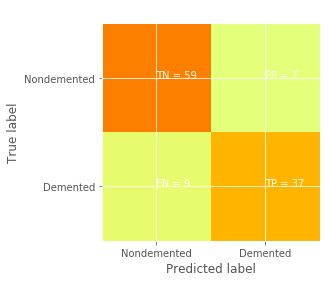

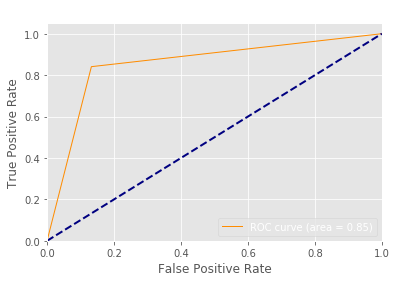


Acuuracy Of the Model:  0.8571428571428571 




In [172]:
#vote_est = [('etc',ensemble.ExtraTreesClassifier()),
           # ('gb',GradientBoostingClassifier()),
            #('abc',AdaBoostClassifier()),
   # ('rfc', ensemble.RandomForestClassifier(criterion='gini', max_depth=8, max_features='auto', n_estimators=200)),
    #('svc', svm.SVC(probability=True)),
    #('xgb', XGBClassifier()),
            #('lbgm',LGBMClassifier())
    #       ]


vote_hard = ensemble.VotingClassifier(estimators = clfs_w_names , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X_train, np.ravel(y_train))
vote_hard.fit(X_train, np.ravel(y_train))
report_performance(vote_hard) 
roc_curves(vote_hard)
accuracy(vote_hard)
#pred = vote_hard.predict(X_test)
#accu = metrics.accuracy_score(y_test,pred)
#print("\nAcuuracy Of the Model: ",accu,"\n\n")



Confusion Matrix:
[[60  6]
 [ 8 38]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        66
           1       0.86      0.83      0.84        46

   micro avg       0.88      0.88      0.88       112
   macro avg       0.87      0.87      0.87       112
weighted avg       0.87      0.88      0.87       112



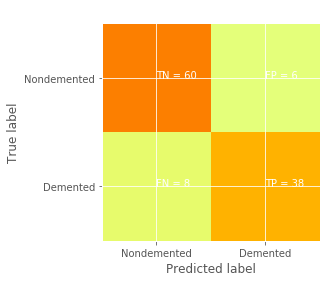

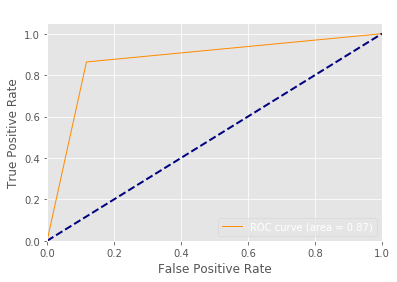


Acuuracy Of the Model:  0.875 




In [173]:


vote_soft = ensemble.VotingClassifier(estimators = clfs_w_names , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X_train, np.ravel(y_train))
vote_soft.fit(X_train, np.ravel(y_train))
report_performance(vote_soft) 
roc_curves(vote_soft)
accuracy(vote_soft)
#pred = vote_soft.predict(X_test)
#accu = metrics.accuracy_score(y_test,pred)
#print("\nAcuuracy Of the Model: ",accu,"\n\n")

# Model Comparison


## stuff

In [138]:
from sklearn import metrics
def plot_confusion_metrix(y_test,model_test):
    cm = metrics.confusion_matrix(y_test, model_test)
    plt.figure(1)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Nondemented','Demented']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [139]:
from sklearn.metrics import roc_curve, auc
def report_performance(model):

    model_test = model.predict(X_test)

    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(y_test, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(y_test, model_test))
    #cm = metrics.confusion_matrix(y_test, model_test)
    plot_confusion_metrix(y_test, model_test)

total_fpr = {}
total_tpr = {}
def roc_curves(model):
    predictions_test = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(predictions_test,y_test)
    roc_auc = auc(fpr, tpr)
    total_fpr[str((str(model).split('(')[0]))] = fpr
    total_tpr[str((str(model).split('(')[0]))] = tpr
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

roll thru each and print shit

In [140]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

clfs =[xgbee,knn_cv,log_cv,svm_cv,ExtraTreesClassifier(),GradientBoostingClassifier(),AdaBoostClassifier()]

In [141]:
from sklearn import metrics
total_accuracy = {}
def accuracy(model):
    pred = model.predict(X_test)
    accu = metrics.accuracy_score(y_test,pred)
    print("\nAcuuracy Of the Model: ",accu,"\n\n")
    total_accuracy[str((str(model).split('(')[0]))] = accu

In [142]:
#np.ravel(y_train)

## loop thru each model n plot

XGBClassifier : 


Confusion Matrix:
[[58  8]
 [11 35]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        66
           1       0.81      0.76      0.79        46

   micro avg       0.83      0.83      0.83       112
   macro avg       0.83      0.82      0.82       112
weighted avg       0.83      0.83      0.83       112



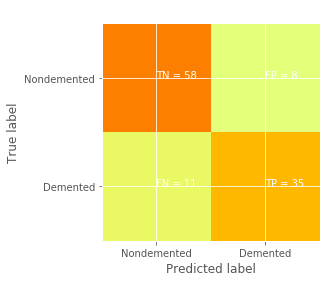

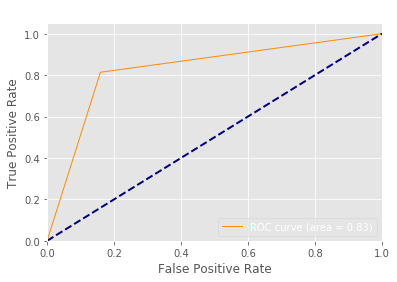


Acuuracy Of the Model:  0.8303571428571429 


GridSearchCV : 


Confusion Matrix:
[[58  8]
 [12 34]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        66
           1       0.81      0.74      0.77        46

   micro avg       0.82      0.82      0.82       112
   macro avg       0.82      0.81      0.81       112
weighted avg       0.82      0.82      0.82       112



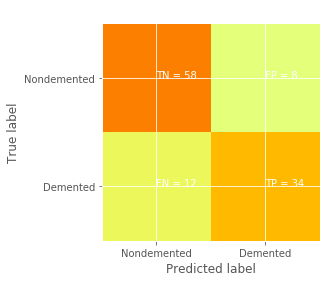

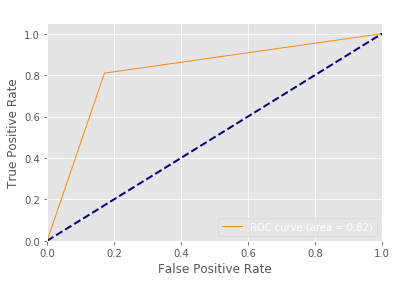


Acuuracy Of the Model:  0.8214285714285714 


GridSearchCV : 


Confusion Matrix:
[[54 12]
 [10 36]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        66
           1       0.75      0.78      0.77        46

   micro avg       0.80      0.80      0.80       112
   macro avg       0.80      0.80      0.80       112
weighted avg       0.81      0.80      0.80       112



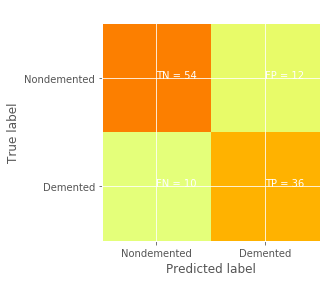

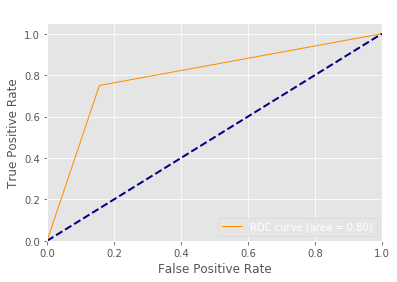


Acuuracy Of the Model:  0.8035714285714286 


GridSearchCV : 


Confusion Matrix:
[[56 10]
 [ 9 37]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        66
           1       0.79      0.80      0.80        46

   micro avg       0.83      0.83      0.83       112
   macro avg       0.82      0.83      0.83       112
weighted avg       0.83      0.83      0.83       112



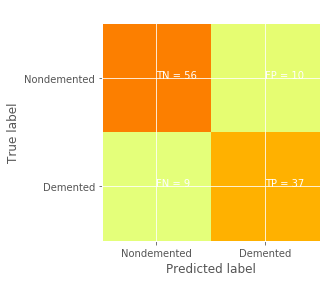

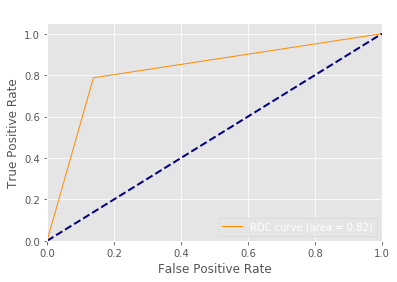


Acuuracy Of the Model:  0.8303571428571429 


ExtraTreesClassifier : 


Confusion Matrix:
[[62  4]
 [ 7 39]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        66
           1       0.91      0.85      0.88        46

   micro avg       0.90      0.90      0.90       112
   macro avg       0.90      0.89      0.90       112
weighted avg       0.90      0.90      0.90       112



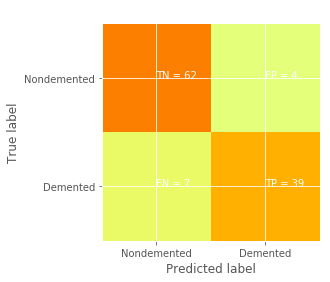

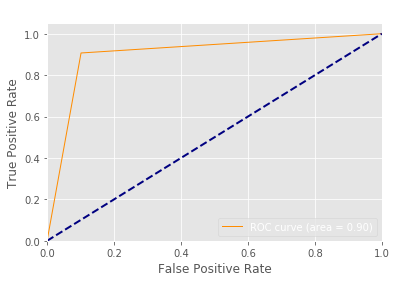


Acuuracy Of the Model:  0.9017857142857143 


GradientBoostingClassifier : 


Confusion Matrix:
[[58  8]
 [ 8 38]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        66
           1       0.83      0.83      0.83        46

   micro avg       0.86      0.86      0.86       112
   macro avg       0.85      0.85      0.85       112
weighted avg       0.86      0.86      0.86       112



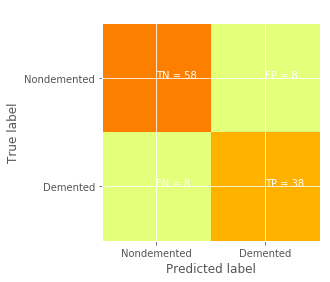

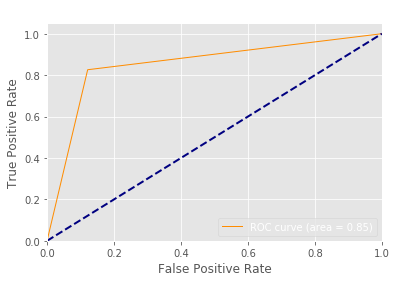


Acuuracy Of the Model:  0.8571428571428571 


AdaBoostClassifier : 


Confusion Matrix:
[[56 10]
 [ 7 39]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        66
           1       0.80      0.85      0.82        46

   micro avg       0.85      0.85      0.85       112
   macro avg       0.84      0.85      0.84       112
weighted avg       0.85      0.85      0.85       112



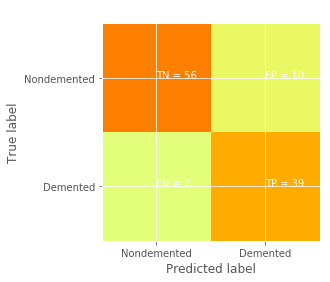

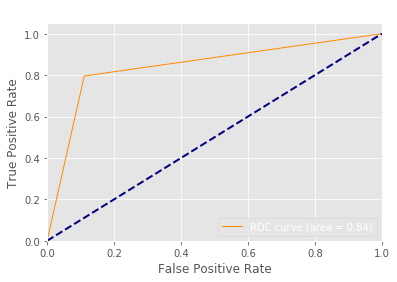


Acuuracy Of the Model:  0.8482142857142857 




In [143]:
for model in clfs:
    print(str(model).split('(')[0],": ")
    model.fit(X_train,np.ravel(y_train))
    X = pd.DataFrame(X_train)
    report_performance(model)
    roc_curves(model)
    accuracy(model)

## all on one plot

plot where all models land together on pone plot?

In [155]:
# Model vs accuracy

data = total_accuracy.values()
#labels = str(clfs)
labels =["xgbee","knn_cv","log_cv","svm_cv","ExtraTreesClassifier()","GradientBoostingClassifier()","AdaBoostClassifier()"]
print(data)
print(labels)

dict_values([0.8303571428571429, 0.8303571428571429, 0.9017857142857143, 0.8571428571428571, 0.8482142857142857])
['xgbee', 'knn_cv', 'log_cv', 'svm_cv', 'ExtraTreesClassifier()', 'GradientBoostingClassifier()', 'AdaBoostClassifier()']


Text(0, 0.5, 'Accuracy')

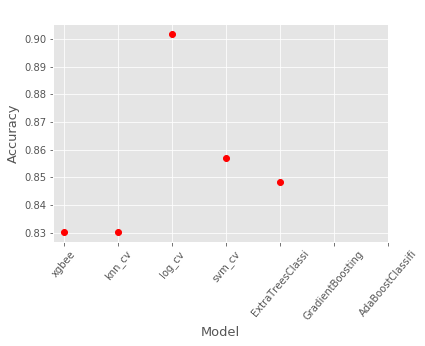

In [159]:
plt.plot([i for i, e in enumerate(data)], data, 'ro'); plt.xticks([i for i, e in enumerate(labels)], [l[0:16] for l in labels])
plt.title("Model Vs Accuracy",fontsize = 14)
plt.xlabel('Model',fontsize = 13)
plt.xticks(rotation = 50)
plt.ylabel('Accuracy',fontsize = 13)

In [194]:
# ponly have 5 data points/ models showing, 
#easier just type out dictionary

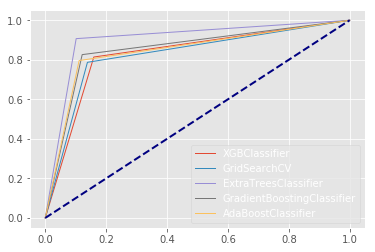

In [157]:
for i in total_fpr.keys():
    plt.plot(total_fpr[i],total_tpr[i],lw=1, label=i)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()

# some EDA graphs/plots

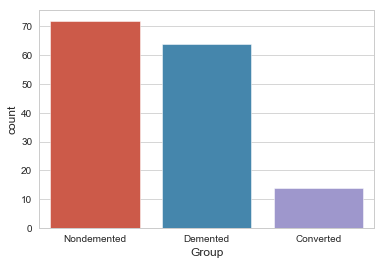

In [176]:
eda = data2
sns.set_style("whitegrid")
ex_df = eda.loc[eda['Visit'] == 1] # #same person visits two or more time so only take the single visit data
sns.countplot(x='Group', data=ex_df)

In [177]:
#the fuck is converted?
eda['Group'].value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

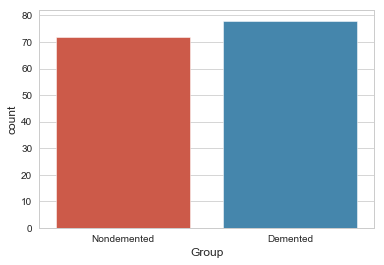

In [179]:
# subjects were characterized as nondemented at the time of their 
#initial visit and were subsequently characterized as demented 
#at a later visit
#We have three groups so convert Converted Group Into Demented

ex_df['Group'] = ex_df['Group'].replace(['Converted'], ['Demented'])
eda['Group'] = eda['Group'].replace(['Converted'], ['Demented'])
sns.countplot(x='Group', data=ex_df)

              F   M
Demented     38  40
Nondemented  50  22


Text(0.5, 1.0, 'Gender and Demented rate')

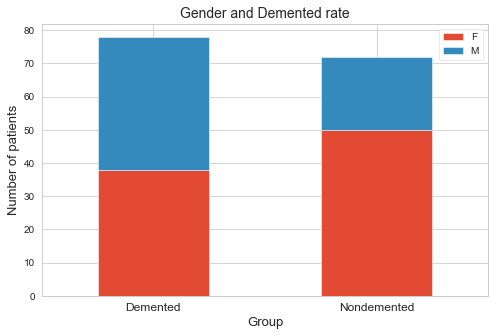

In [180]:
def bar_chart(feature):
    Demented = ex_df[ex_df['Group']=='Demented'][feature].value_counts()
    Nondemented = ex_df[ex_df['Group']=='Nondemented'][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))
    print(df_bar)
                
                
# Gender  and  Group ( Female=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group',fontsize=13)
plt.xticks(rotation=0,fontsize=12)
plt.ylabel('Number of patients',fontsize=13)
plt.legend()
plt.title('Gender and Demented rate',fontsize=14)

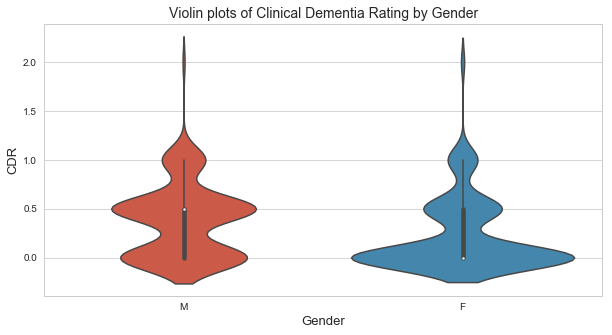

In [185]:
plt.figure(figsize=(10,5))
sns.violinplot(x='M/F', y='CDR', data=eda)
plt.title('Violin plots of Clinical Dementia Rating by Gender',fontsize=14)
plt.xlabel('Gender',fontsize=13)
plt.ylabel('CDR',fontsize=13)
plt.show()

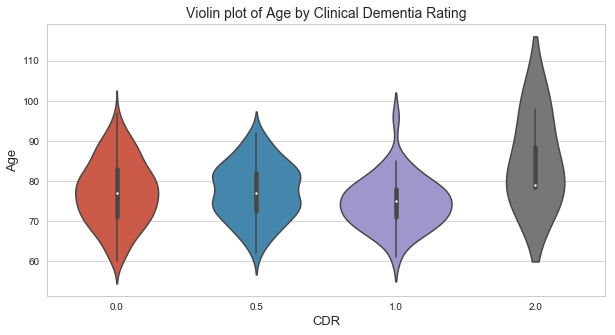

In [186]:
plt.figure(figsize=(10,5))
sns.violinplot(x='CDR', y='Age', data=eda)
plt.title('Violin plot of Age by Clinical Dementia Rating',fontsize=14)
plt.xlabel('CDR',fontsize=13)
plt.ylabel('Age',fontsize=13)
plt.show()

# couple more/extra models

## Random forest

In [ ]:
feature_col_names = ["M/F", "Age", "EDUC", "SES", "MMSE", "eTIV", "nWBV", "ASF"]



Confusion Matrix:
[[57  9]
 [11 35]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        66
           1       0.80      0.76      0.78        46

   micro avg       0.82      0.82      0.82       112
   macro avg       0.82      0.81      0.81       112
weighted avg       0.82      0.82      0.82       112



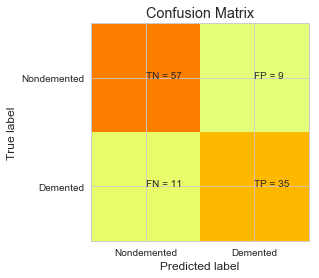

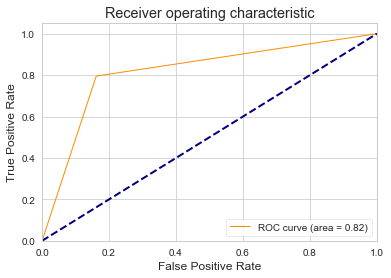


Acuuracy Of the Model:  0.8214285714285714 




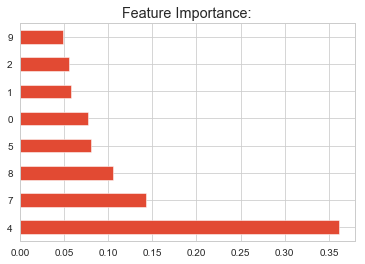

In [191]:
rfc=RandomForestClassifier(criterion='gini',max_depth=8,max_features='auto',n_estimators=200)

param_grid = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini']
}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring = 'roc_auc')
rfc.fit(X_train, y_train)
#print("Best parameters set found on development set:")
#print(rfc.best_params_)
report_performance(rfc) 
roc_curves(rfc)
accuracy(rfc)

feat_importances = pd.Series(rfc.feature_importances_)
feat_importances.nlargest(8).plot(kind='barh')
plt.title("Feature Importance:")
plt.show()

In [ ]:
# feature_col_names = [ "", "",""]
# add , index=feature_col_names

## D tree



Confusion Matrix:
[[52 14]
 [12 34]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        66
           1       0.71      0.74      0.72        46

   micro avg       0.77      0.77      0.77       112
   macro avg       0.76      0.76      0.76       112
weighted avg       0.77      0.77      0.77       112



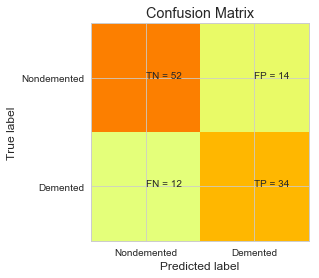

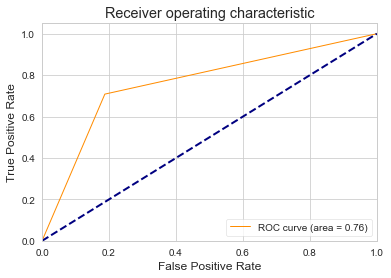


Acuuracy Of the Model:  0.7678571428571429 




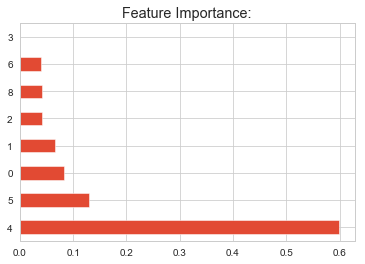

In [192]:
clf_dtc = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=42)
clf_dtc.fit(X_train, y_train)
report_performance(clf_dtc) 
roc_curves(clf_dtc)
accuracy(clf_dtc)
#importances = clf.feature_importances_


feat_importances = pd.Series(clf_dtc.feature_importances_)
feat_importances.nlargest(8).plot(kind='barh')
plt.title("Feature Importance:")
plt.show()

In [ ]:
# same thing again
# make a feature_col_names = [ "", "",""]
# add , index=feature_col_names to pd.Series

# more stuff